# Model Training with Synthetic Data - Analysis

In [1]:
# import libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os
import seaborn as sns

from utils import get_predictions, make_confusion_matrix, AUROC, plot_roc, make_barplot

In [2]:
with open("../../classes.txt") as f:
    classes = f.read().splitlines()
pandas_query = [f'Prob_{c}' for c in classes]
model_names = ['R_r1', 'R1800S_r1', 'R3600S_r1', 'RB_r1', 'R_r2', 'R1800S_r2', 'R3600S_r2', 'RB_r2', 'RBProxy', 'S']

# Analyse the full test set

## Get predictions for all trained models

In [3]:
all_csvs = [path for path in os.listdir('.') if path.endswith('.csv')]
model_dfs = [get_predictions(m + '.csv', classes=pandas_query) for m in model_names]
preds_dict = {k: v for k, v in zip(model_names, model_dfs)}

## Plot confusion matrices for all models 

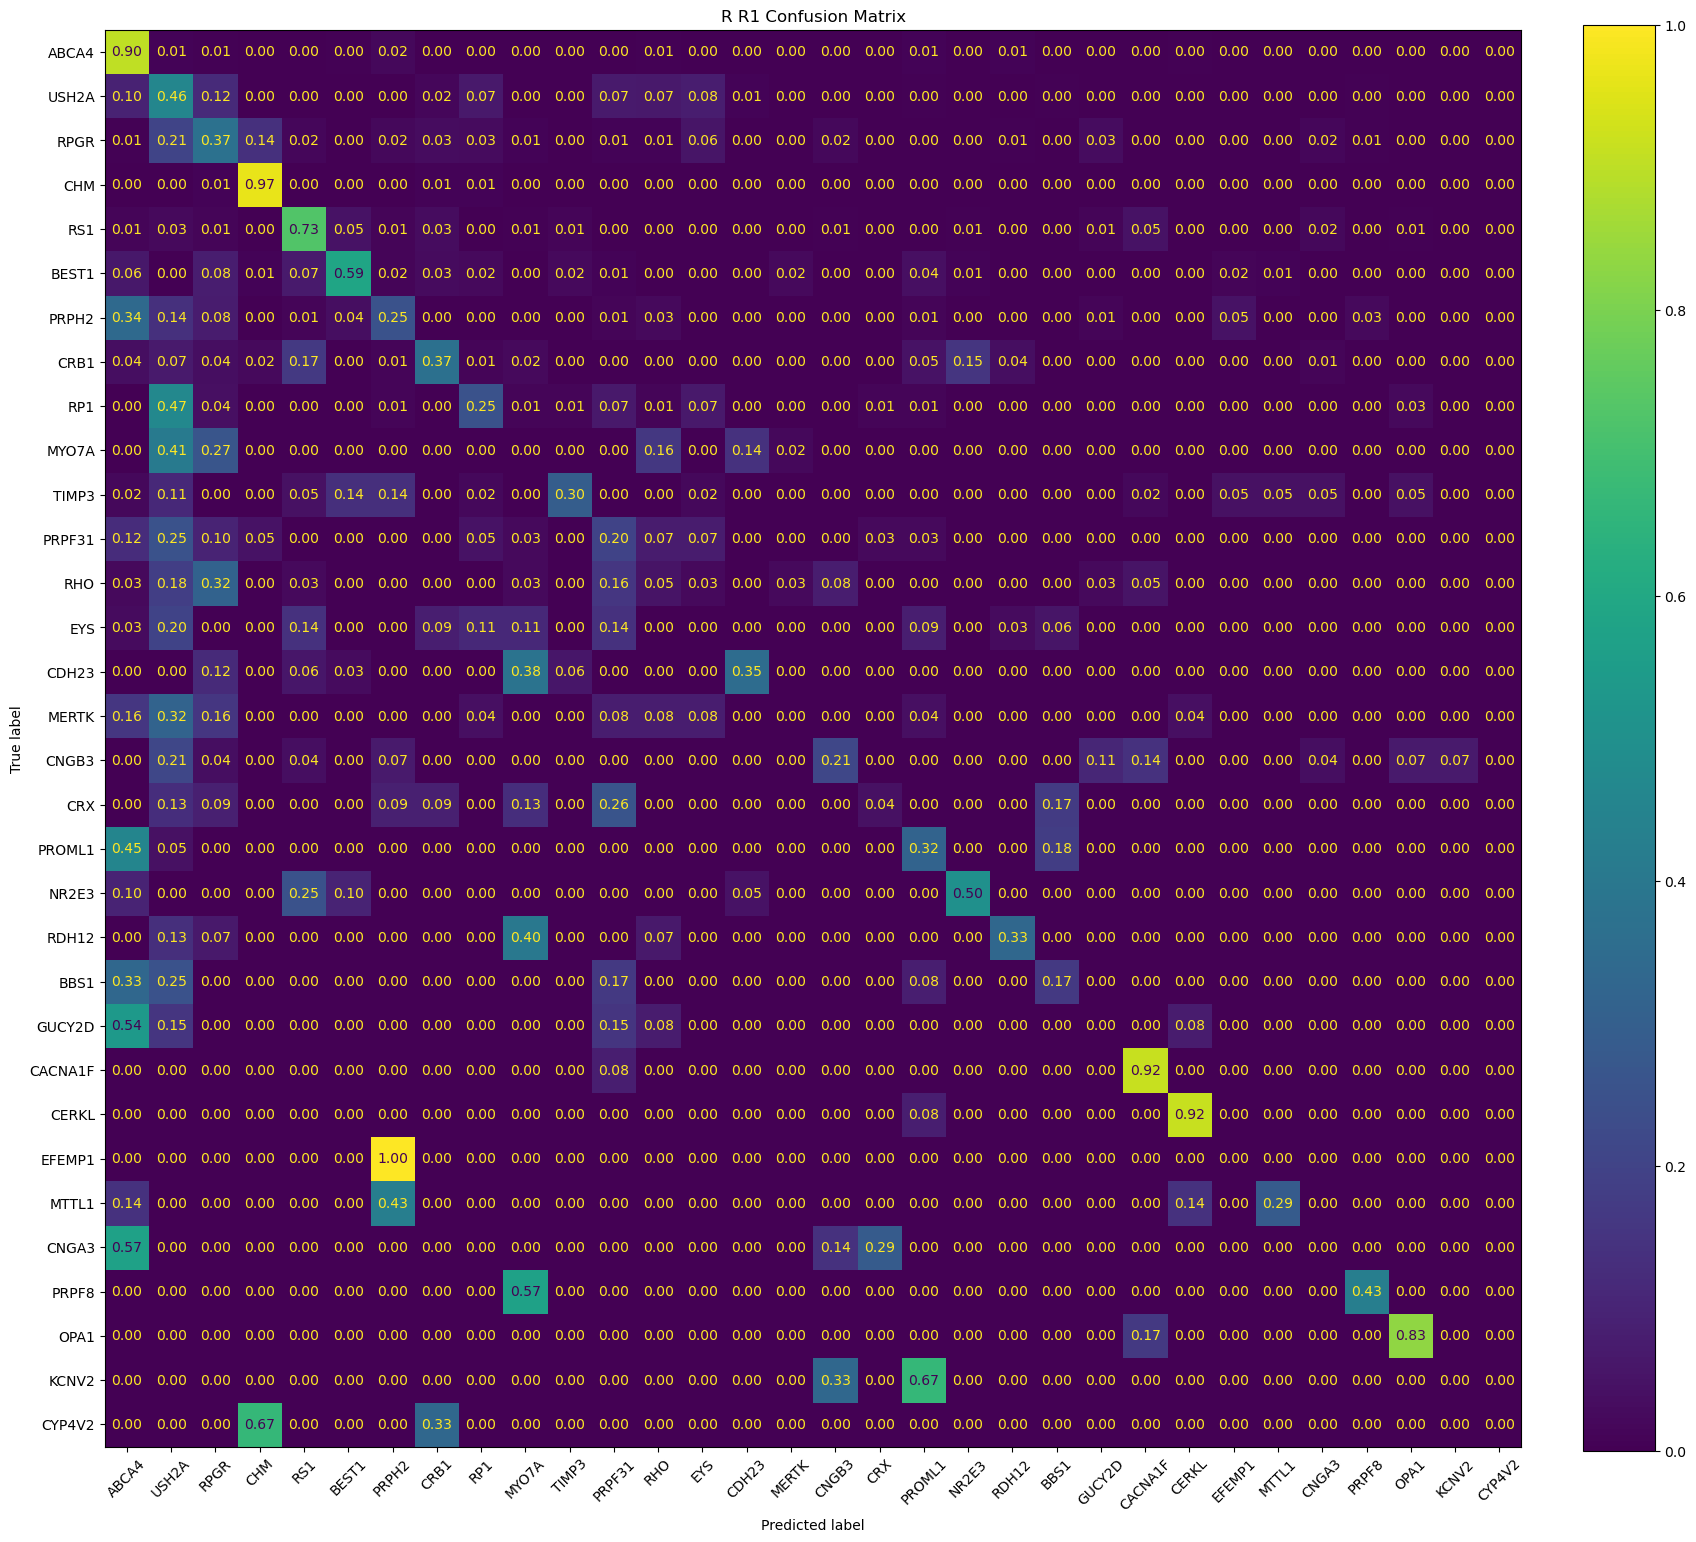

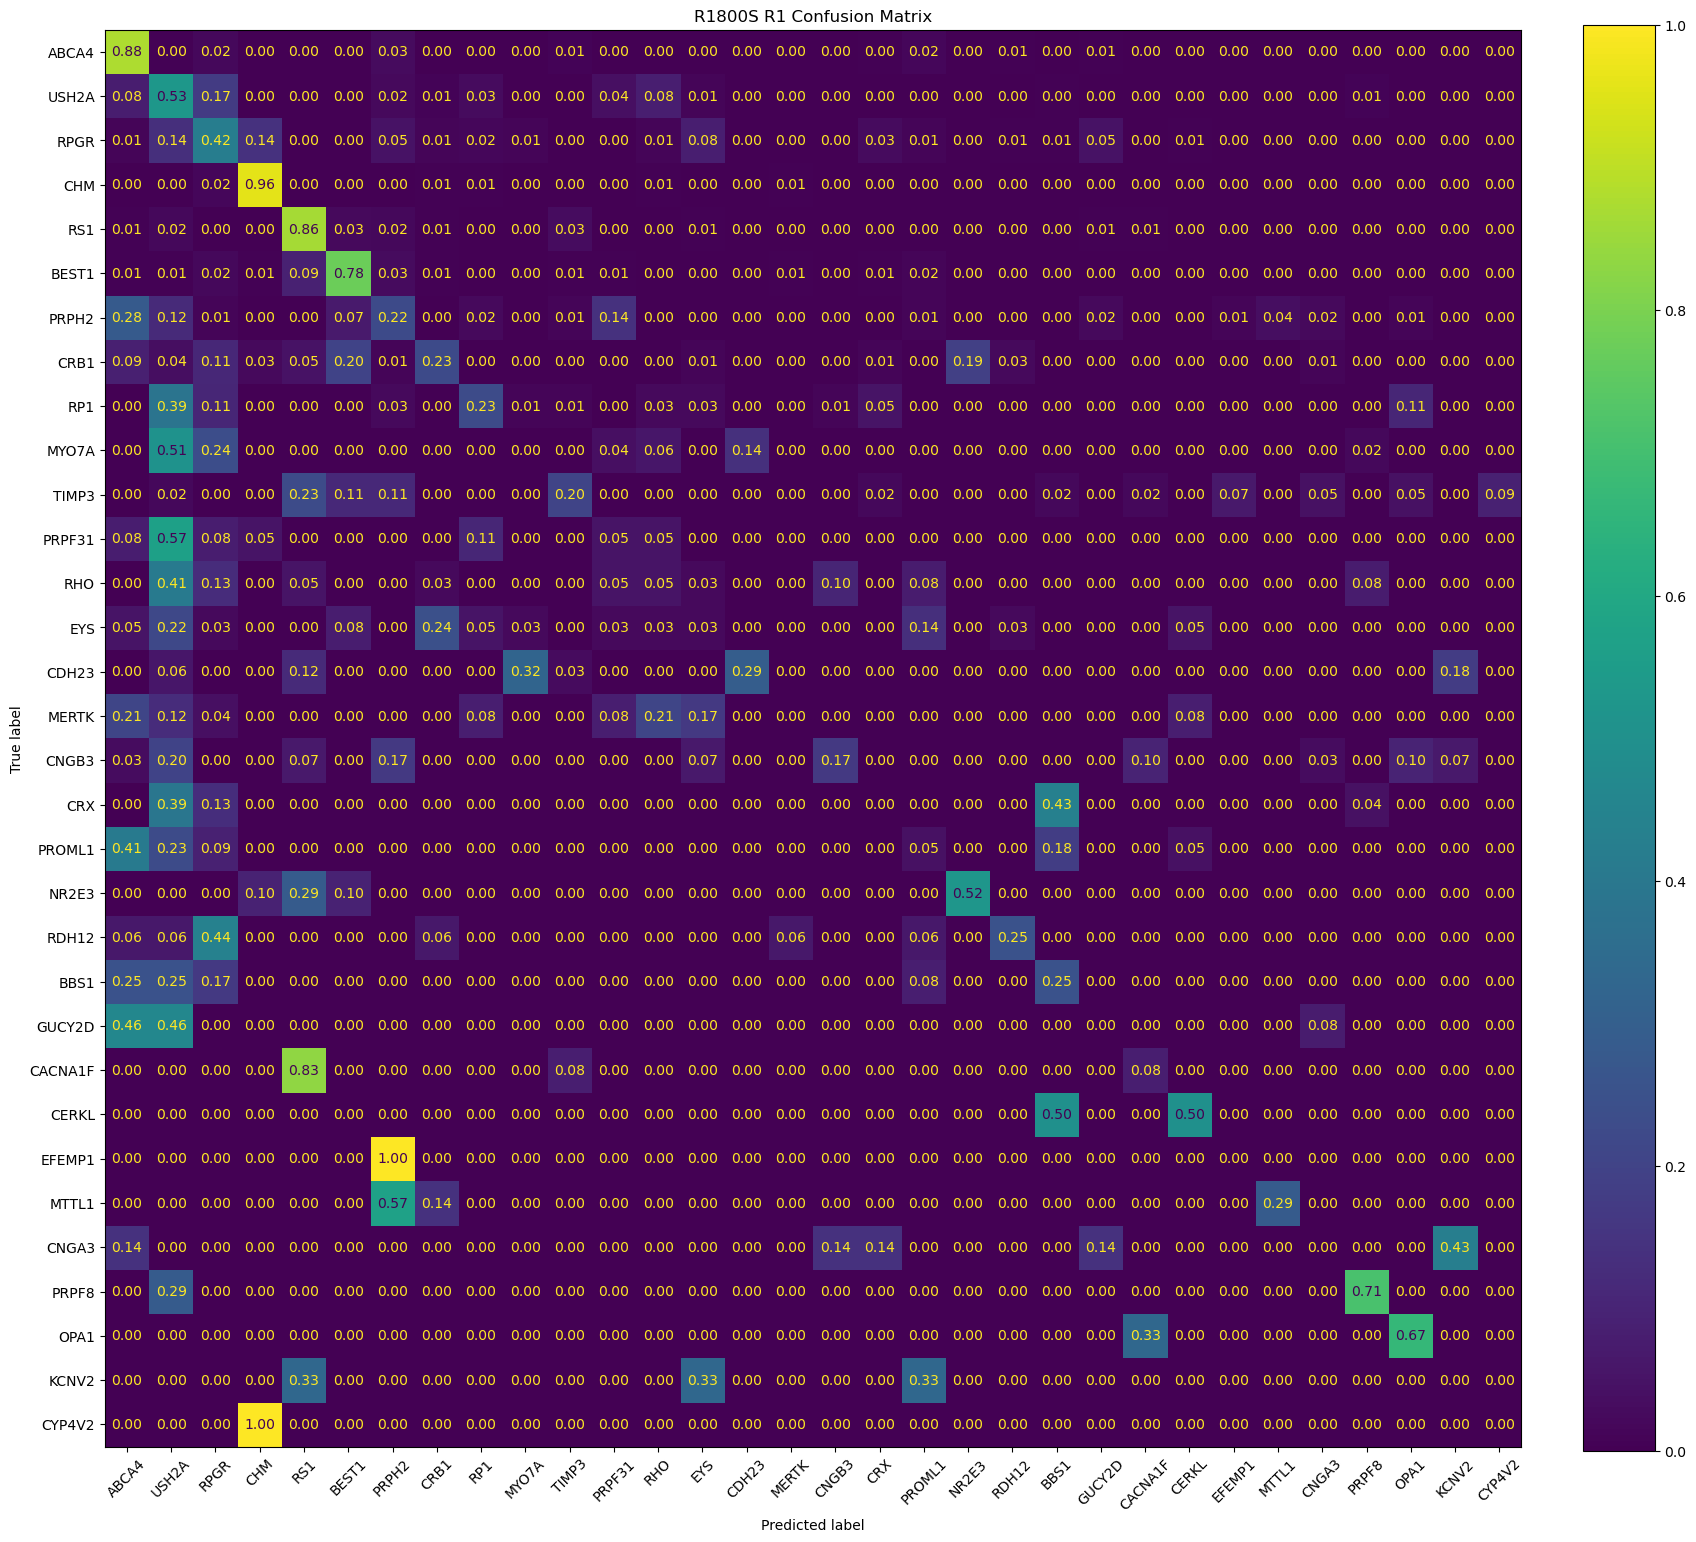

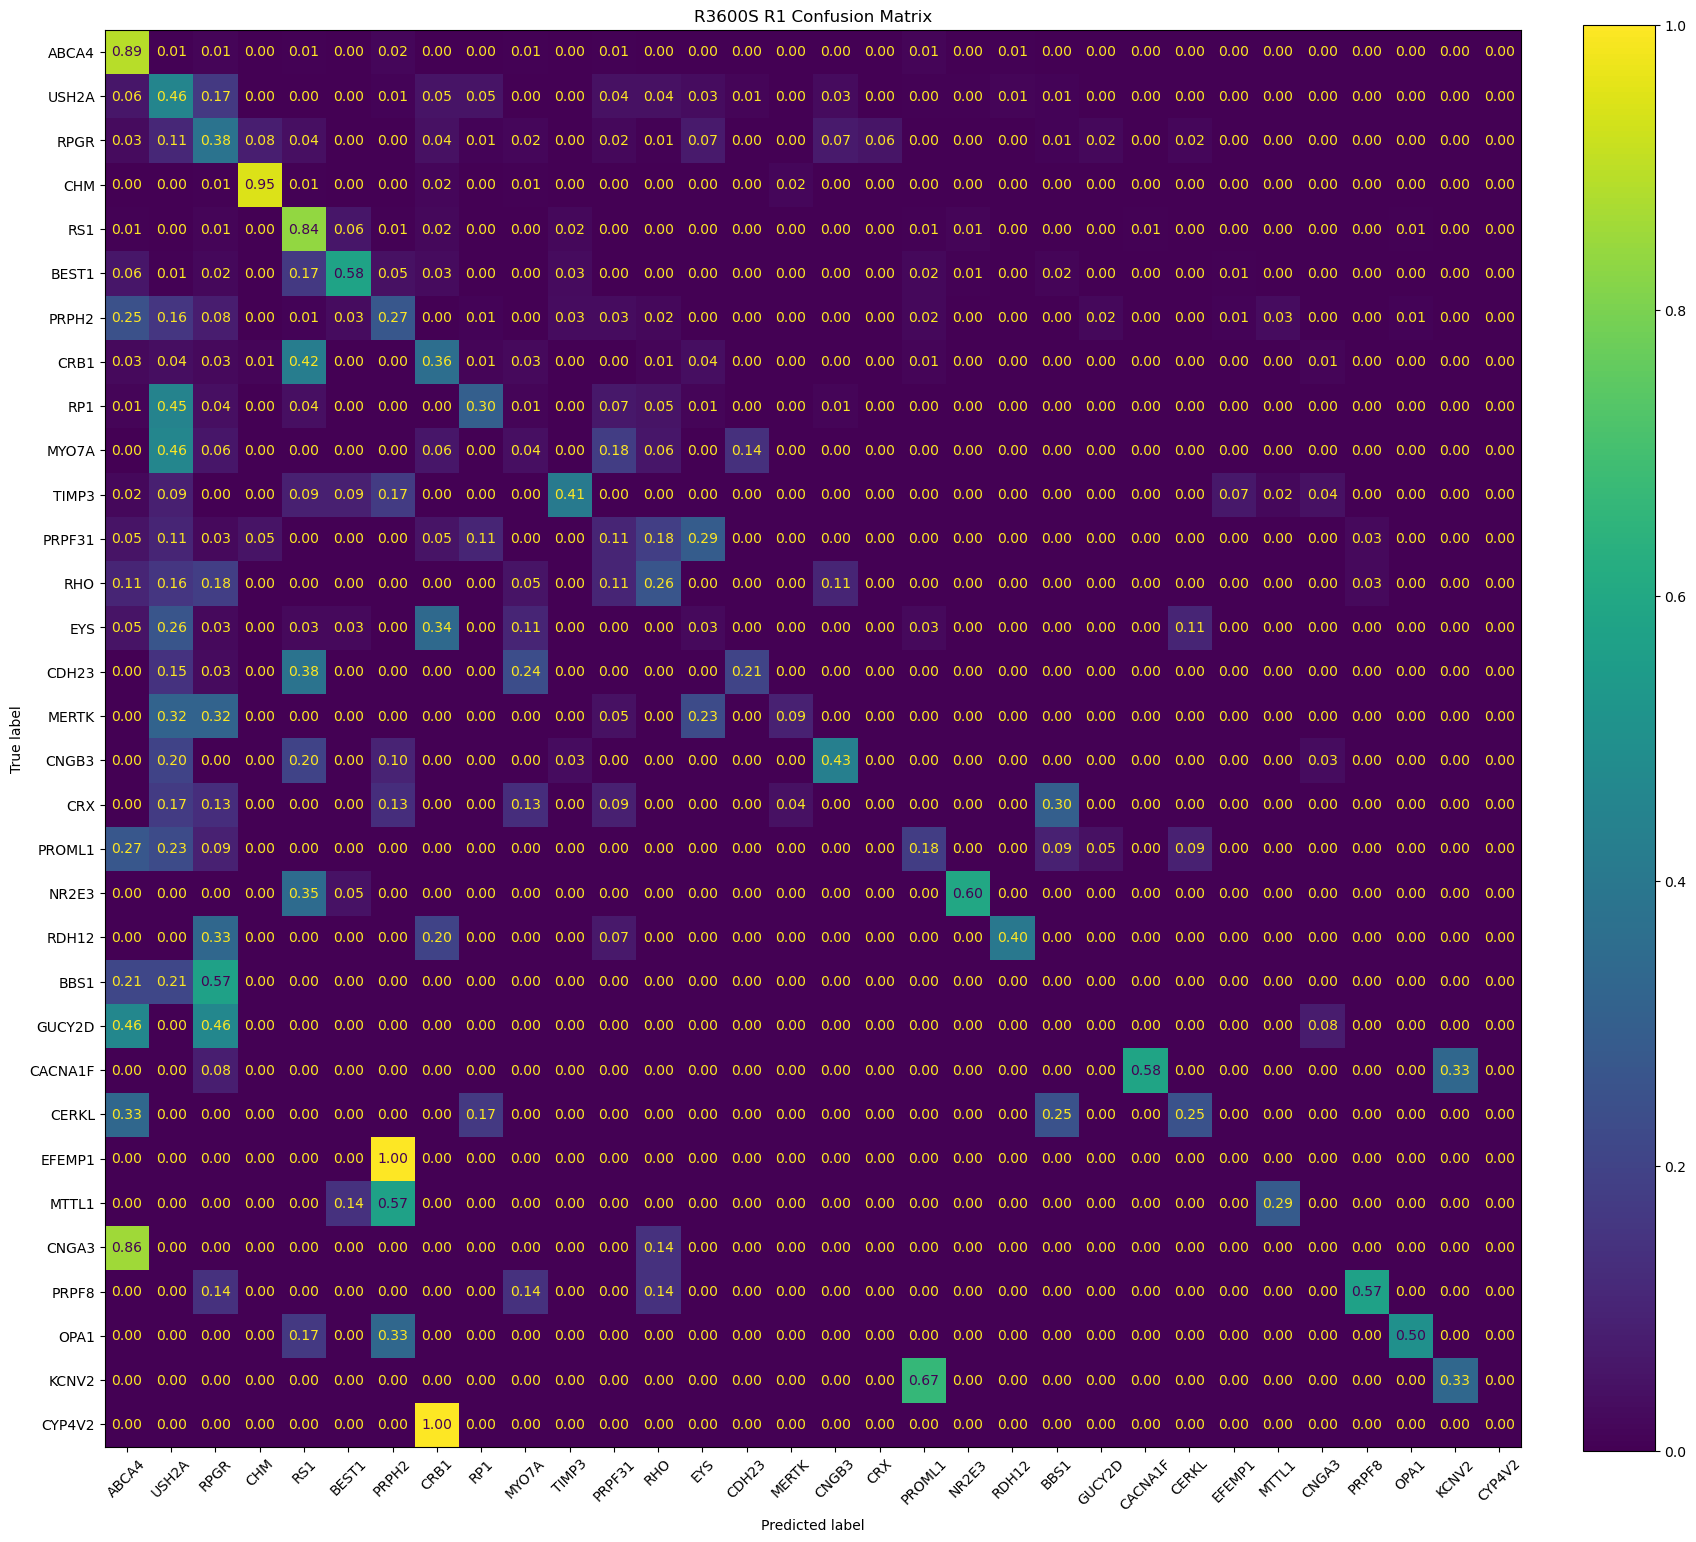

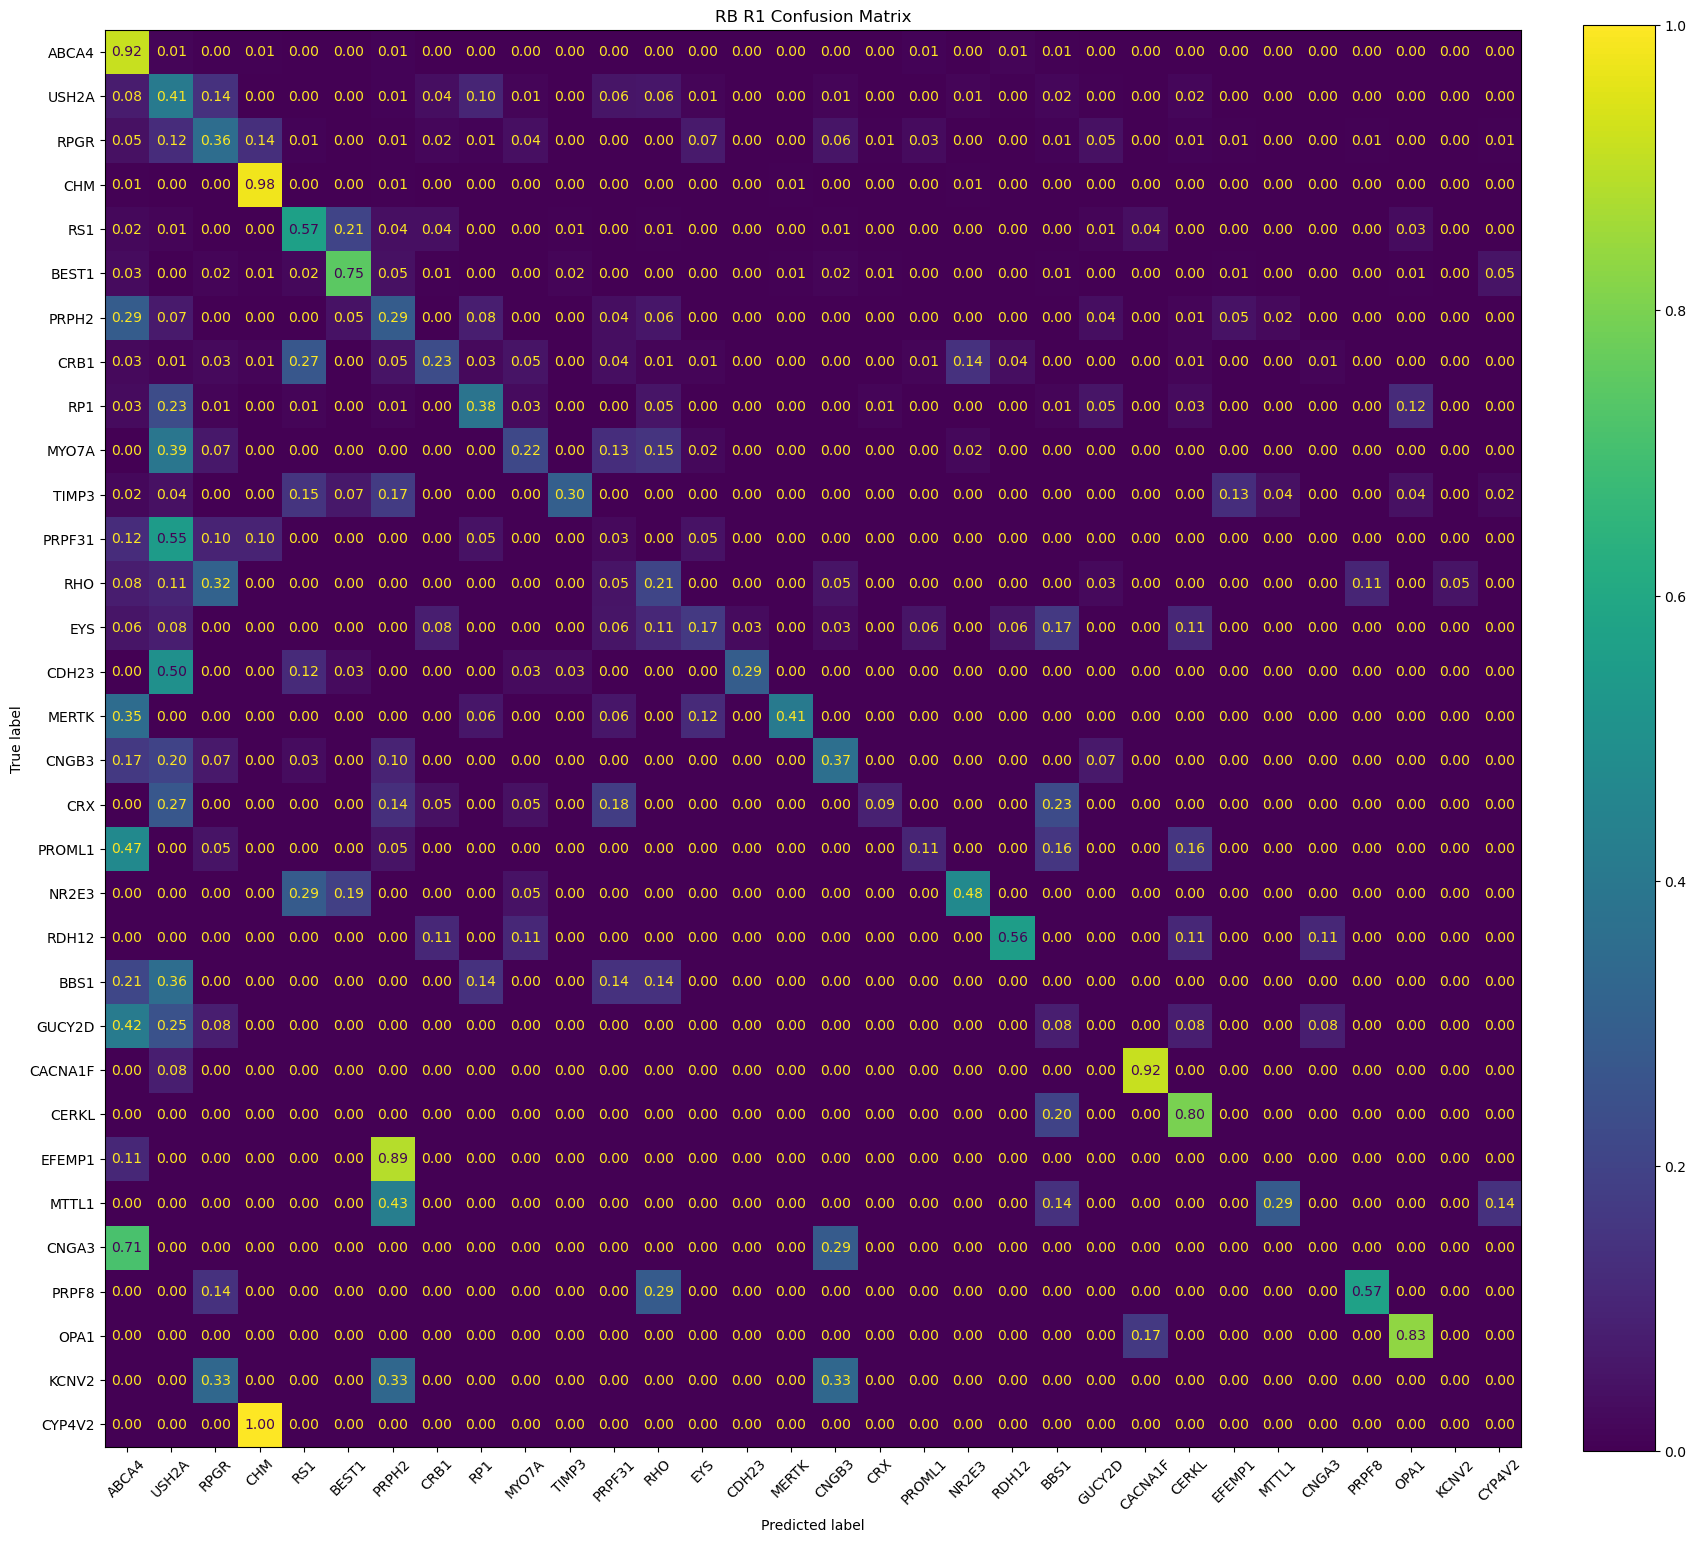

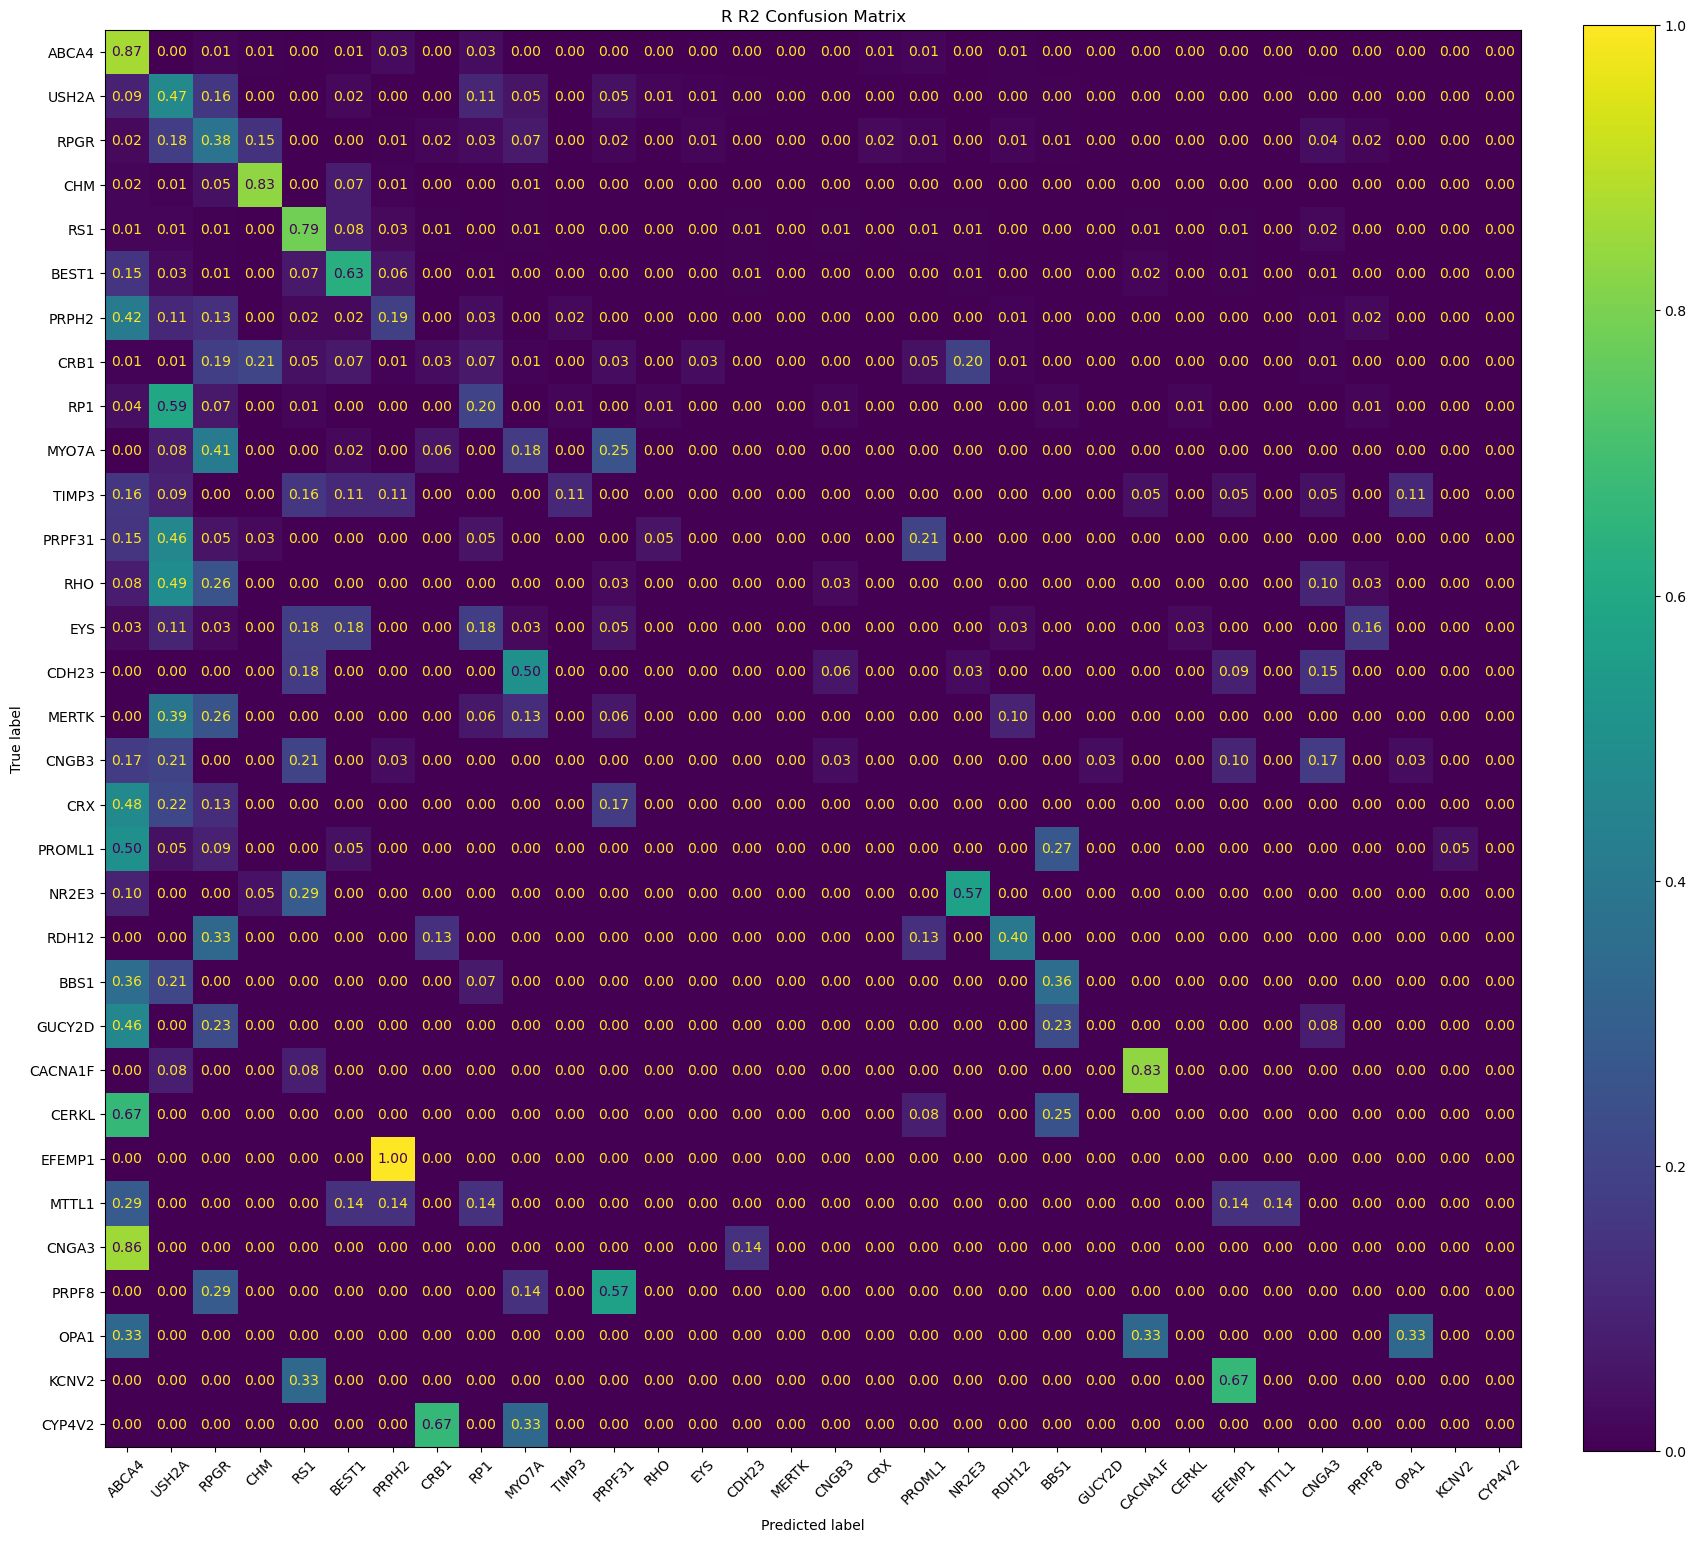

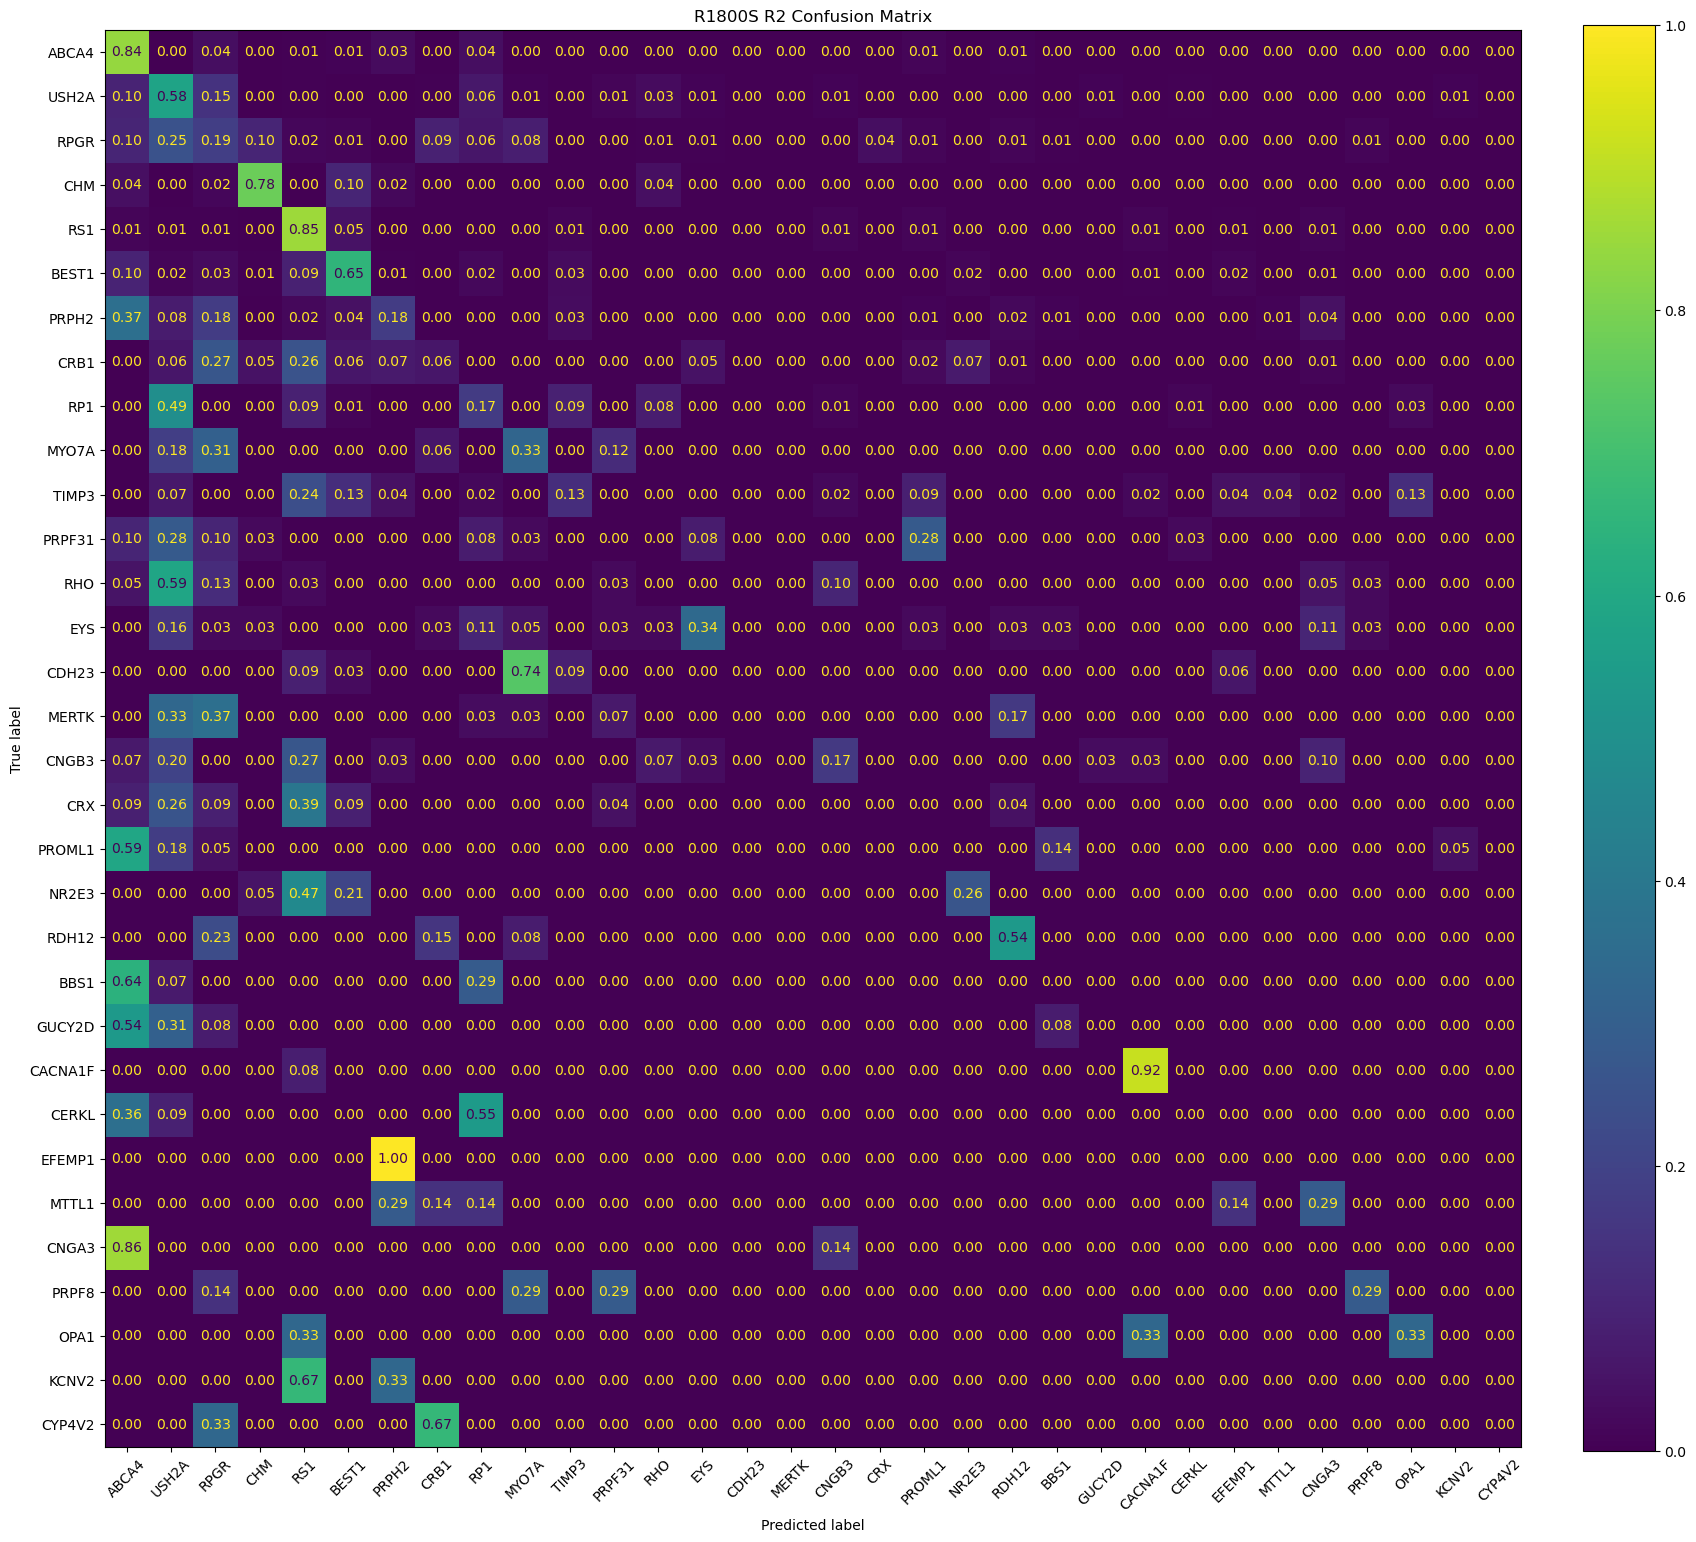

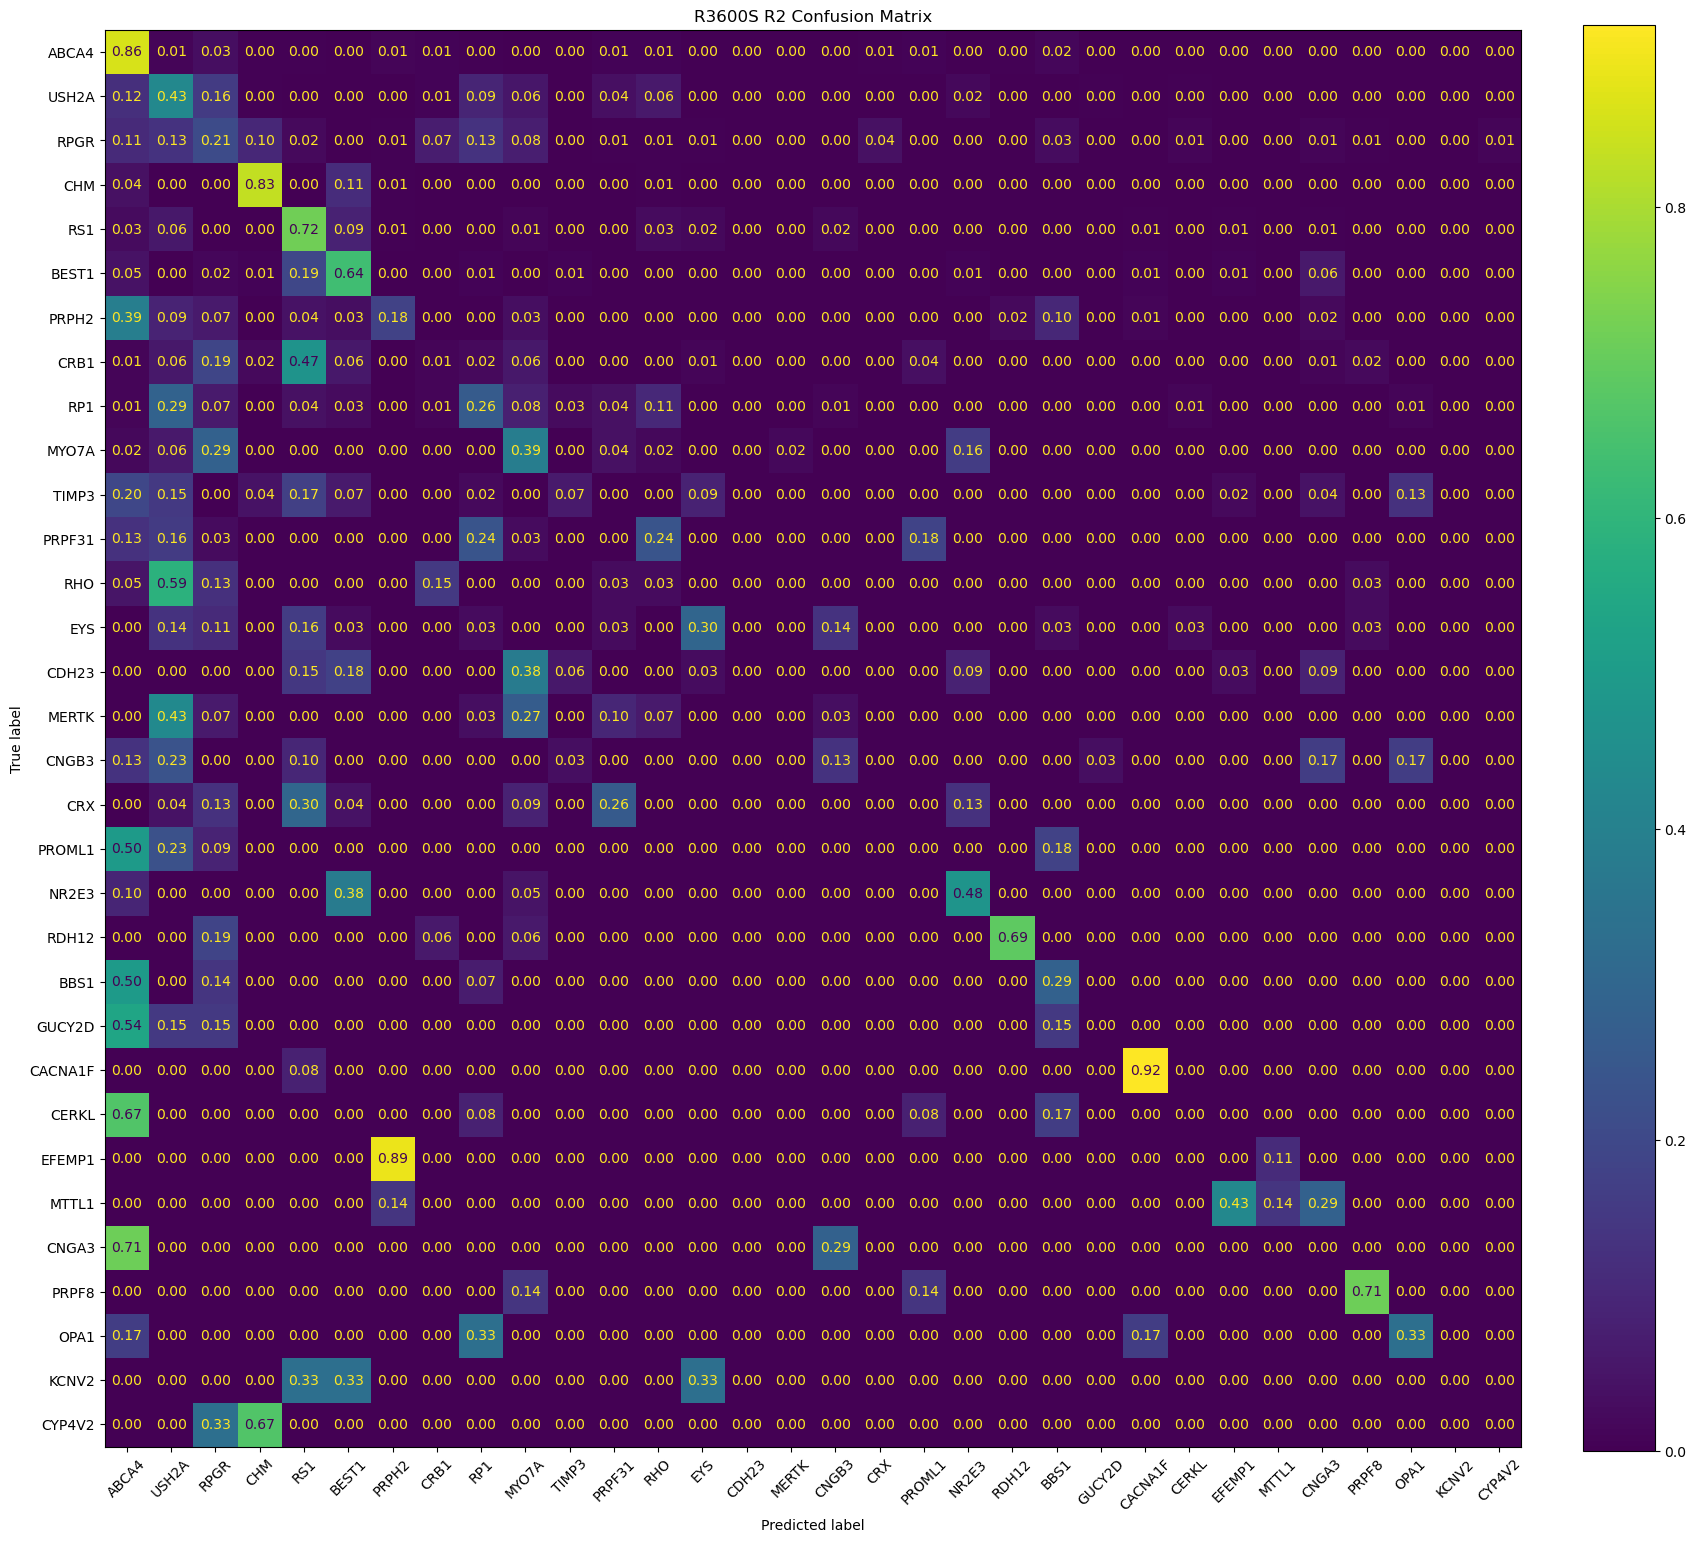

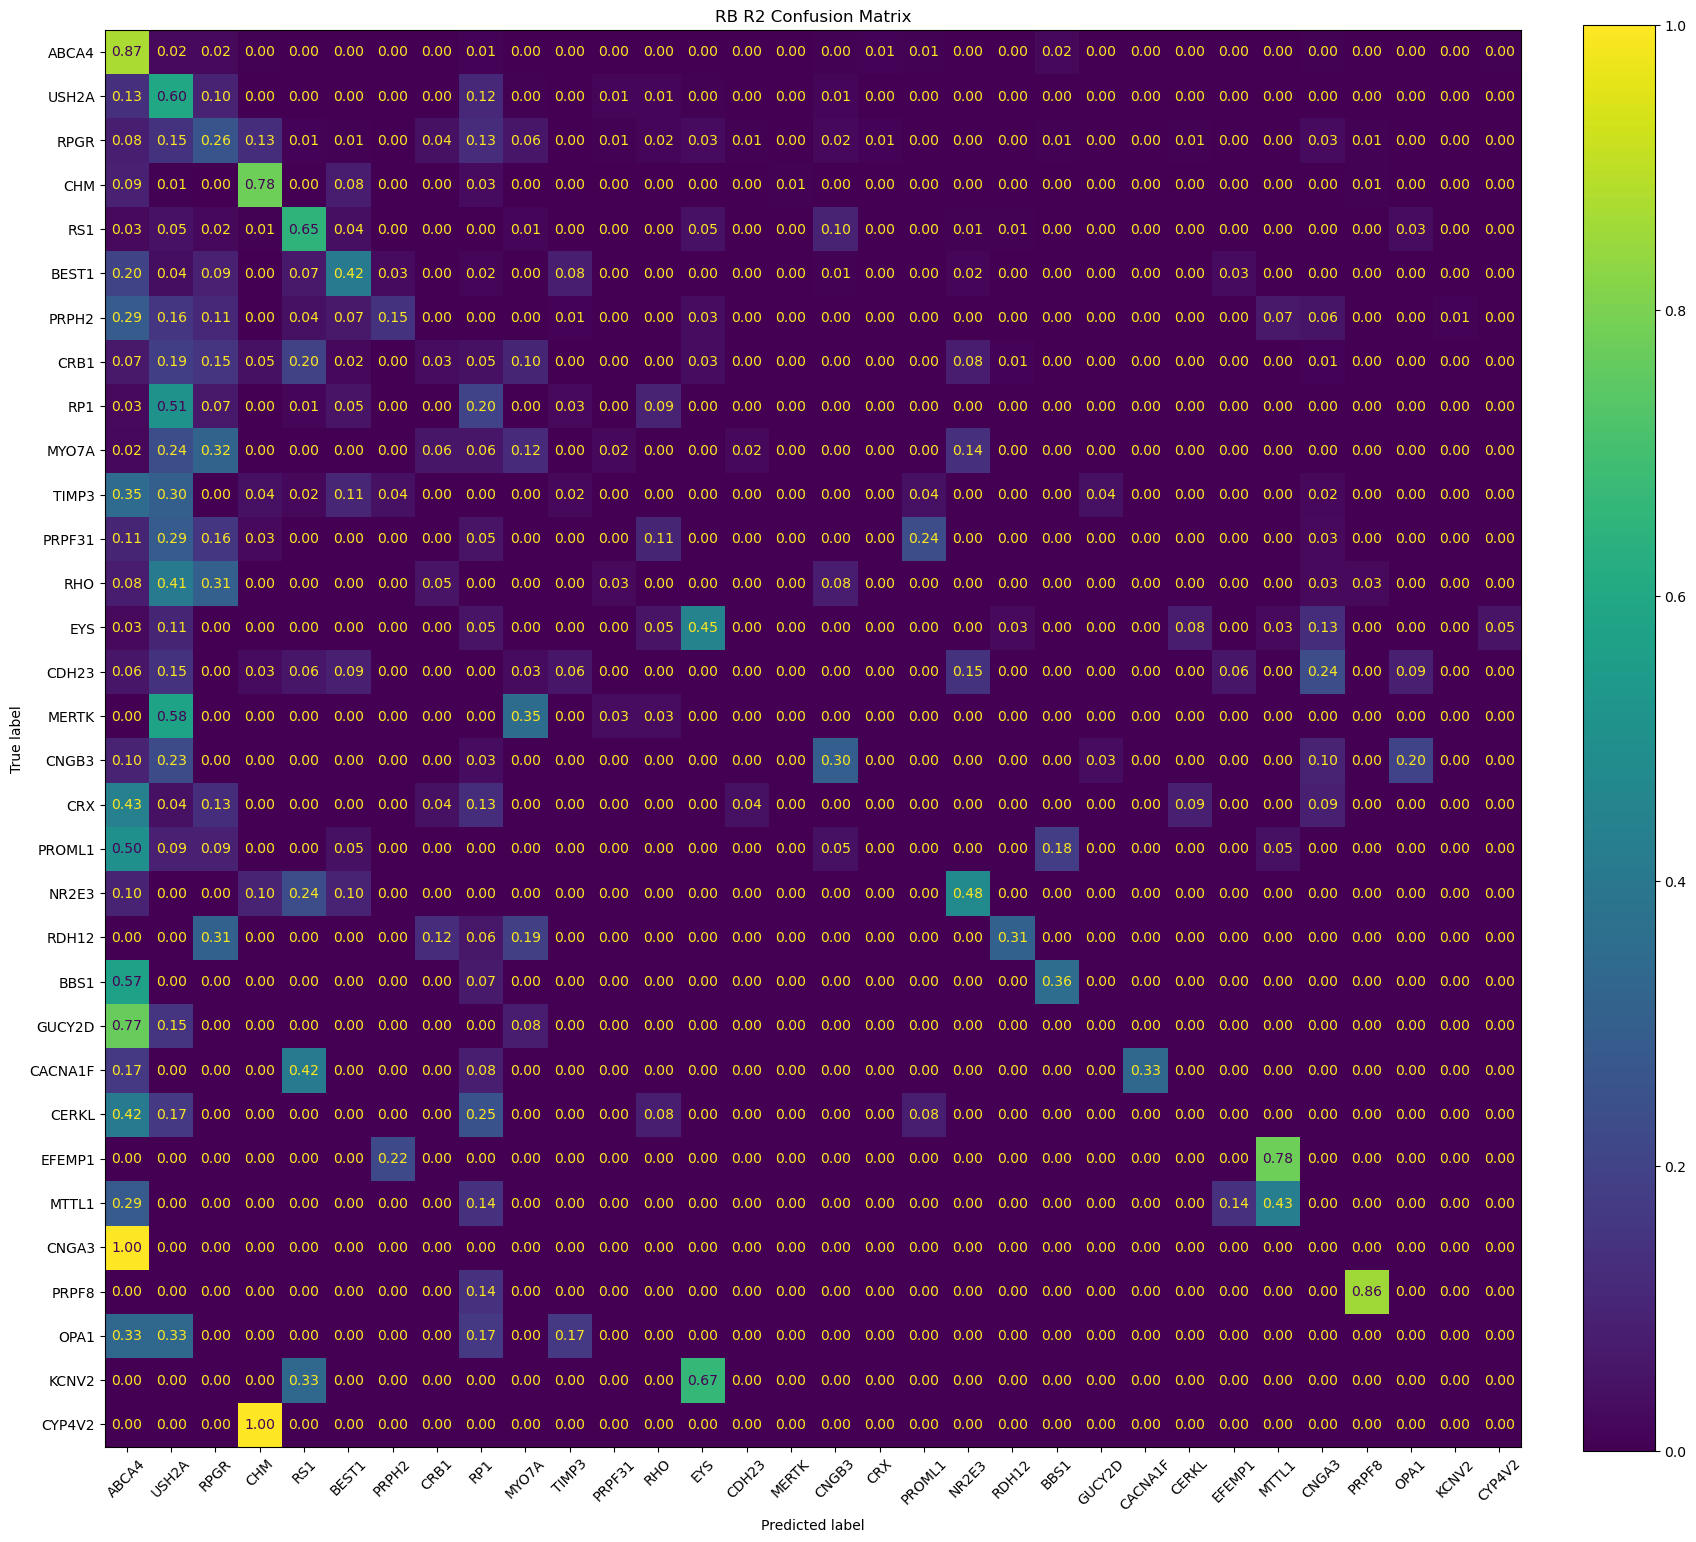

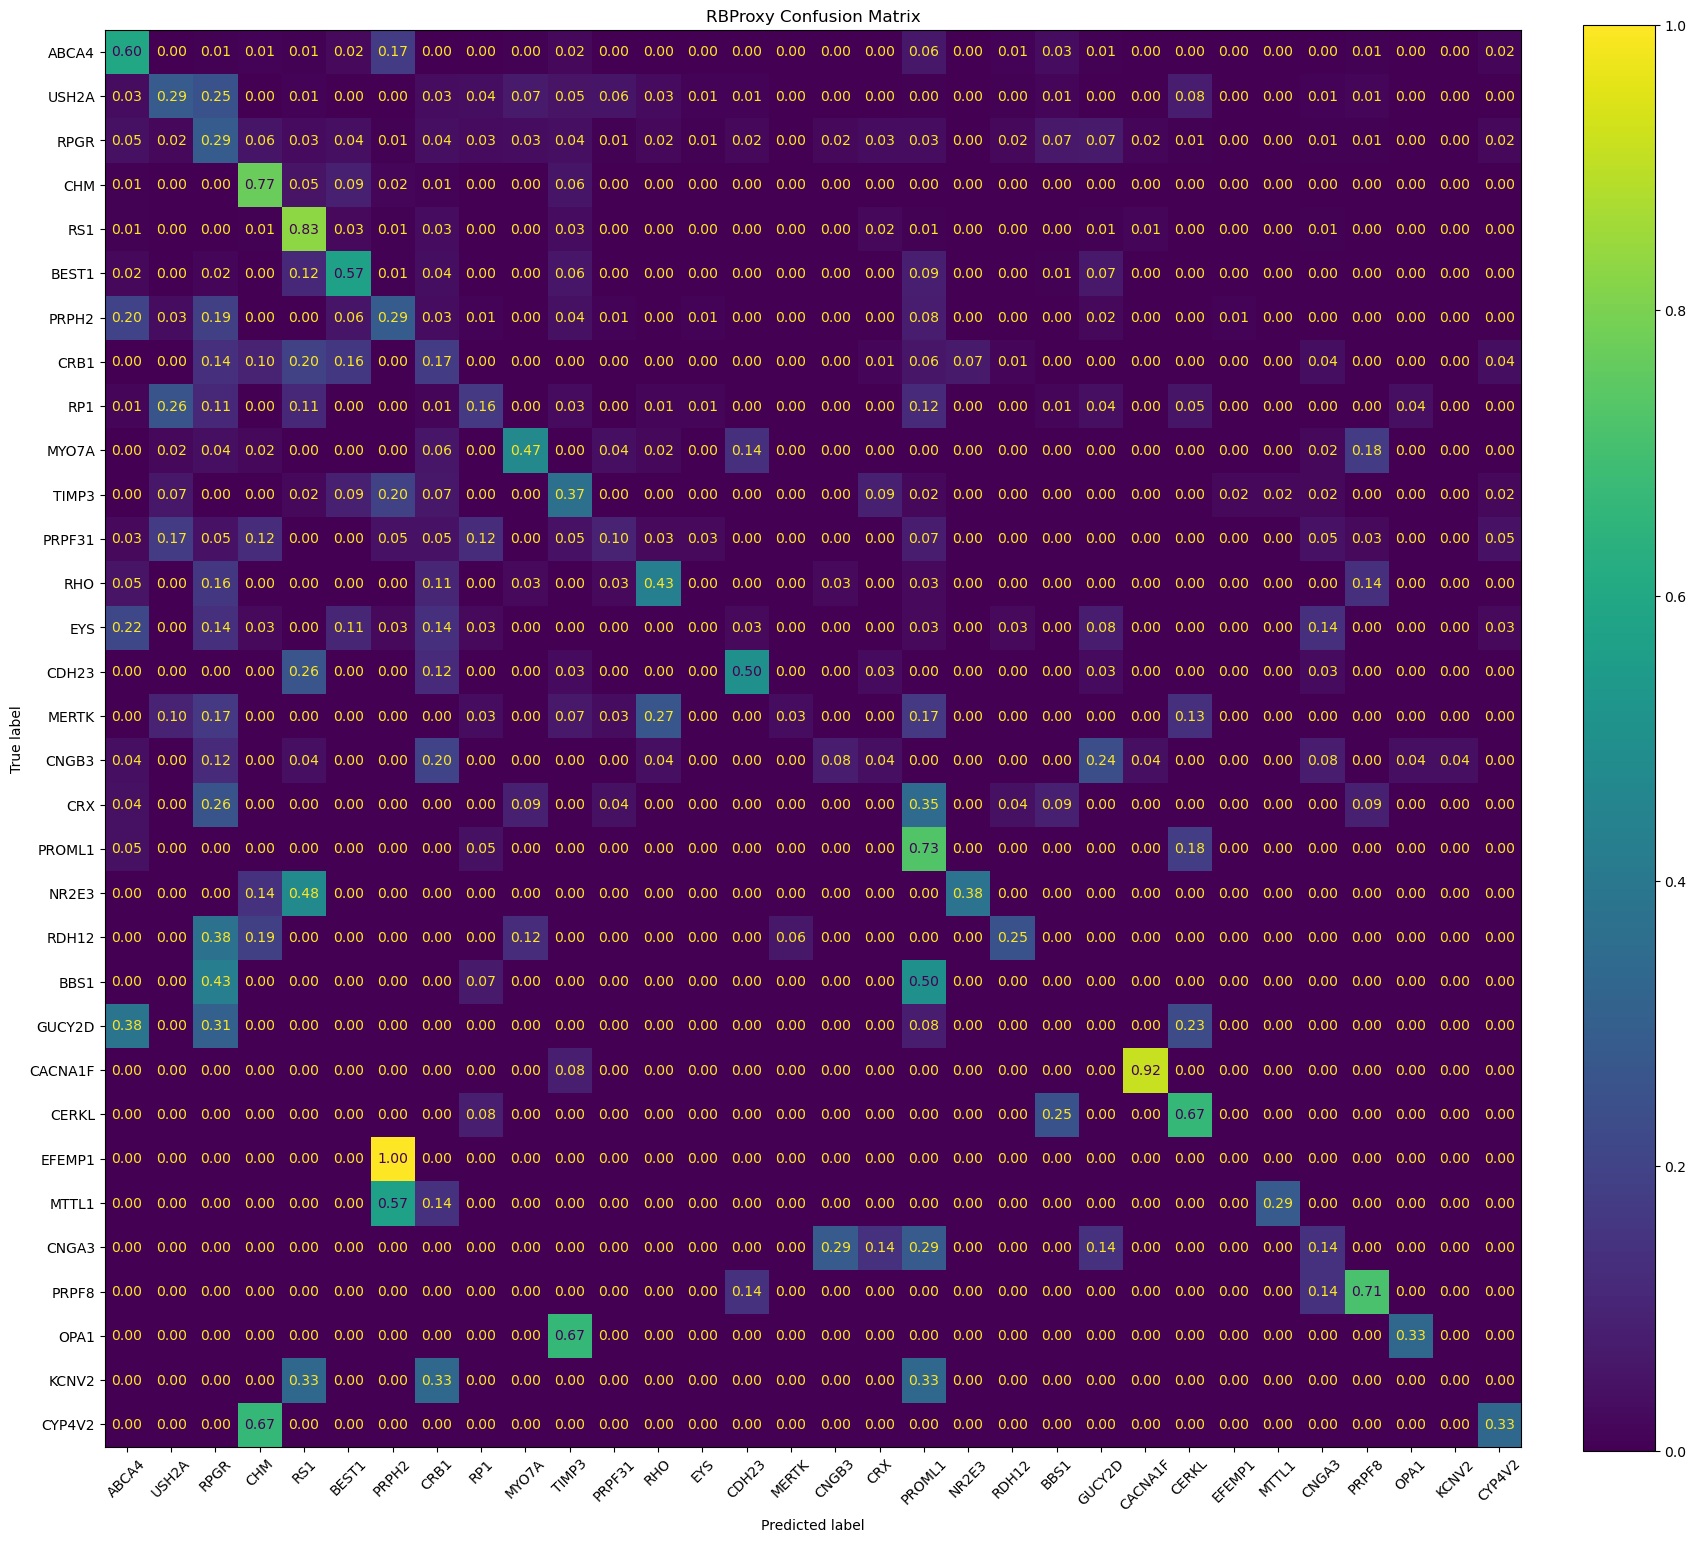

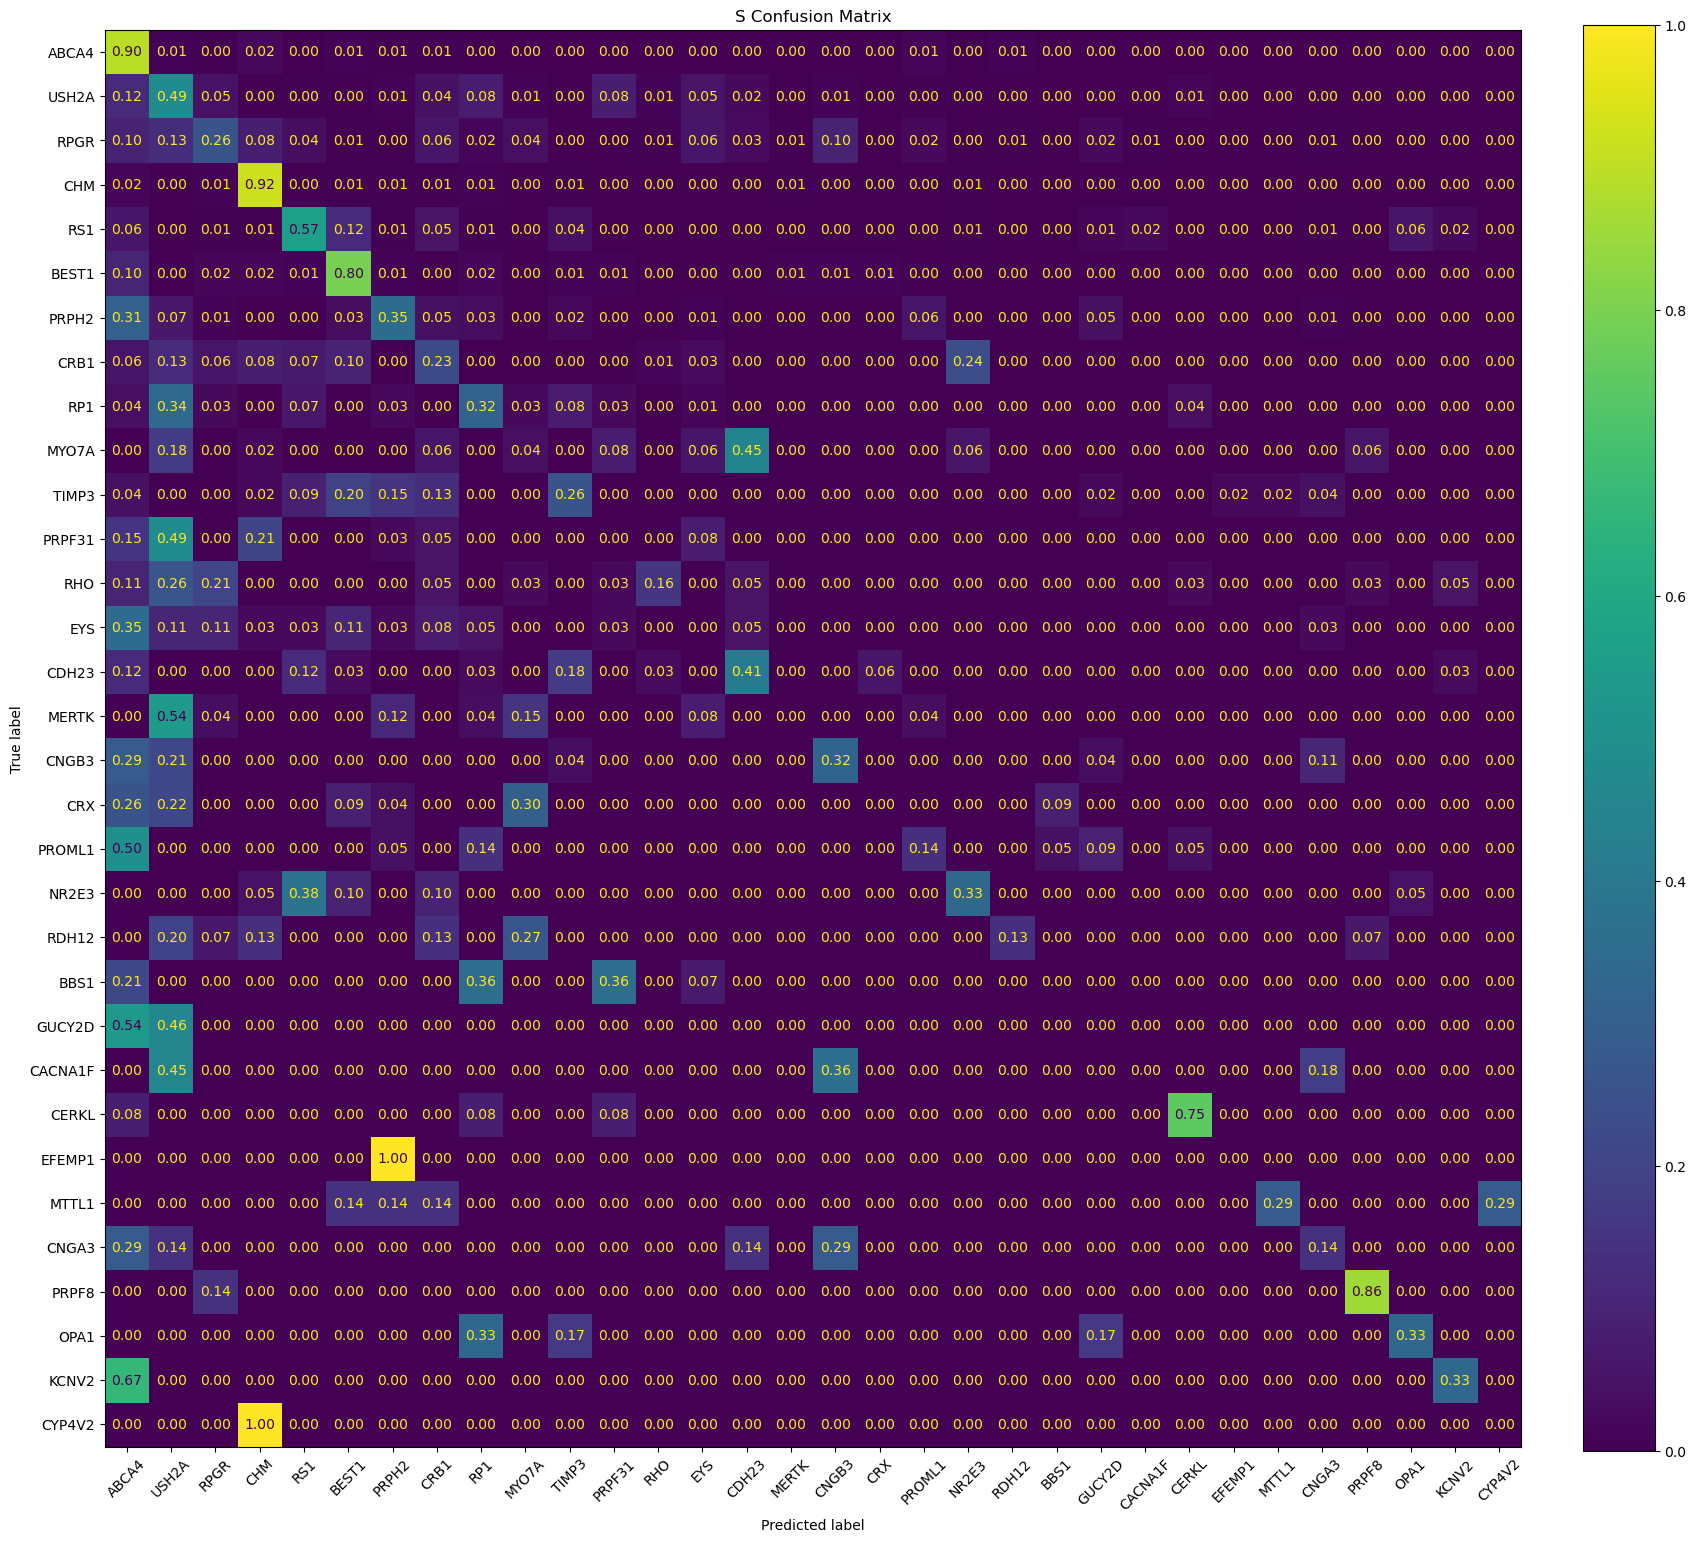

In [32]:
classes_ordering = list(preds_dict['R_r1']['True Class'].value_counts().keys()) 
cm_titles = [m.split('_')[0].upper() + ' ' + m.split('_')[1].upper() if '_' in m else m for m in preds_dict.keys()]
cm = {m: make_confusion_matrix(preds_dict[m], labels=classes_ordering, title=cm_titles[i] + ' Confusion Matrix', save=f'{m}_cm.tiff') for i, m in enumerate(preds_dict.keys())}

## Plot barplots of Predicted vs True Class Frequencies

In [ ]:
def make_barplot(cm, labels=None, title=None, normalize=True, order=None, save=None):
    ''' Plot barplots representing per-class prediction frequencies '''
    pred_freq = np.sum(cm, axis=0)
    true_freq = np.sum(cm, axis=1)
    
    if normalize:
        pred_freq = pred_freq / np.sum(pred_freq)
        true_freq = true_freq / np.sum(true_freq)
    
    pred_freq = pd.DataFrame(pred_freq, columns=['Frequency'])
    true_freq = pd.DataFrame(true_freq, columns=['Frequency'])
    pred_freq['Class'] = labels
    true_freq['Class'] = labels
    true_freq['Type'] = ['True']*len(true_freq)
    pred_freq['Type'] = ['Pred']*len(pred_freq)
    data = pd.concat([pred_freq, true_freq], axis=0)

    plt.figure(figsize=(12, 6))
    sns.barplot(data=data, x='Class', y='Frequency', hue='Type', order=order, hue_order=['True', 'Pred'])
    plt.xticks(rotation=45)
    plt.title(title)
    if save is not None:
        plt.savefig(save)
    plt.show()
    plt.close()

In [ ]:
classes_ordering = list(preds_dict['R_r1']['True Class'].value_counts().keys()) 
for m in cm.keys():
    title = m.split('_')[0].upper() + ' ' + m.split('_')[1].upper() if '_' in m else m
    make_barplot(cm[m], labels=classes, title='Predicted vs True Class Frequencies - ' + title, normalize=True, order=classes_ordering, save=f'{m}_frequencies.png')

## Visualize ROC curves

In [5]:
model_results = {}
classes_ordering = list(preds_dict['R_r1']['True Class'].value_counts().keys())
for m in preds_dict.keys():
#     cs = [cs for cs in classes if cs in preds_dict[m]['True Class'].unique()]
    auroc = AUROC(preds_dict[m], classes_ordering)
    model_results[m] = auroc(random_state=1399)

In [99]:
import sys, importlib
importlib.reload(sys.modules['utils'])
from utils import plot_roc, run_delong_test

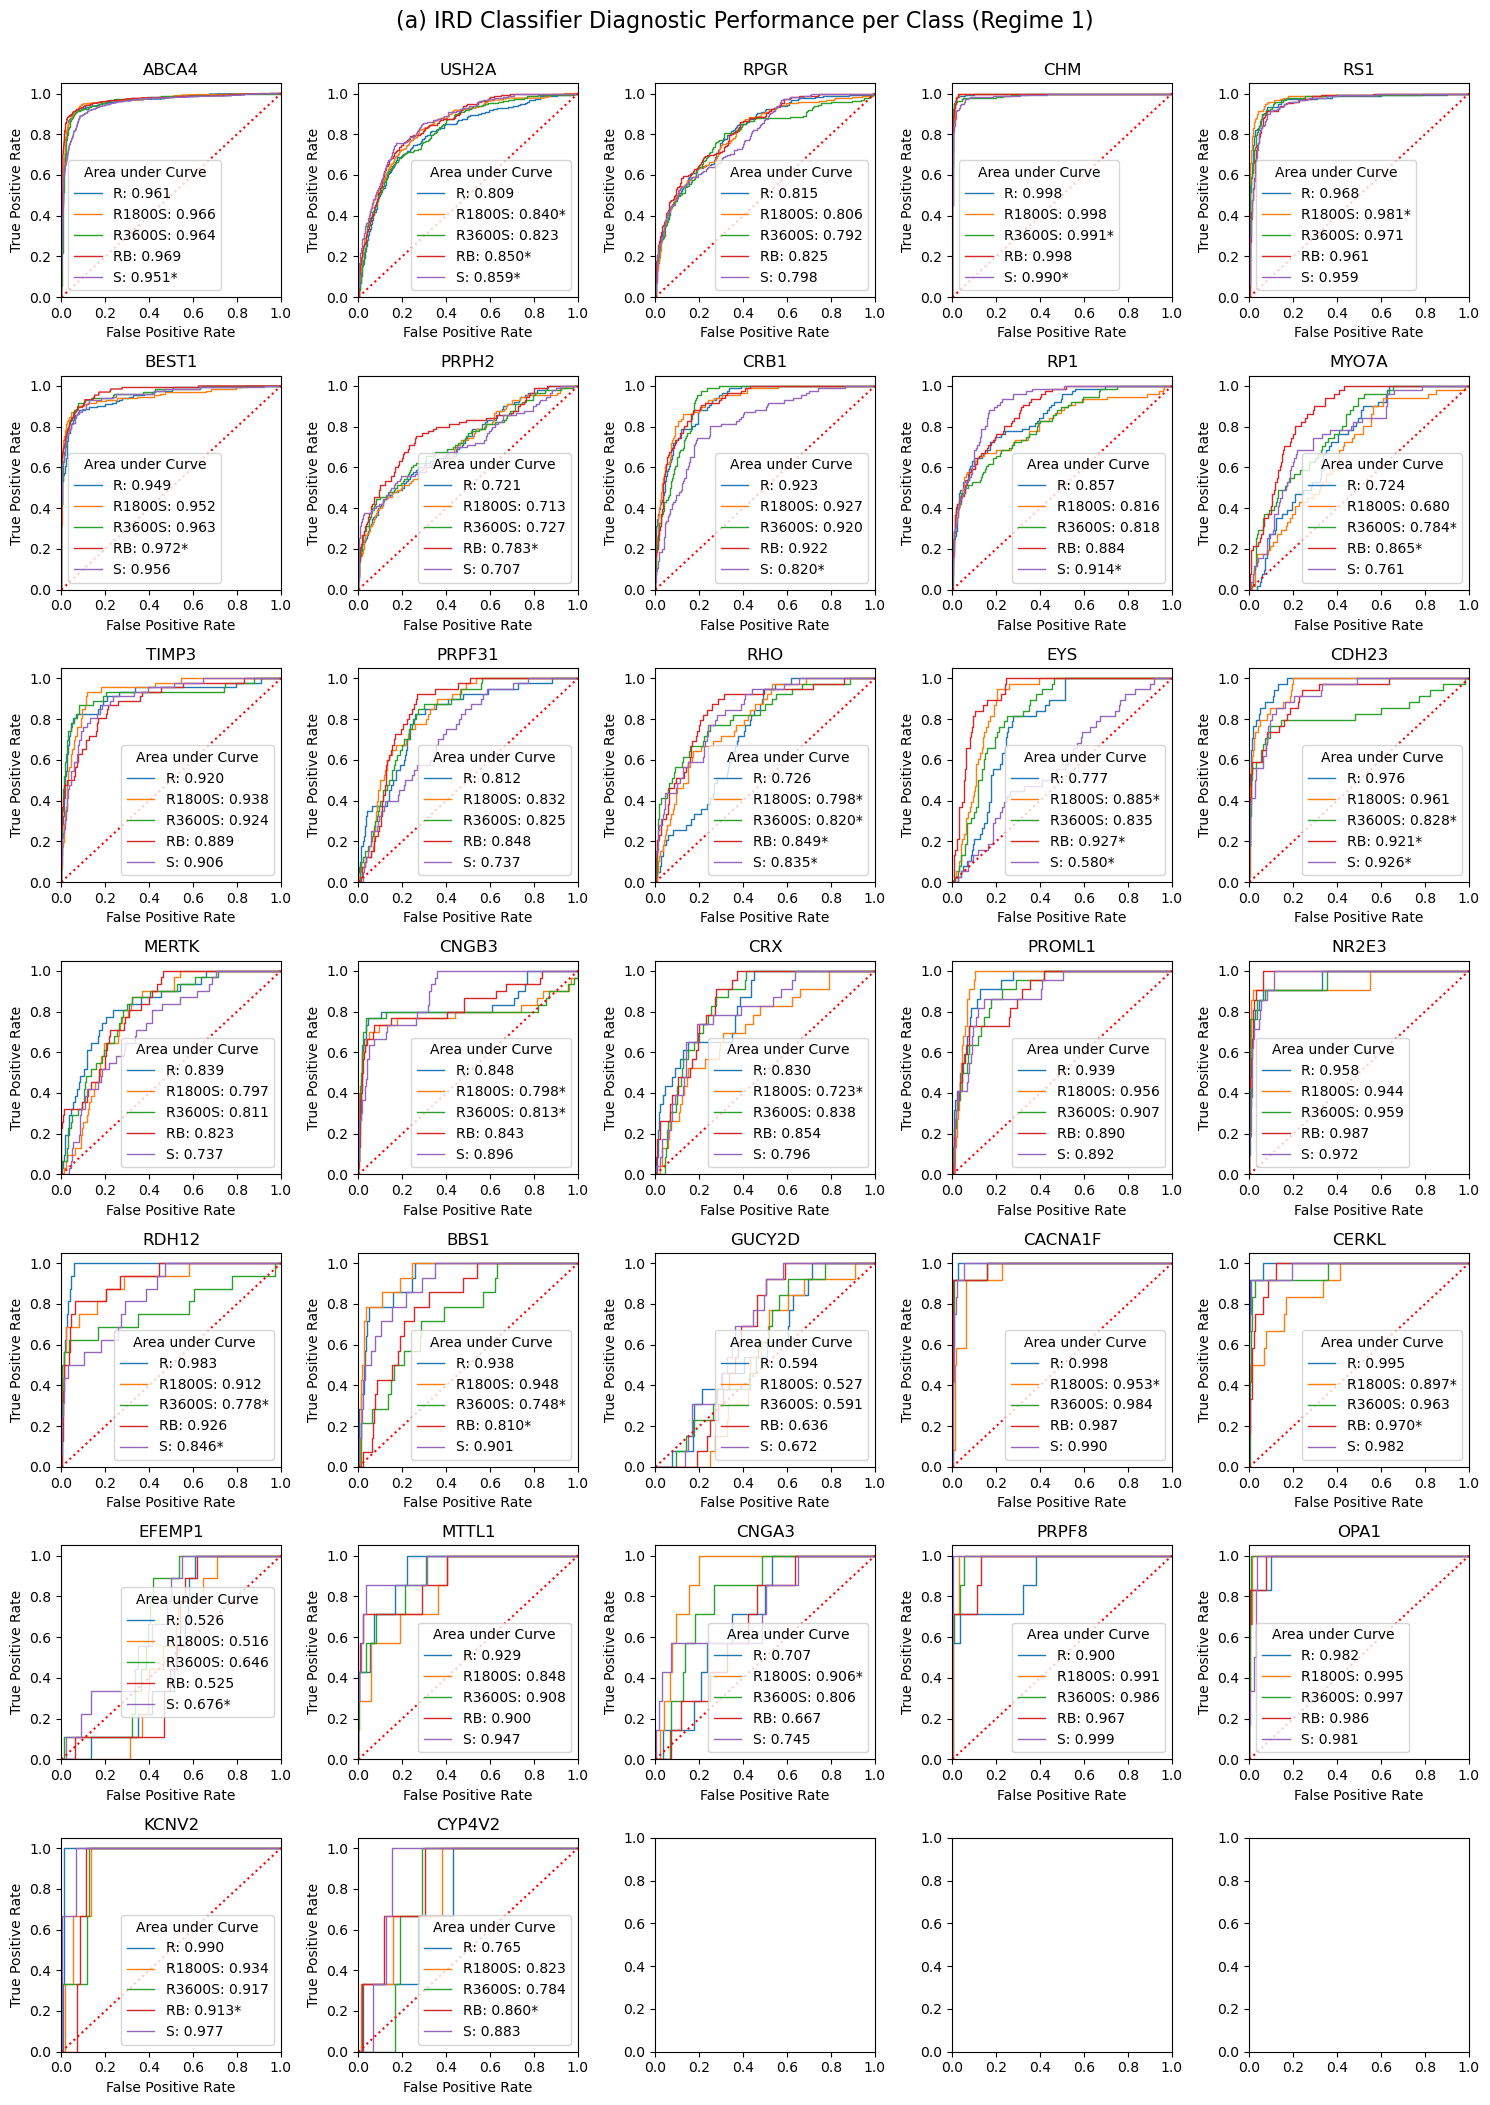

In [104]:
# plot roc regime 1 models
# labels = [cs for cs in classes if cs in preds_dict['R_r1']['True Class'].unique()]
labels = list(preds_dict['R_r1']['True Class'].value_counts().keys())
regime1_models = {k: preds_dict[k] for k in preds_dict.keys() if k.endswith('r1') or (k == 'S')}
plot_roc(7, 5, regime1_models, model_results, labels, '(a) IRD Classifier Diagnostic Performance per Class (Regime 1)', base='R_r1', save='../../figures/main/figure_7a.tiff')

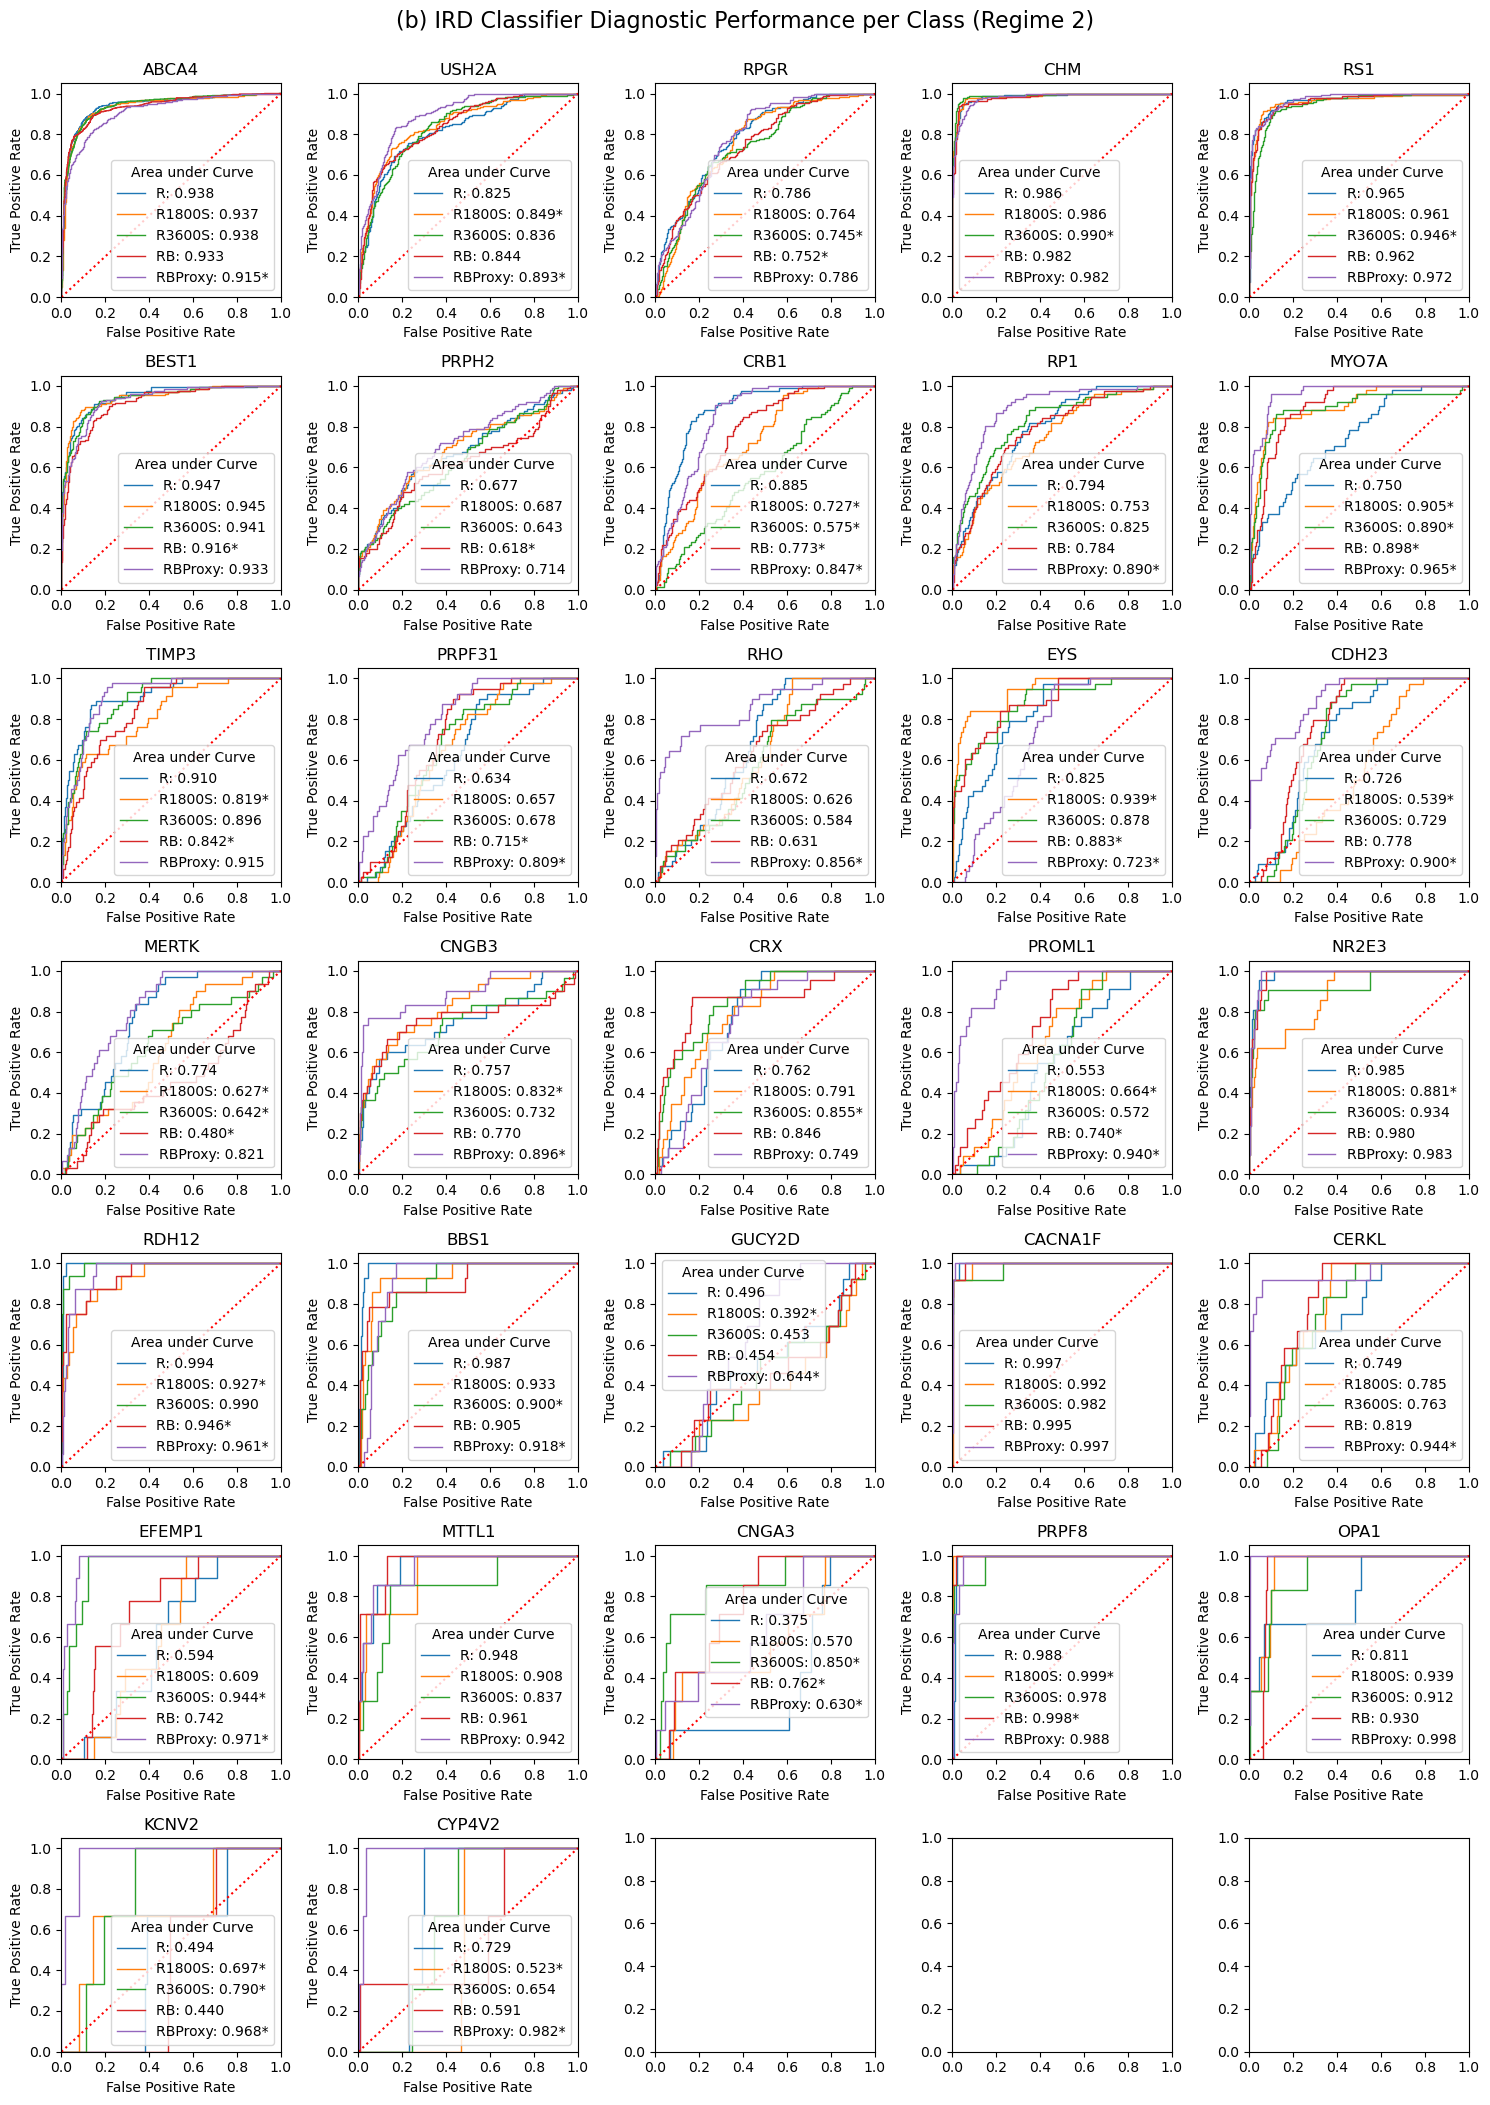

In [105]:
# plot roc regime 2 models
# labels = [cs for cs in classes if cs in preds_dict['R_r2']['True Class'].unique()]
labels = list(preds_dict['R_r1']['True Class'].value_counts().keys())
regime2_models = {k: preds_dict[k] for k in preds_dict.keys() if k.endswith('r2') or (k == 'RBProxy')}
plot_roc(7, 5, regime2_models, model_results, labels, '(b) IRD Classifier Diagnostic Performance per Class (Regime 2)', base='R_r2', save='../../figures/main/figure_7b.tiff')

## Create summary table of AUCs per class

In [55]:
# create df of aucs for each model
aucs_per_model_full_df = pd.DataFrame(columns=['Class', *model_results.keys()])
for m in model_results.keys():
    aucs_df = model_results[m][0]
    aucs_per_model_full_df[m] = aucs_df['auroc']
aucs_per_model_full_df['Class'] = aucs_df['Class']
aucs_per_model_full_df

Class      R_r1  R1800S_r1  R3600S_r1     RB_r1      R_r2  R1800S_r2  \
0     ABCA4  0.961144   0.965577   0.963800  0.968688  0.938388   0.936546   
1     USH2A  0.808794   0.839767   0.823205  0.849735  0.824951   0.848595   
2      RPGR  0.814970   0.806166   0.792491  0.825316  0.785918   0.763617   
3       CHM  0.997801   0.997588   0.991351  0.998219  0.985730   0.986061   
4       RS1  0.967805   0.981109   0.970764  0.961432  0.964990   0.961265   
5     BEST1  0.949408   0.951911   0.963277  0.971951  0.947478   0.944710   
6     PRPH2  0.721359   0.712826   0.726546  0.783094  0.677073   0.687274   
7      CRB1  0.922539   0.927236   0.920270  0.921840  0.884597   0.727151   
8       RP1  0.857092   0.816160   0.818389  0.883714  0.794263   0.753046   
9     MYO7A  0.723966   0.679805   0.784403  0.864537  0.749524   0.904923   
10    TIMP3  0.919652   0.938308   0.923714  0.889257  0.910443   0.818942   
11   PRPF31  0.811827   0.832013   0.825471  0.848481  0.634386   0.656591   
12      RHO  0.726414   0.798031   0.819875  0.848820  0.672412   0.625723   
13      EYS  0.777050   0.884747   0.834799  0.927161  0.824939   0.939152   
14    CDH23  0.975720   0.960909   0.828453  0.920701  0.725626   0.539071   
15    MERTK  0.839215   0.796626   0.811027  0.822982  0.774250   0.626752   
16    CNGB3  0.848049   0.798011   0.813167  0.843301  0.757461   0.832221   
17      CRX  0.829577   0.722534   0.838026  0.854472  0.762203   0.790889   
18   PROML1  0.939098   0.956122   0.907124  0.889808  0.553455   0.664058   
19    NR2E3  0.957968   0.944376   0.958967  0.987300  0.985043   0.881130   
20    RDH12  0.983221   0.911820   0.777578  0.926140  0.993763   0.927054   
21     BBS1  0.938103   0.947710   0.747789  0.809837  0.987114   0.933226   
22   GUCY2D  0.594144   0.526554   0.591066  0.635588  0.496385   0.391693   
23  CACNA1F  0.997922   0.953224   0.984343  0.986901  0.997354   0.991743   
24    CERKL  0.994633   0.897063   0.962712  0.970060  0.749103   0.785208   
25   EFEMP1  0.525821   0.515960   0.646065  0.524706  0.594481   0.609192   
26    MTTL1  0.928591   0.848445   0.907625  0.899515  0.948172   0.908421   
27    CNGA3  0.706891   0.905710   0.805837  0.666744  0.375245   0.569667   
28    PRPF8  0.899557   0.990758   0.986425  0.967440  0.988187   0.998676   
29     OPA1  0.982160   0.995241   0.997295  0.986249  0.811142   0.938508   
30    KCNV2  0.989743   0.933926   0.917017  0.912778  0.494042   0.697238   
31   CYP4V2  0.764647   0.822833   0.784447  0.859656  0.728547   0.522884   

    R3600S_r2     RB_r2   RBProxy         S  
0    0.937645  0.933461  0.914937  0.950756  
1    0.835720  0.844015  0.892532  0.858564  
2    0.744891  0.752101  0.786307  0.797729  
3    0.989973  0.982228  0.981537  0.989617  
4    0.946013  0.962123  0.972418  0.959493  
5    0.940885  0.915572  0.933323  0.956275  
6    0.643305  0.618414  0.714288  0.707247  
7    0.574500  0.772589  0.847365  0.819575  
8    0.825124  0.783855  0.890498  0.914198  
9    0.890020  0.897902  0.964785  0.760647  
10   0.896368  0.842293  0.914811  0.906459  
11   0.678244  0.715424  0.809187  0.737240  
12   0.584475  0.631411  0.856125  0.834873  
13   0.877606  0.882515  0.723128  0.580429  
14   0.729074  0.778409  0.900257  0.925844  
15   0.642108  0.480360  0.820677  0.736841  
16   0.731989  0.769586  0.895603  0.895823  
17   0.854612  0.846179  0.748676  0.795891  
18   0.571919  0.739917  0.940480  0.892109  
19   0.933959  0.979545  0.983479  0.972333  
20   0.990061  0.945775  0.961473  0.845537  
21   0.899795  0.905198  0.918034  0.901030  
22   0.452772  0.454241  0.644366  0.671563  
23   0.981842  0.995220  0.997214  0.989802  
24   0.762719  0.818680  0.943820  0.982332  
25   0.944111  0.741618  0.970961  0.676412  
26   0.837437  0.961236  0.942325  0.946683  
27   0.850070  0.762038  0.629725  0.744845  
28   0.978126  0.997965  0.988012  0.998882  
29   0.912164  0.930270  0.997919  0.980900  
30   

In [ ]:
# aucs_per_model = aucs_per_model.rename(columns={'RB2': 'RBProxy'})
# aucs_per_model.to_csv('model_aucs.csv')

In [34]:
def wilcoxon_test(sample1, sample2):
    from scipy.stats import wilcoxon
    stat, pval = wilcoxon(sample1, sample2)
    return (stat, pval)

In [35]:
wilcoxon_test(aucs_per_model['R_r1'], aucs_per_model['R1800S_r1'])

(233.0, 0.5621391110725872)

In [36]:
wilcoxon_test(aucs_per_model['R_r1'], aucs_per_model['R3600S_r1'])

(252.0, 0.8224559693191273)

In [37]:
wilcoxon_test(aucs_per_model['R_r1'], aucs_per_model['RB_r1'])

(224.0, 0.45448573750615706)

In [38]:
wilcoxon_test(aucs_per_model['R_r2'], aucs_per_model['R1800S_r2'])

(246.0, 0.7364328441559214)

In [39]:
wilcoxon_test(aucs_per_model['R_r2'], aucs_per_model['R3600S_r2'])

(253.0, 0.8370343688651636)

In [40]:
wilcoxon_test(aucs_per_model['R_r2'], aucs_per_model['RB_r2'])

(249.0, 0.7791061247608694)

In [41]:
wilcoxon_test(aucs_per_model['R_r2'], aucs_per_model['RBProxy'])

(111.0, 0.00422389926927937)

In [42]:
wilcoxon_test(aucs_per_model['R_r1'], aucs_per_model['S'])

(256.0, 0.8810869002194571)

# Analyse test set with one image per patient

In [43]:
# selects only one image per patient
def one_image_per_patient(df):
    np.random.seed(1399)
    new_df = pd.DataFrame(columns=df.columns)
    for pat, pat_df in df.groupby('patient.number'):
        random_pat = pat_df.sample()
        new_df = pd.concat([new_df, random_pat], axis=0, ignore_index=True)
    return new_df

In [48]:
# get predictions for all trained models
all_csvs = [path for path in os.listdir('.') if path.endswith('.csv')]
model_dfs = [get_predictions(m + '.csv', classes=pandas_query, apply=one_image_per_patient) for m in model_names]
preds_dict_one_pat = {k: v for k, v in zip(model_names, model_dfs)}

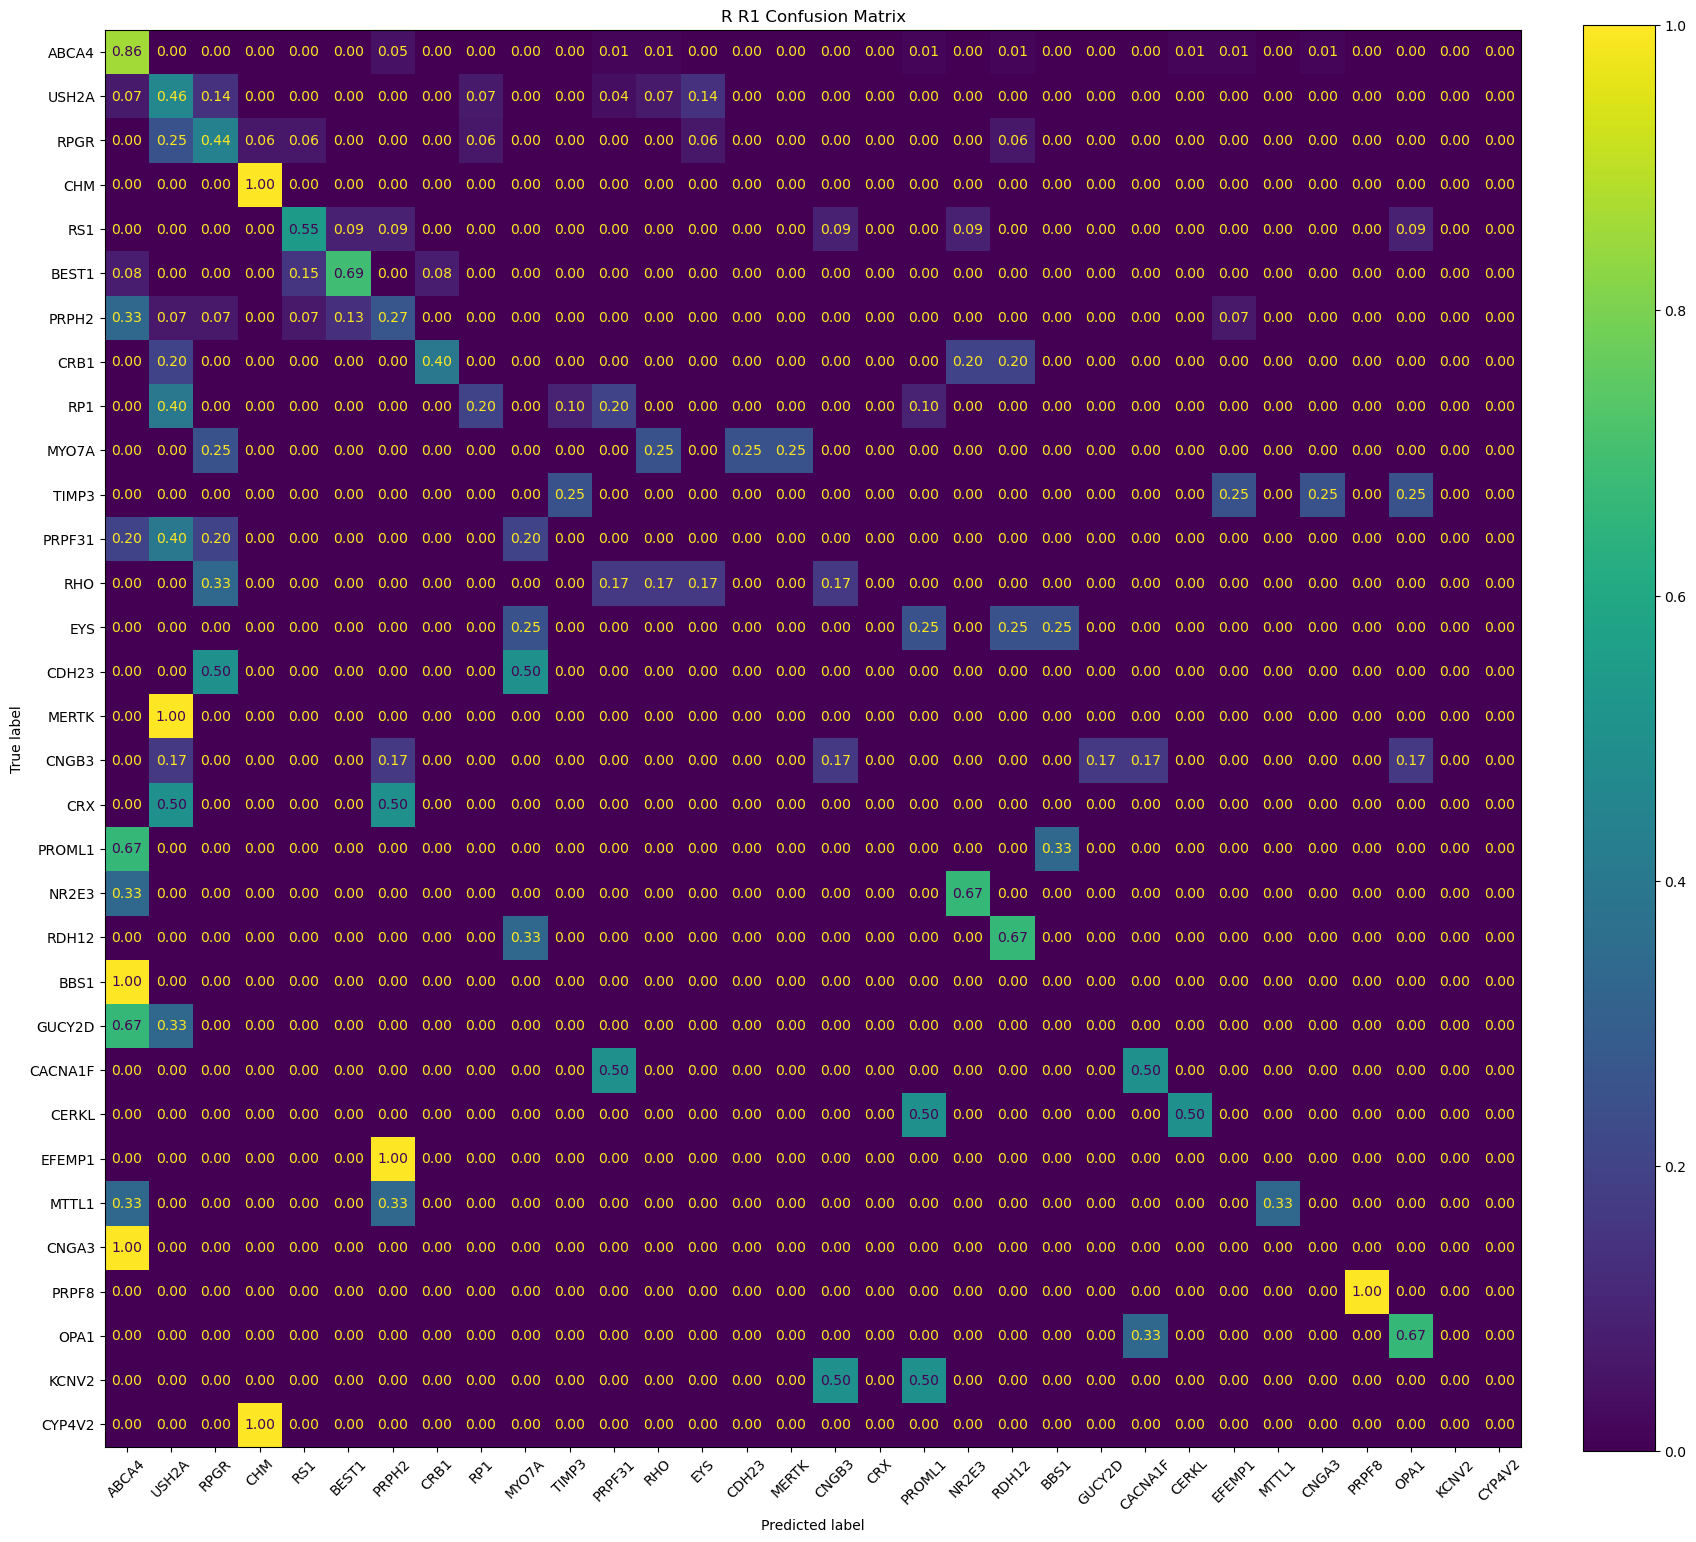

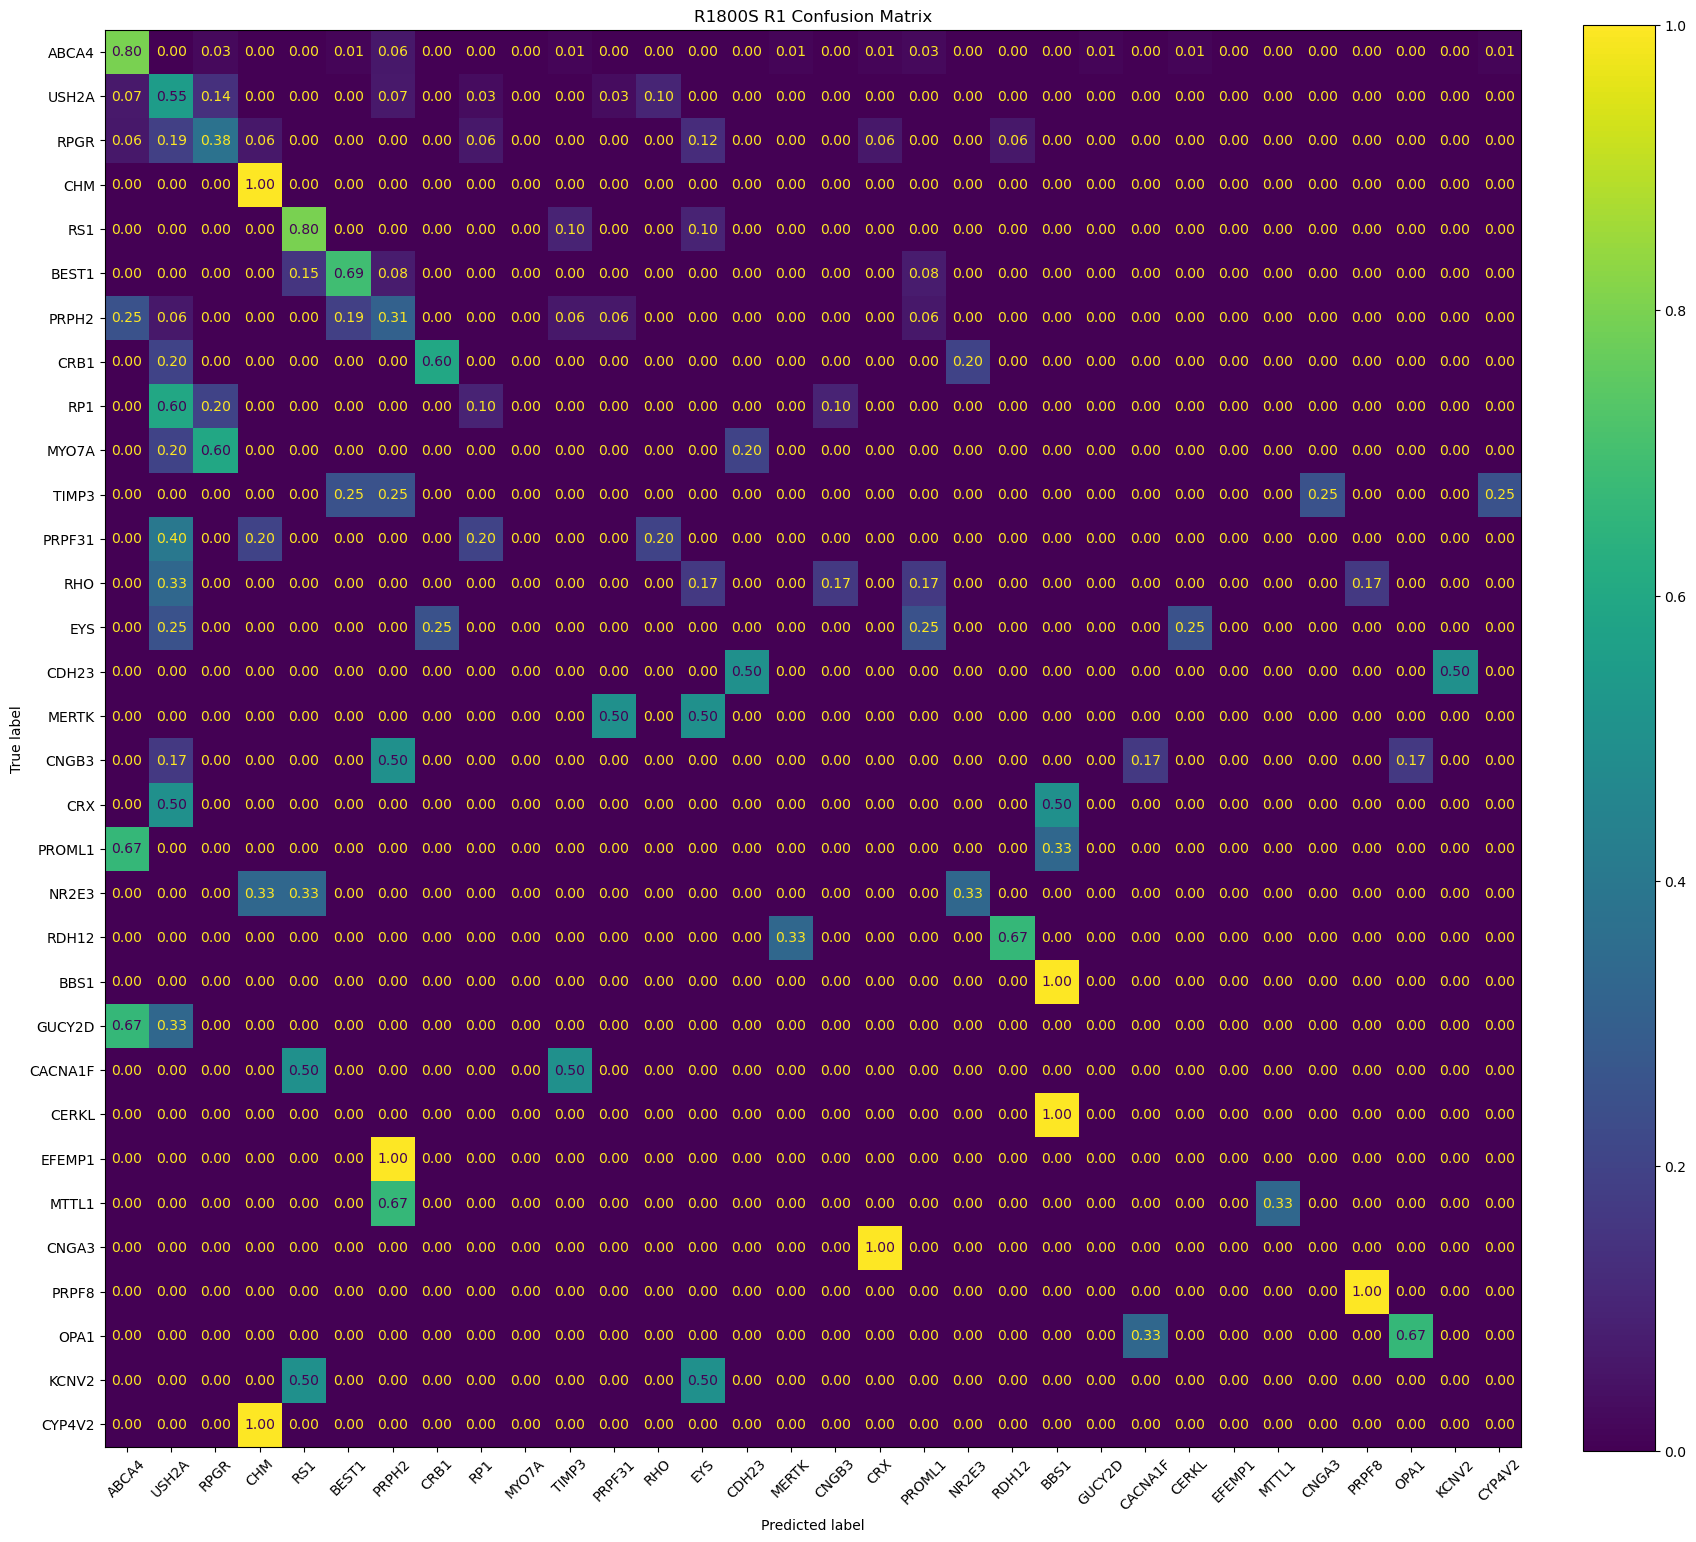

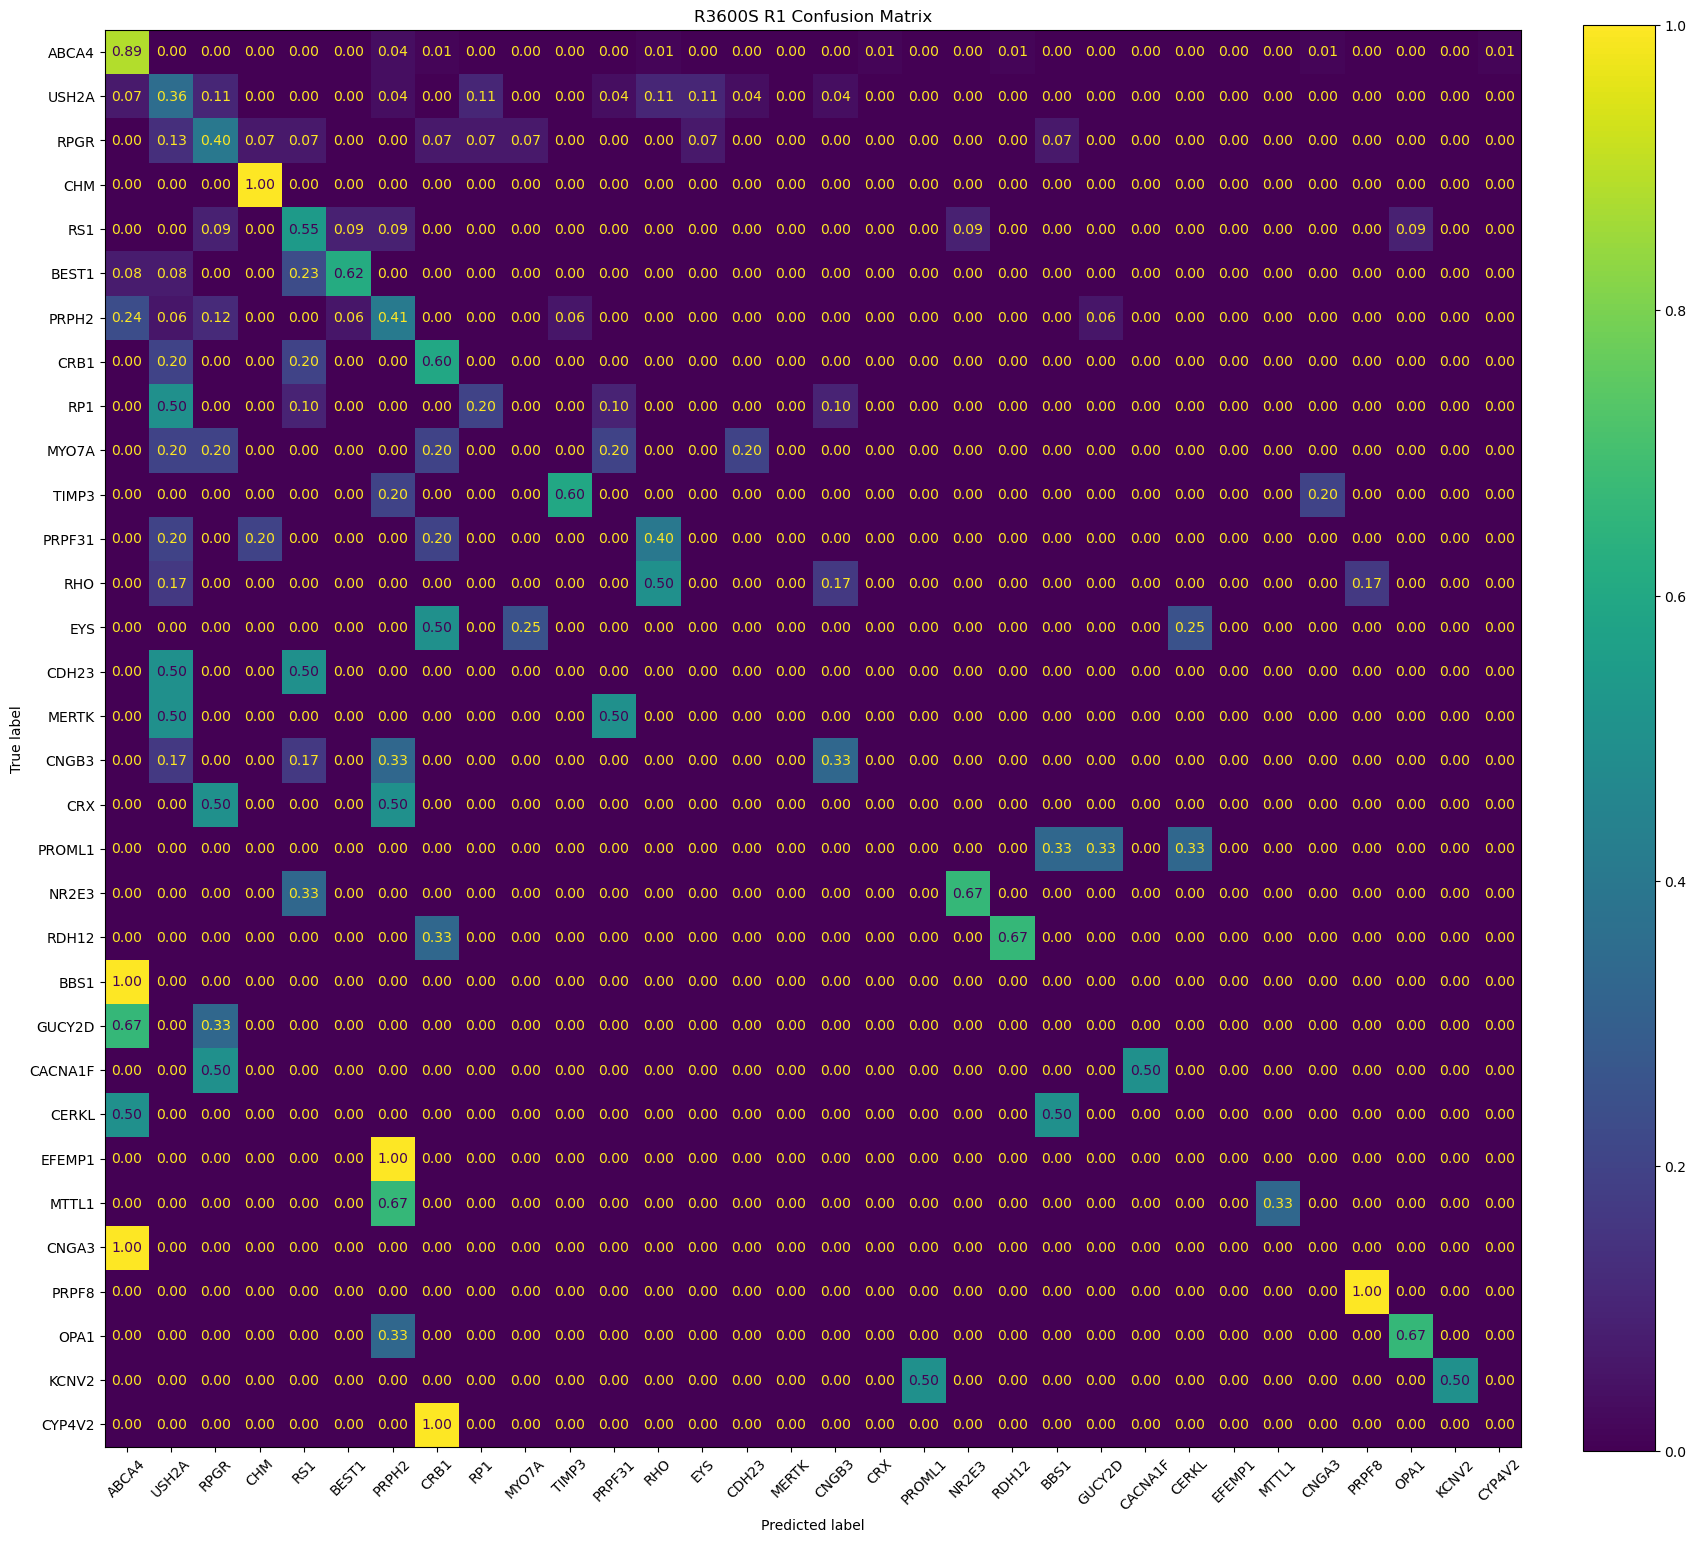

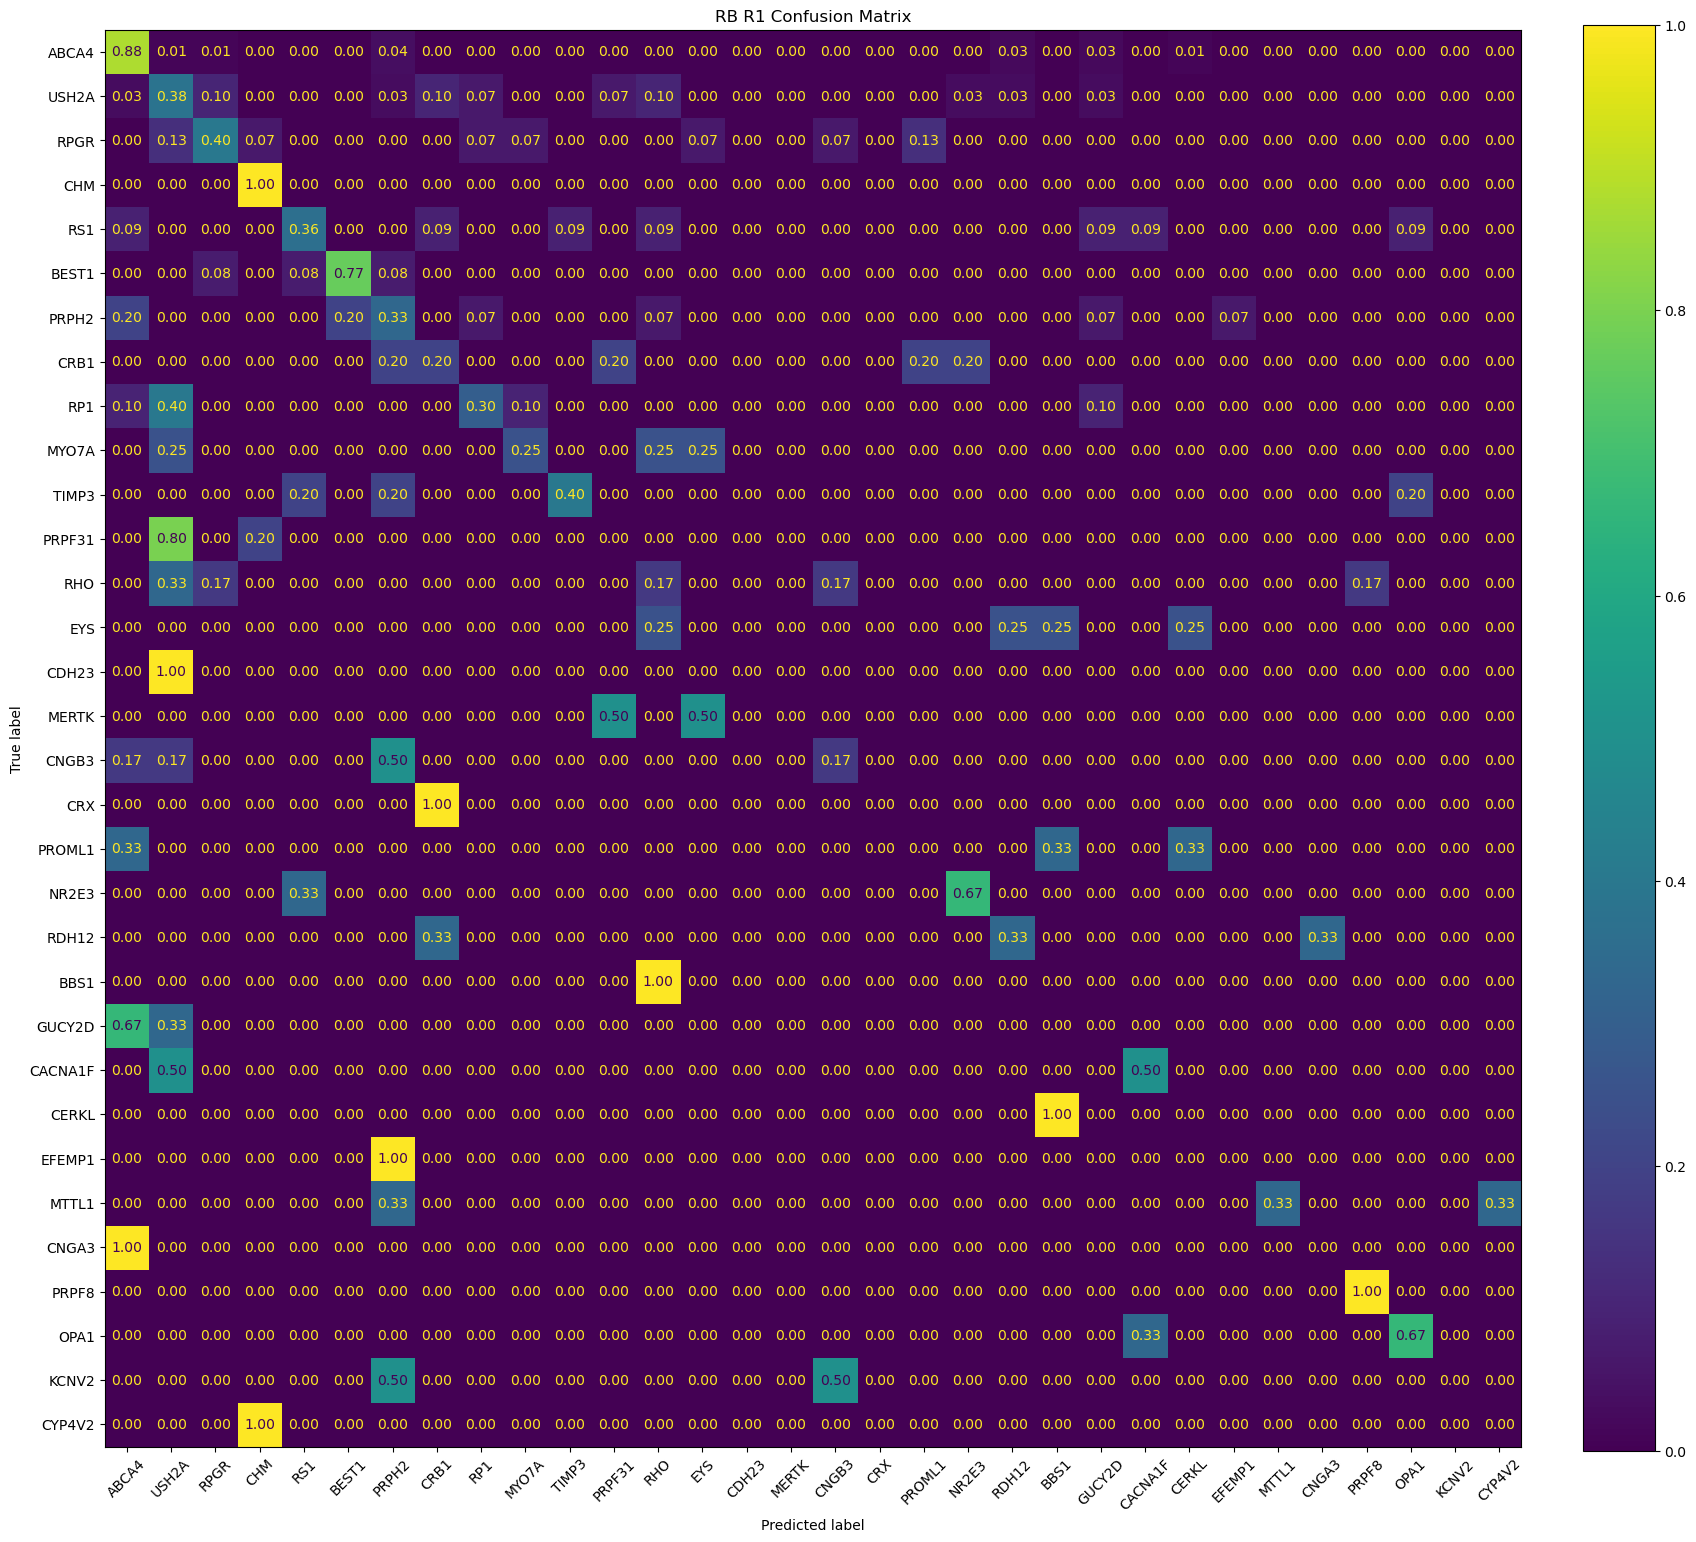

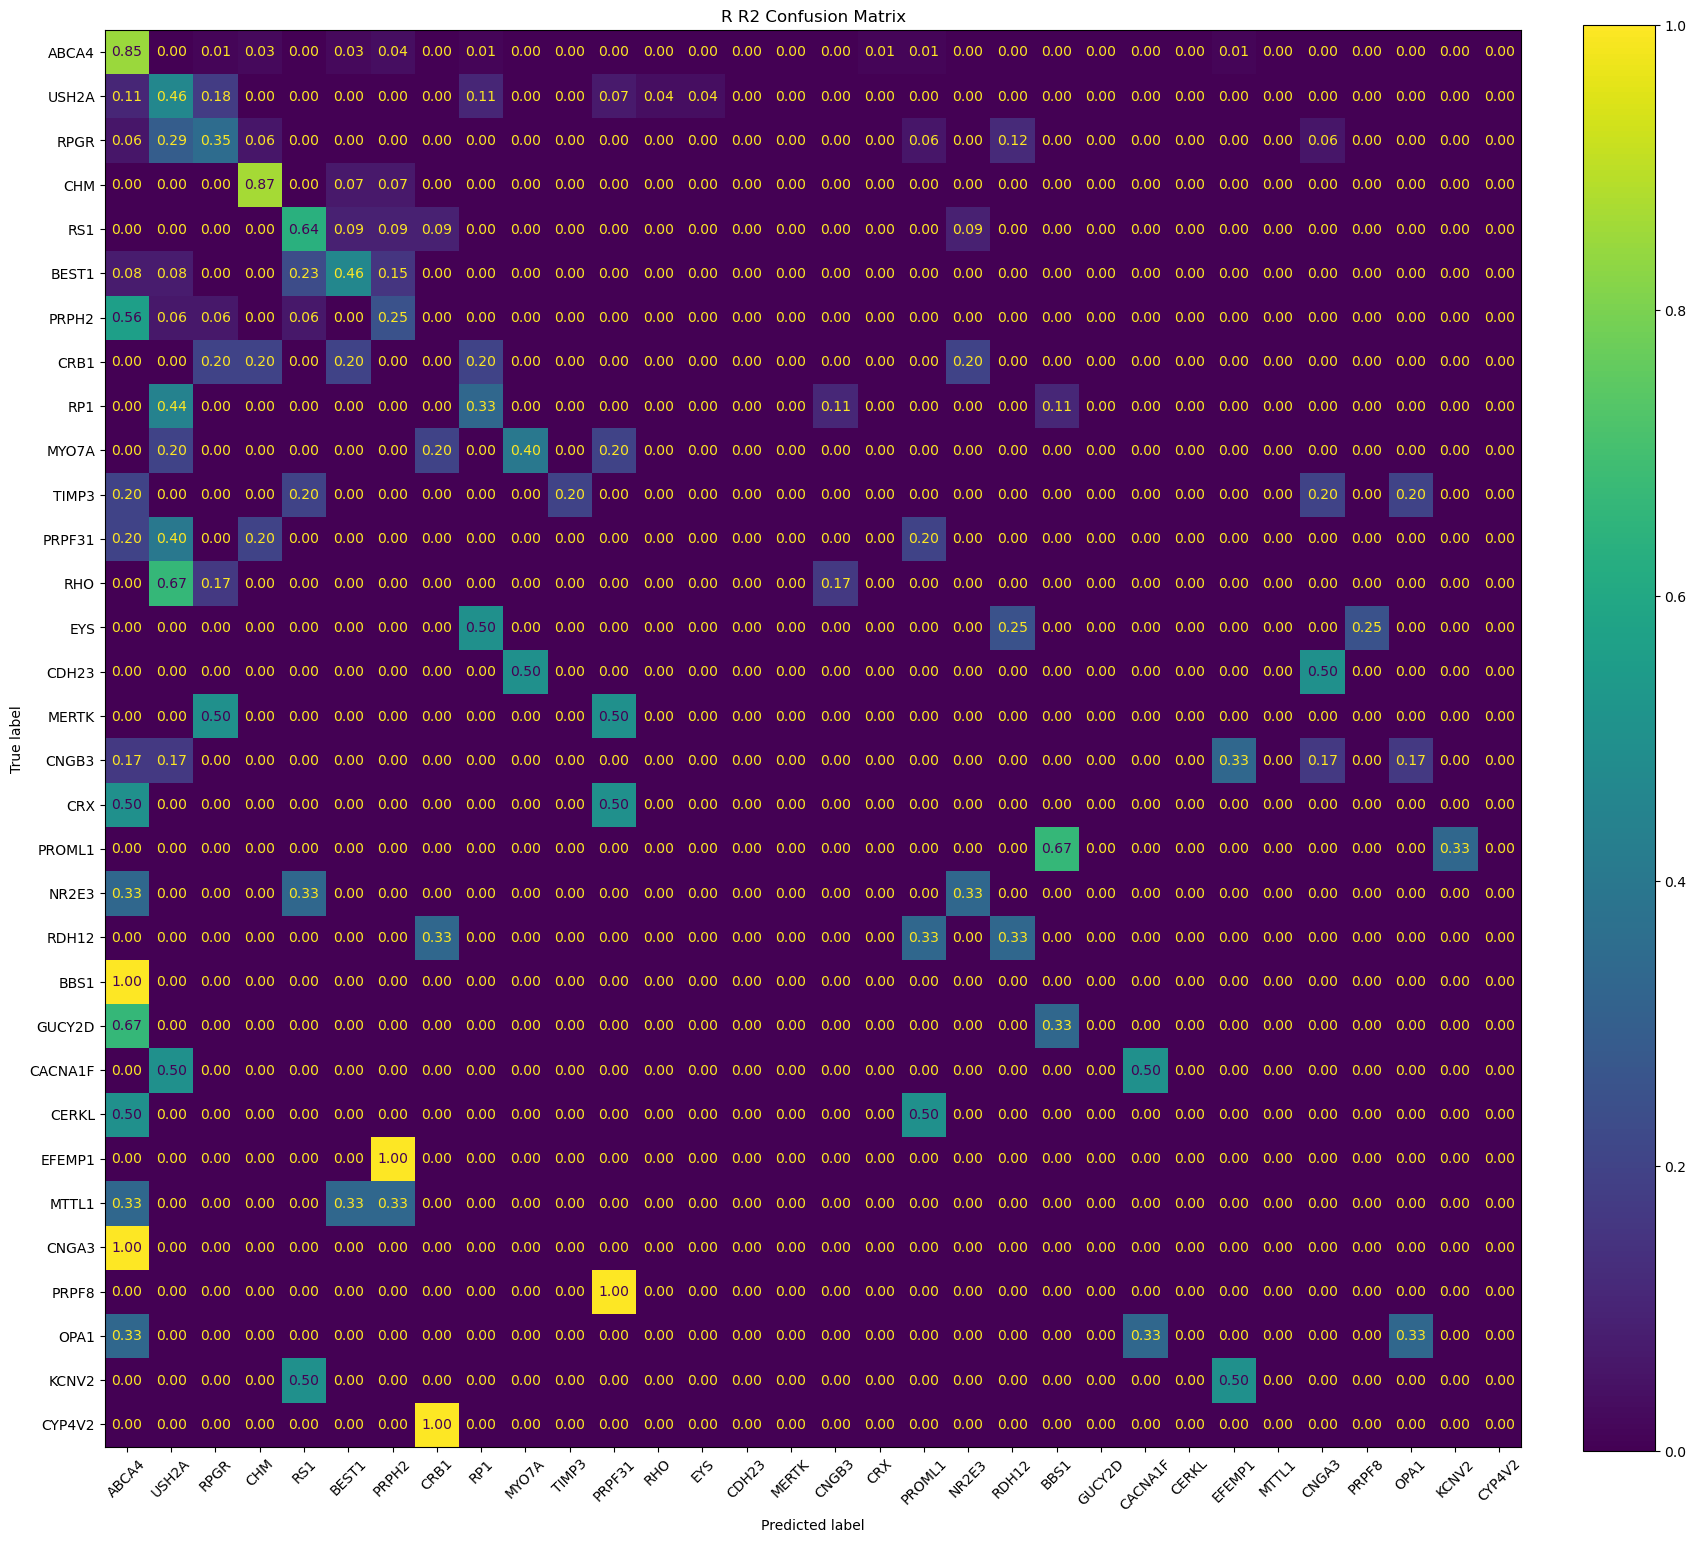

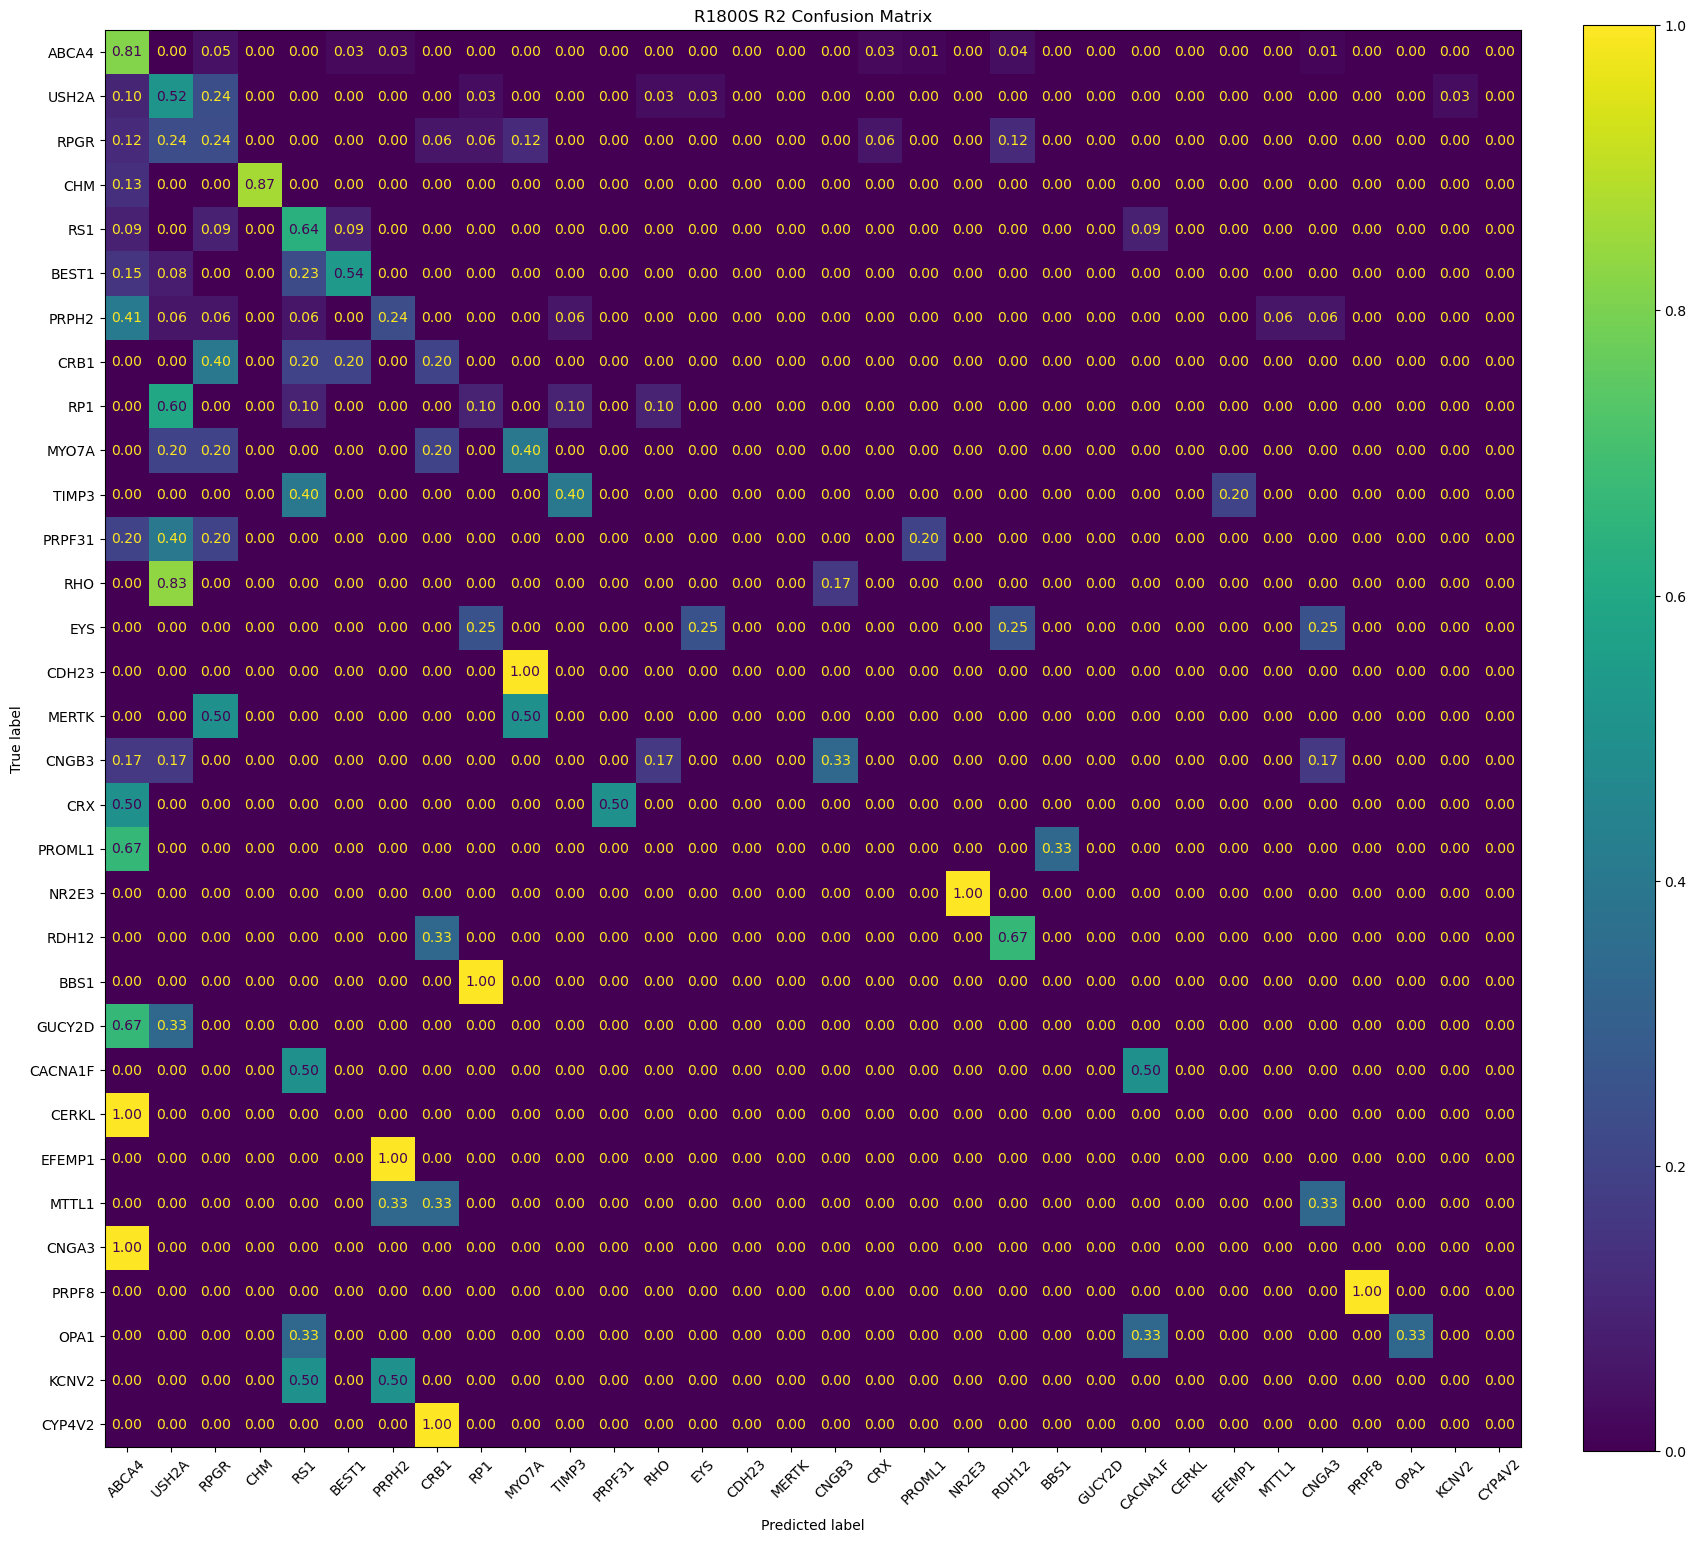

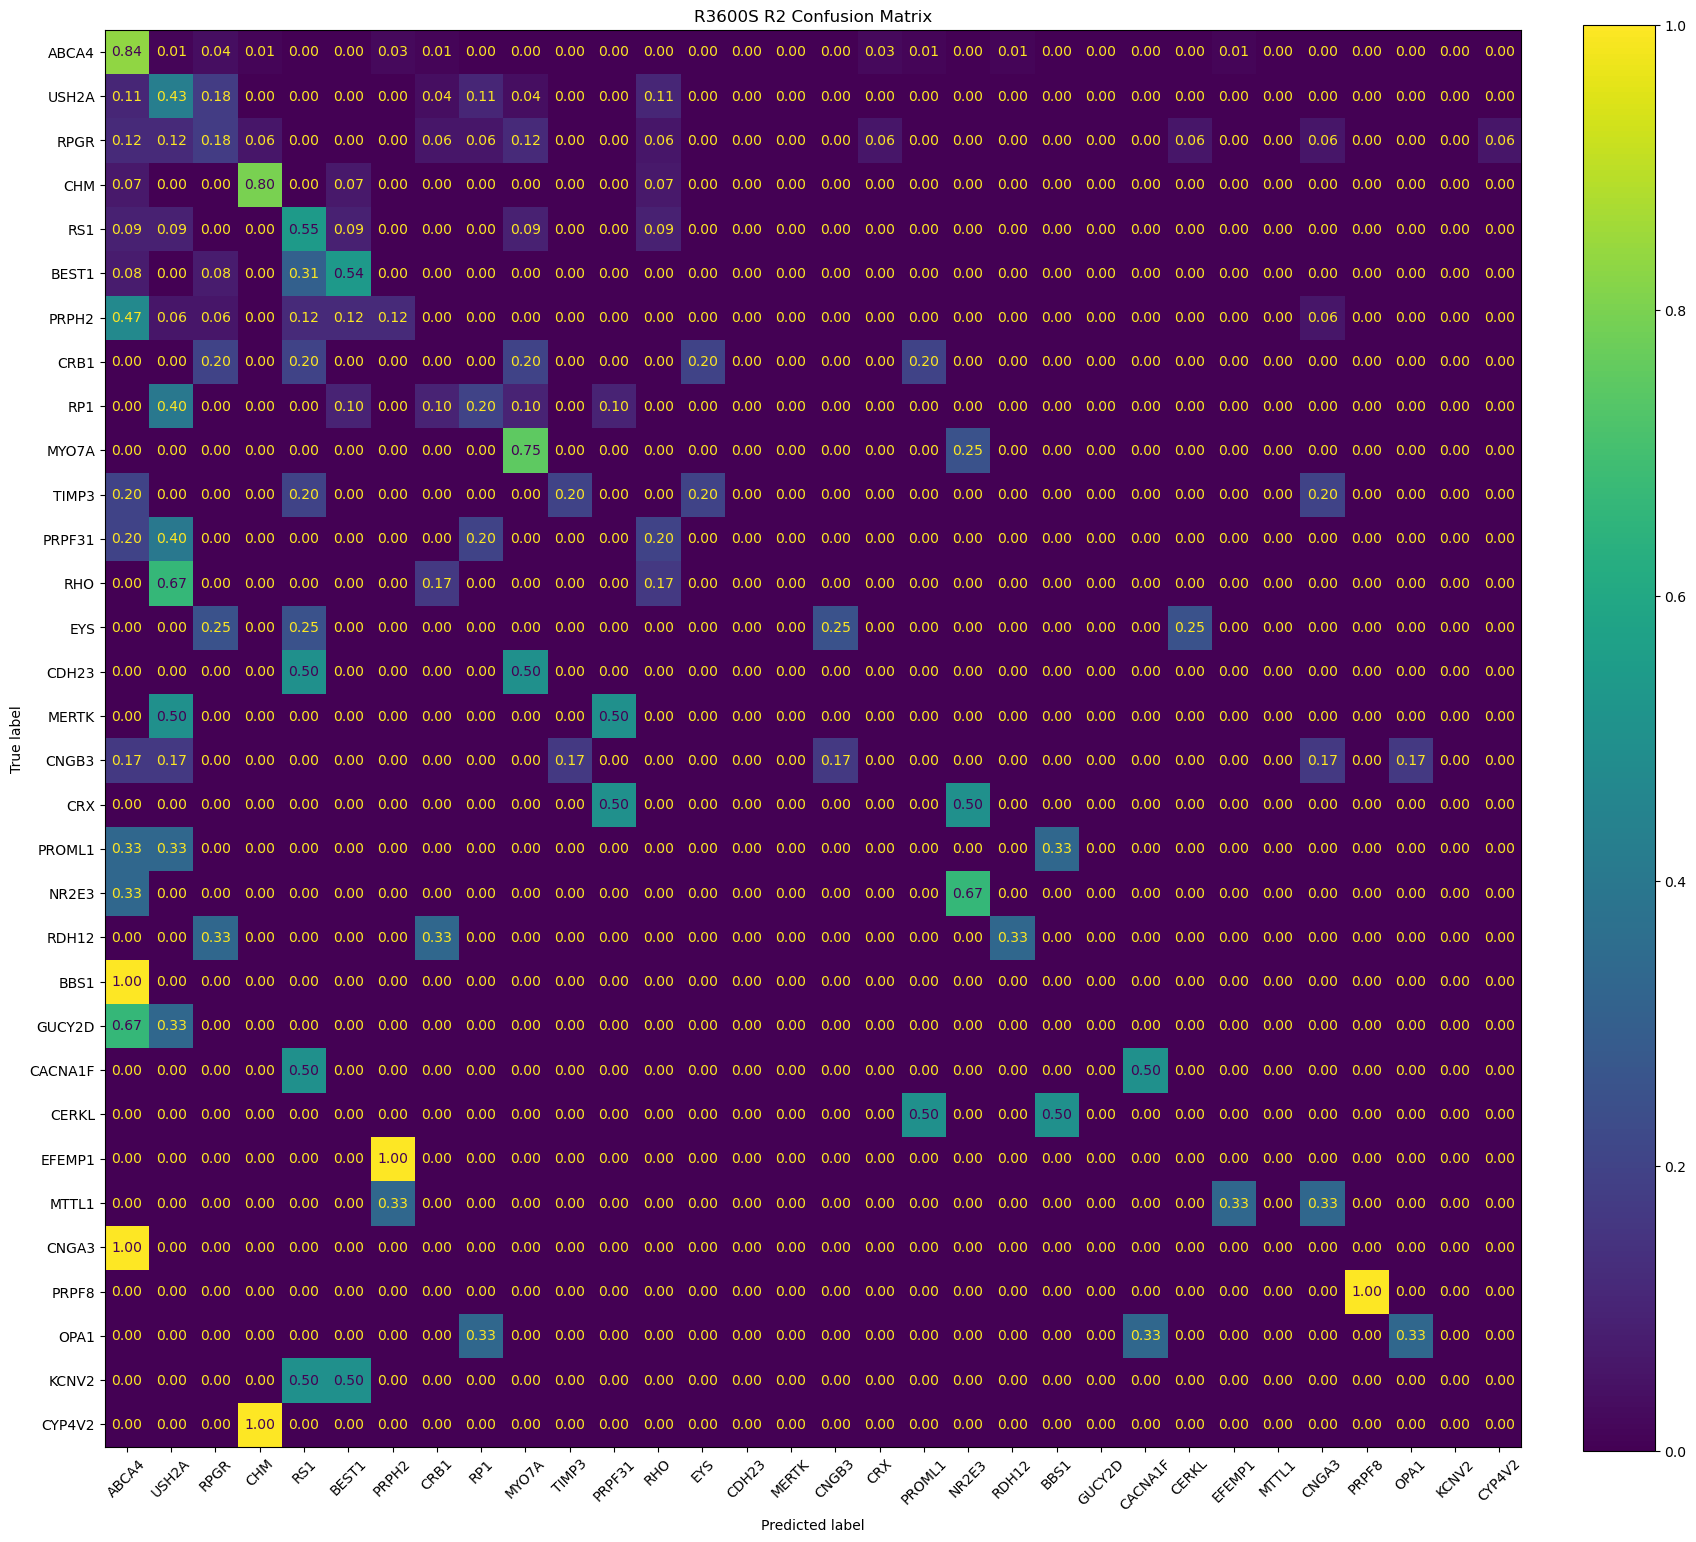

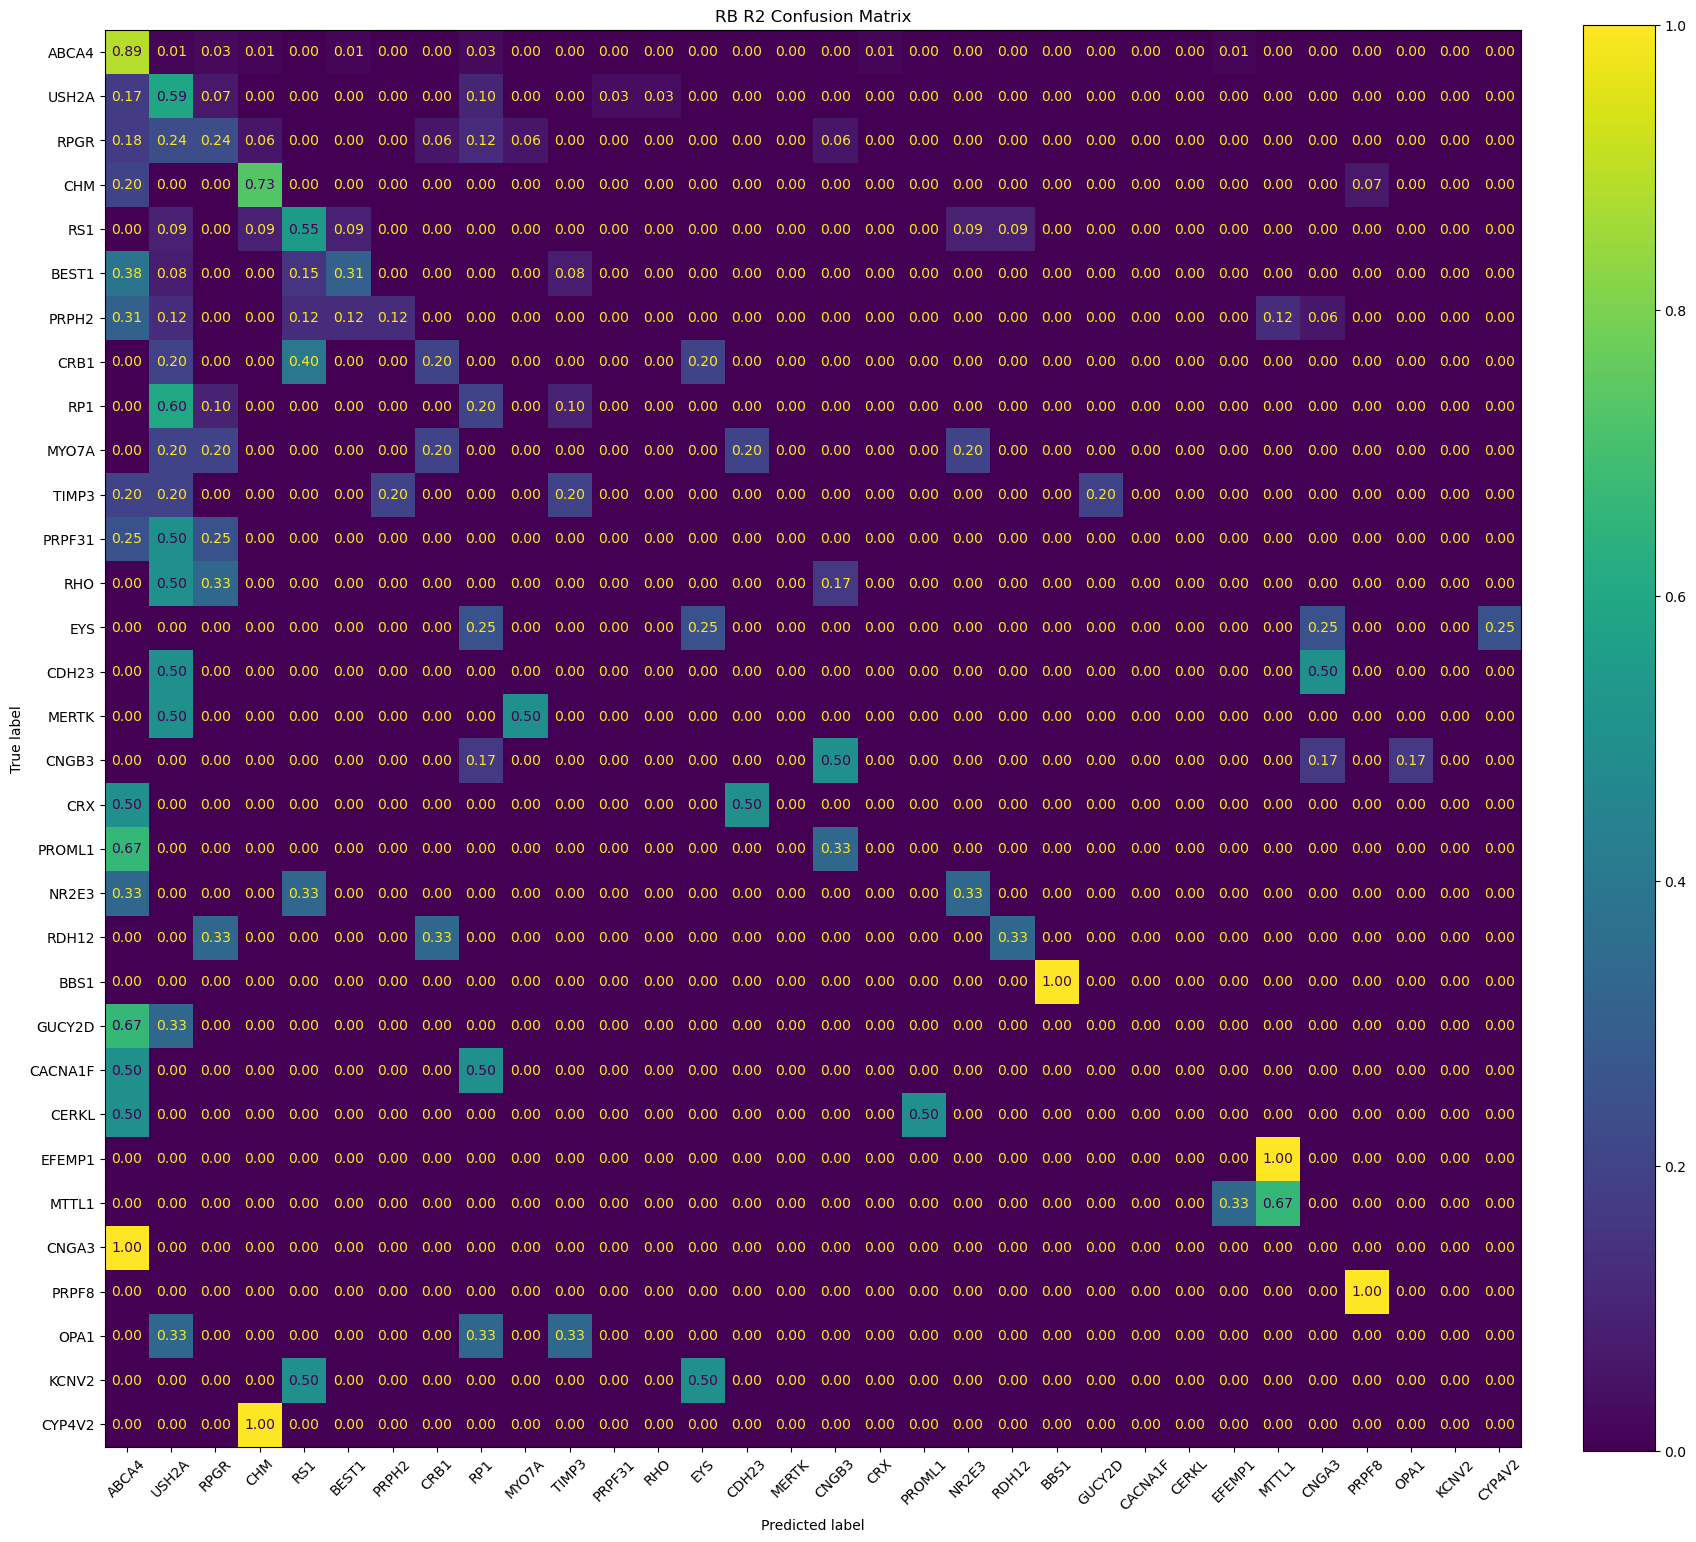

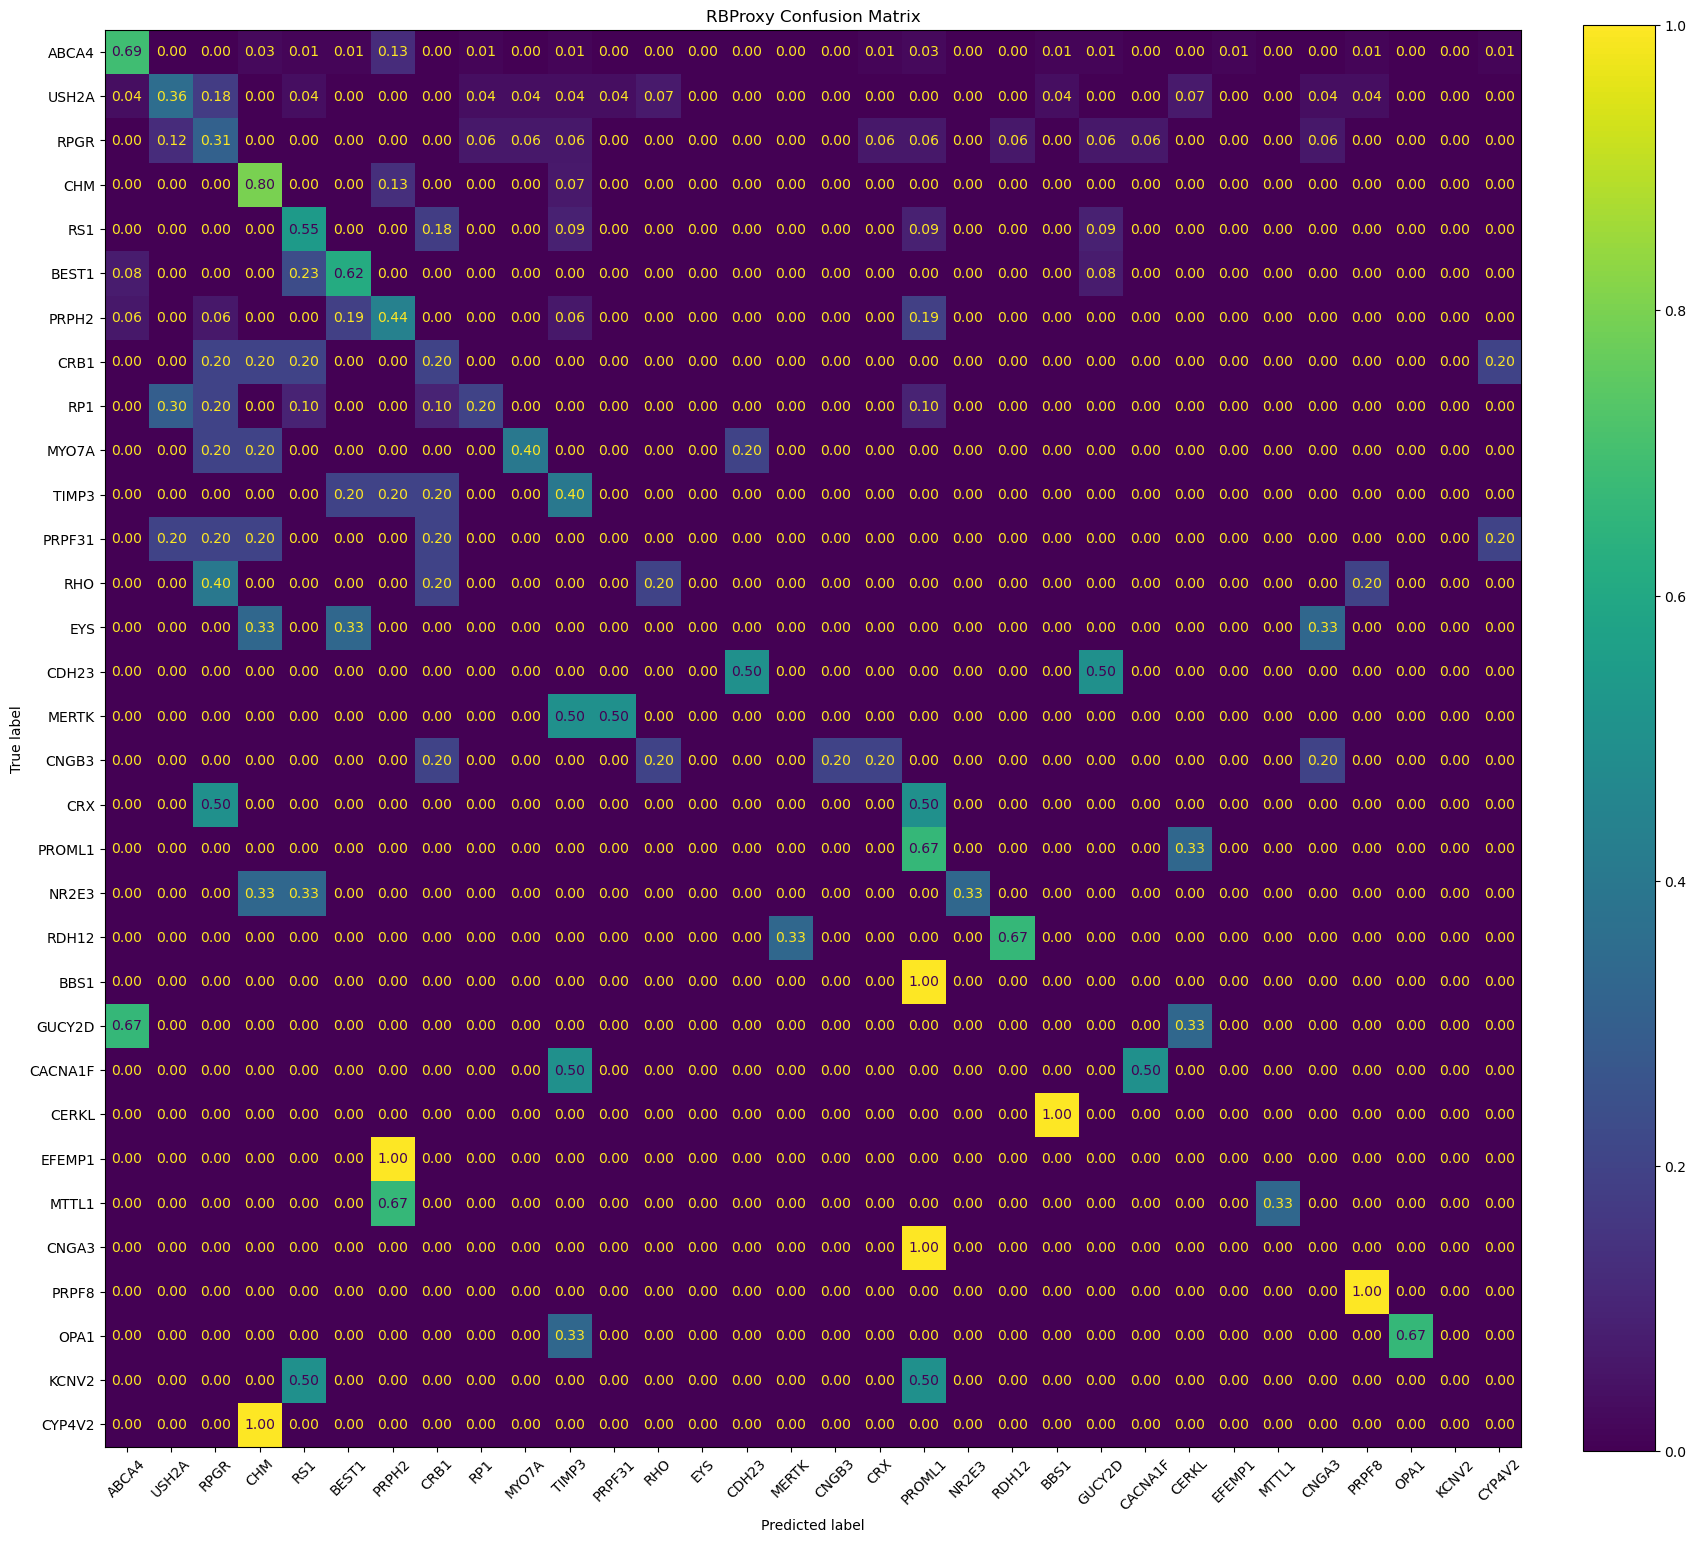

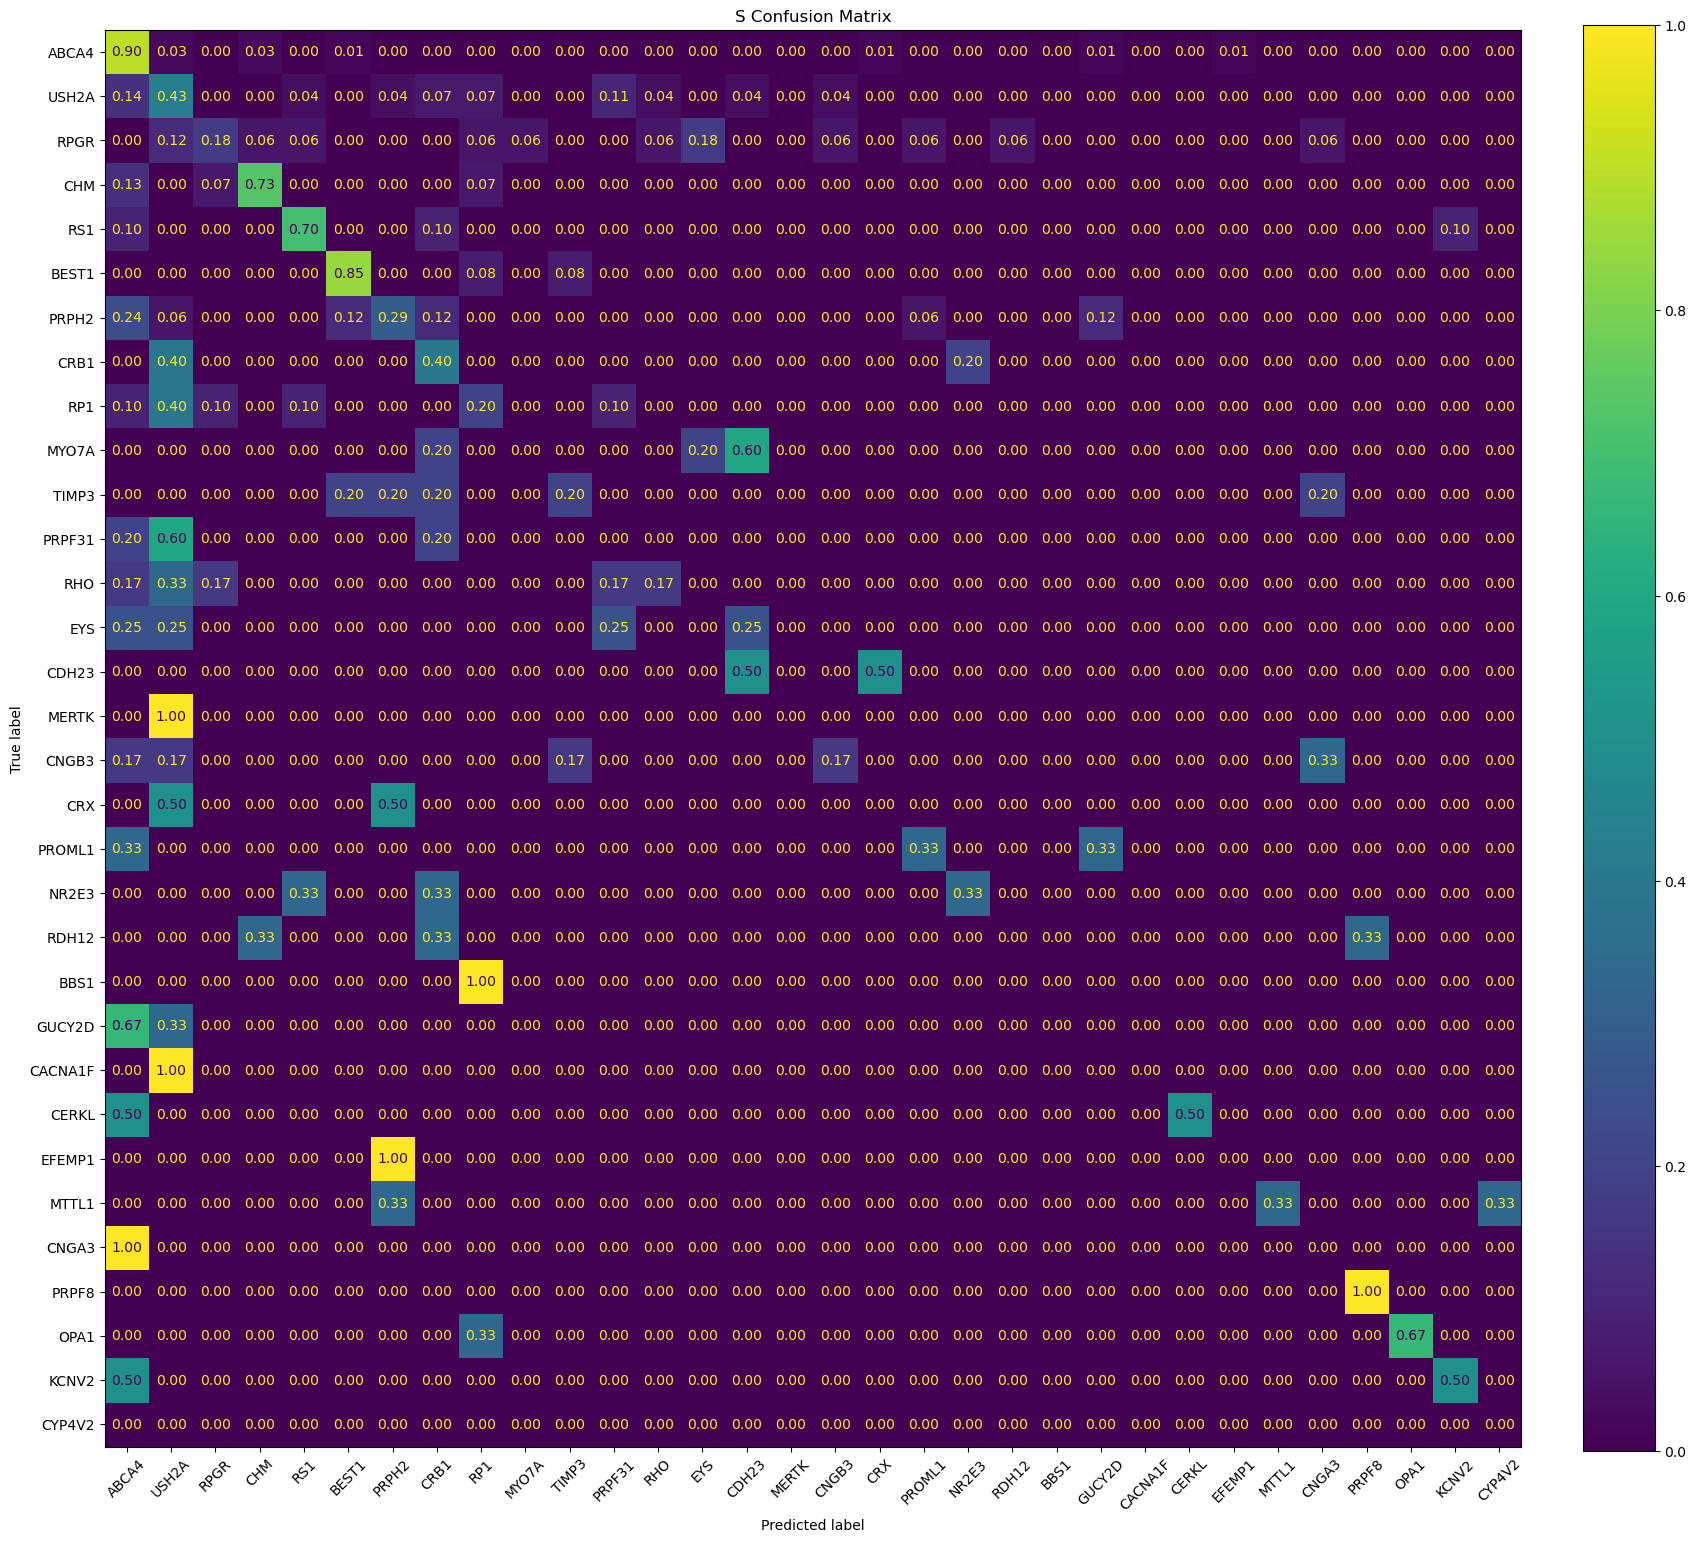

In [46]:
# plot confusion matrices for all models
classes_ordering = list(preds_dict_one_pat['R_r1']['True Class'].value_counts().keys()) 
cm_titles = [m.split('_')[0].upper() + ' ' + m.split('_')[1].upper() if '_' in m else m for m in preds_dict_one_pat.keys()]
cm_one_pat = {m: make_confusion_matrix(preds_dict_one_pat[m], labels=classes_ordering, title=cm_titles[i] + ' Confusion Matrix') for i, m in enumerate(preds_dict_one_pat.keys())}

In [50]:
# plot roc curves
model_results_one_img_per_pat = {}
classes_ordering = list(preds_dict['R_r1']['True Class'].value_counts().keys())
for m in preds_dict_one_pat.keys():
#     cs = [cs for cs in classes if cs in preds_dict[m]['True Class'].unique()]
    auroc = AUROC(preds_dict_one_pat[m], classes_ordering)
    model_results_one_img_per_pat[m] = auroc(random_state=1399)

In [73]:
model_results_one_img_per_pat['R_r1'][1]

auroc     lower     upper
0  0.854206  0.740545  0.939669

In [74]:
model_results['R_r1'][1]

auroc     lower     upper
0  0.864215  0.810018  0.914278

/mnt/data/zchayav/syntheye/classifier_training/analysis/delong.py:73: RuntimeWarning: Degrees of freedom <= 0 for slice
  sx = np.cov(v01)
/home/zchayav/anaconda3/envs/syntheye/lib/python3.8/site-packages/numpy/lib/function_base.py:2493: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/home/zchayav/anaconda3/envs/syntheye/lib/python3.8/site-packages/numpy/lib/function_base.py:2493: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/mnt/data/zchayav/syntheye/classifier_training/analysis/delong.py:73: RuntimeWarning: Degrees of freedom <= 0 for slice
  sx = np.cov(v01)
/home/zchayav/anaconda3/envs/syntheye/lib/python3.8/site-packages/numpy/lib/function_base.py:2493: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/home/zchayav/anaconda3/envs/syntheye/lib/python3.8/site-packages/numpy/lib/function_base.py:2493: RuntimeWarning: invalid value encountered in multiply
  c *= np

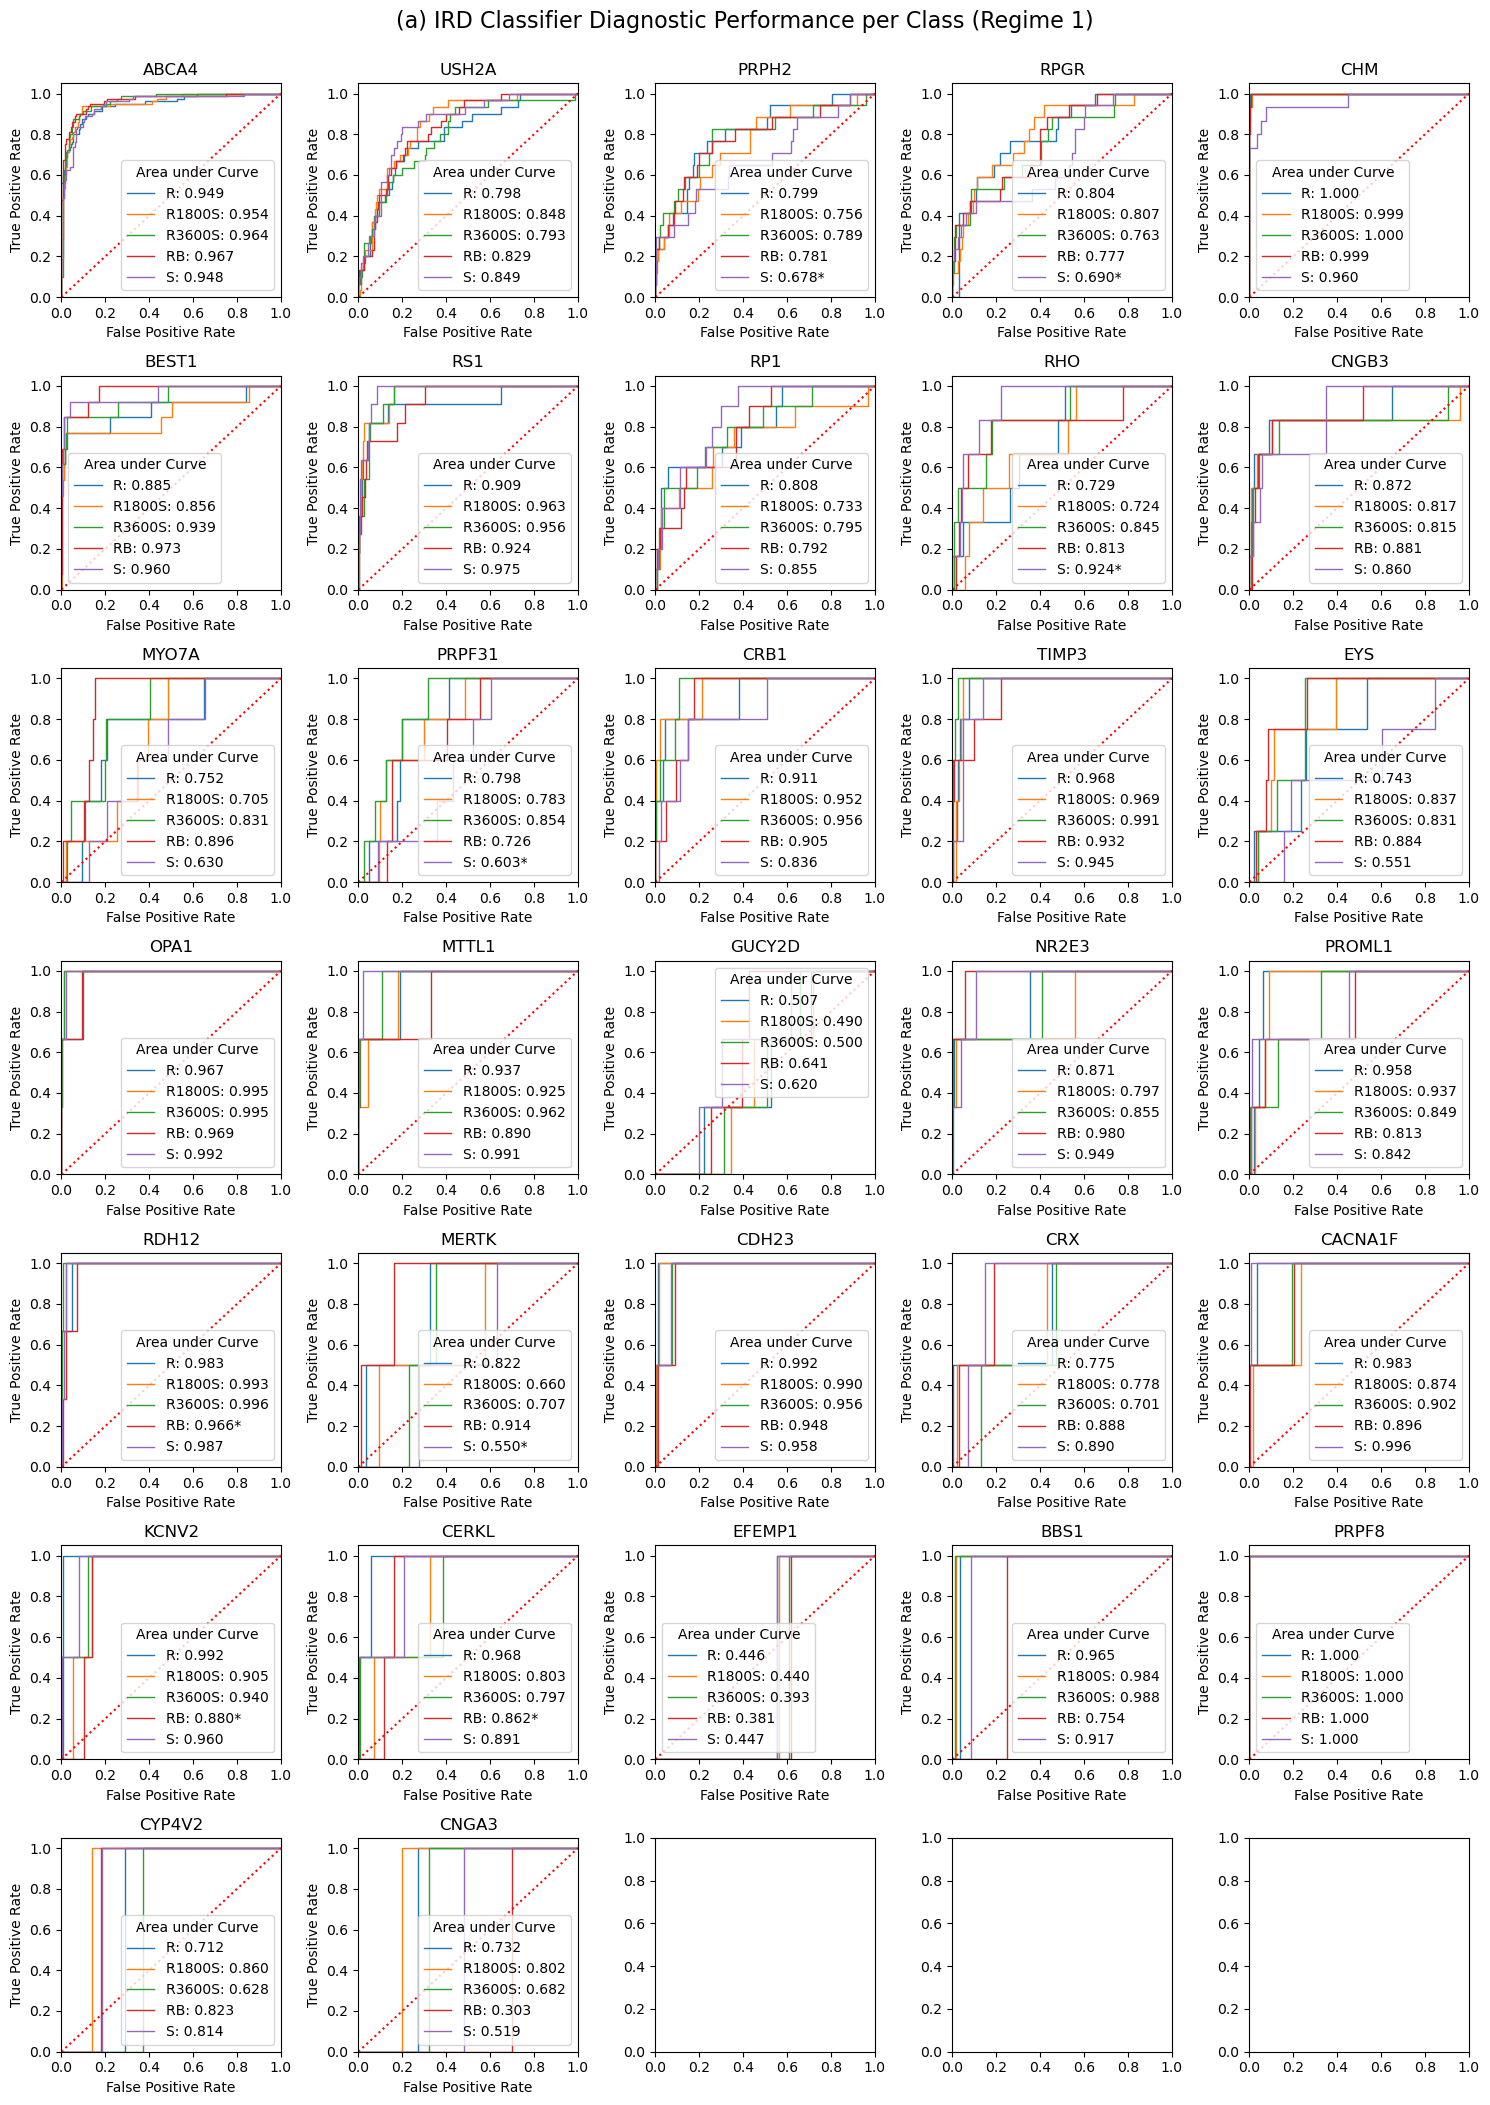

In [103]:
# plot roc regime 1 models
# labels = [cs for cs in classes if cs in preds_dict['R_r1']['True Class'].unique()]
labels = list(preds_dict_one_pat['R_r1']['True Class'].value_counts().keys())
regime1_models = {k: preds_dict_one_pat[k] for k in preds_dict_one_pat.keys() if k.endswith('r1') or (k == 'S')}
plot_roc(7, 5, regime1_models, model_results_one_img_per_pat, labels, '(a) IRD Classifier Diagnostic Performance per Class (Regime 1)', base='R_r1')

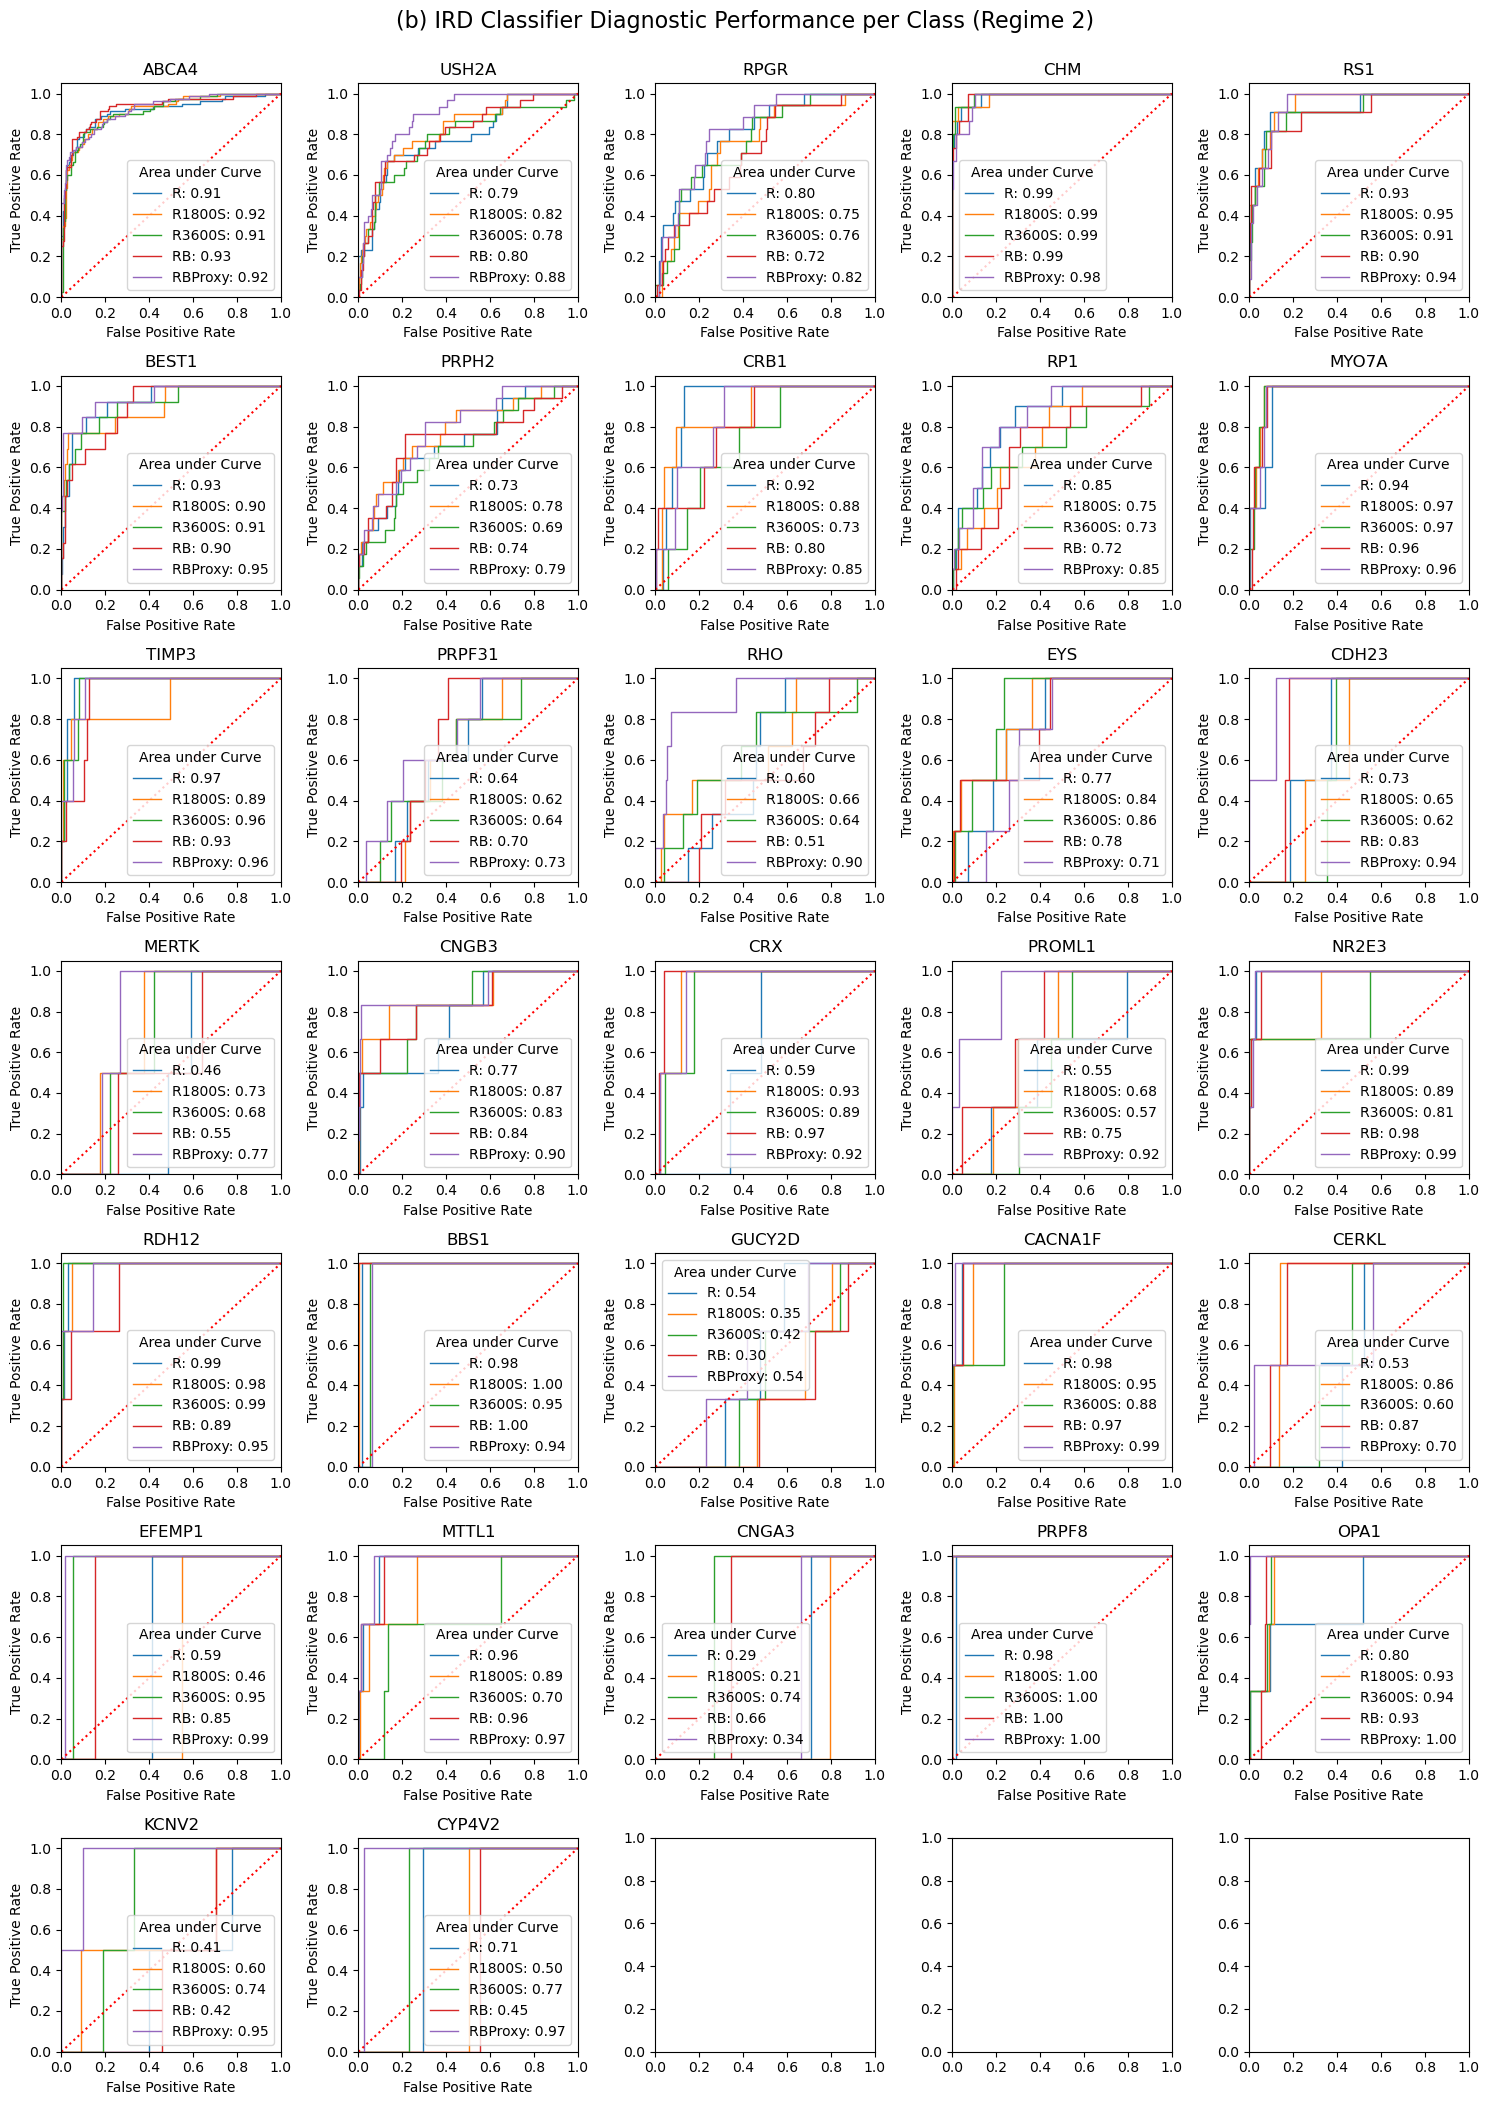

In [53]:
# plot roc regime 2 models
# labels = [cs for cs in classes if cs in preds_dict['R_r2']['True Class'].unique()]
labels = list(preds_dict['R_r1']['True Class'].value_counts().keys())
regime2_models = {k: preds_dict_one_pat[k] for k in preds_dict_one_pat.keys() if k.endswith('r2') or (k == 'RBProxy')}
plot_roc(7, 5, regime2_models, model_results_one_img_per_pat, labels, '(b) IRD Classifier Diagnostic Performance per Class (Regime 2)')

In [56]:
# create df of aucs for each model
aucs_per_model_one_pat = pd.DataFrame(columns=['Class', *model_results_one_img_per_pat.keys()])
for m in model_results_one_img_per_pat.keys():
    aucs_df = model_results_one_img_per_pat[m][0]
    aucs_per_model_one_pat[m] = aucs_df['auroc']
aucs_per_model_one_pat['Class'] = aucs_df['Class']
aucs_per_model_one_pat

Class      R_r1  R1800S_r1  R3600S_r1     RB_r1      R_r2  R1800S_r2  \
0     ABCA4  0.948639   0.954011   0.963611  0.966855  0.913986   0.915782   
1     USH2A  0.798351   0.847566   0.793096  0.828956  0.787243   0.822867   
2      RPGR  0.803887   0.807237   0.763248  0.776688  0.800849   0.746594   
3       CHM  0.999718   0.998876   1.000000  0.999014  0.987241   0.987857   
4       RS1  0.908788   0.963271   0.955827  0.924344  0.926741   0.949452   
5     BEST1  0.885039   0.855591   0.938812  0.973251  0.928069   0.901411   
6     PRPH2  0.799204   0.755922   0.789182  0.780690  0.731105   0.776830   
7      CRB1  0.911283   0.951570   0.955647  0.905416  0.918072   0.876455   
8       RP1  0.807749   0.732628   0.795056  0.791895  0.849134   0.752138   
9     MYO7A  0.751811   0.704989   0.830524  0.896289  0.942811   0.971045   
10    TIMP3  0.968052   0.969038   0.991379  0.931799  0.974973   0.887934   
11   PRPF31  0.797532   0.783159   0.853568  0.725666  0.642074   0.621066   
12      RHO  0.729468   0.723886   0.844770  0.812808  0.602803   0.659917   
13      EYS  0.742656   0.837109   0.831367  0.884210  0.769855   0.837961   
14    CDH23  0.992171   0.989874   0.955676  0.948158  0.727923   0.651663   
15    MERTK  0.822005   0.659729   0.707320  0.913641  0.461443   0.725286   
16    CNGB3  0.872032   0.816506   0.814588  0.881003  0.774912   0.871387   
17      CRX  0.775185   0.777865   0.700740  0.888426  0.590395   0.932326   
18   PROML1  0.957577   0.936767   0.848625  0.812585  0.551000   0.681206   
19    NR2E3  0.871060   0.796716   0.854698  0.979695  0.986361   0.885518   
20    RDH12  0.983155   0.993493   0.996149  0.966195  0.985307   0.980372   
21     BBS1  0.964919   0.984292   0.987898  0.754244  0.984285   0.996212   
22   GUCY2D  0.507425   0.489907   0.500006  0.641459  0.535596   0.349244   
23  CACNA1F  0.982521   0.873928   0.901551  0.896282  0.978253   0.950193   
24    CERKL  0.968337   0.802892   0.796912  0.862365  0.527471   0.863541   
25   EFEMP1  0.446076   0.439756   0.393305  0.380876  0.586296   0.455215   
26    MTTL1  0.936728   0.924783   0.961770  0.890381  0.961964   0.891001   
27    CNGA3  0.731683   0.802453   0.682226  0.303296  0.293933   0.205717   
28    PRPF8  1.000000   1.000000   1.000000  1.000000  0.984851   1.000000   
29     OPA1  0.967224   0.995146   0.994801  0.968508  0.796449   0.933396   
30    KCNV2  0.992432   0.904593   0.939950  0.879980  0.407598   0.599743   
31   CYP4V2  0.711889   0.859562   0.628212  0.822644  0.706951   0.499024   

    R3600S_r2     RB_r2   RBProxy         S  
0    0.911412  0.928150  0.922681  0.947705  
1    0.781102  0.800950  0.884339  0.849024  
2    0.762953  0.715026  0.823180  0.690410  
3    0.991947  0.987140  0.979365  0.960180  
4    0.909153  0.900999  0.943294  0.975132  
5    0.910346  0.899400  0.946811  0.960334  
6    0.693438  0.737914  0.793271  0.677942  
7    0.728005  0.804230  0.847210  0.835588  
8    0.726419  0.717220  0.851368  0.854512  
9    0.967300  0.960215  0.960886  0.630285  
10   0.963642  0.925552  0.956099  0.944669  
11   0.640348  0.697352  0.732315  0.602888  
12   0.642242  0.509019  0.902684  0.923616  
13   0.864509  0.780606  0.711451  0.550693  
14   0.623502  0.828809  0.935342  0.958316  
15   0.677010  0.552339  0.772759  0.550469  
16   0.831126  0.837208  0.898092  0.860420  
17   0.889531  0.974092  0.919273  0.889774  
18   0.566792  0.751942  0.915162  0.841634  
19   0.805056  0.978031  0.985213  0.948724  
20   0.994780  0.894272  0.949587  0.987260  
21   0.946963  1.000000  0.939297  0.917424  
22   0.416638  0.301471  0.542839  0.619514  
23   0.880649  0.974982  0.994251  0.996123  
24   0.602115  0.867436  0.698707  0.890866  
25   0.947490  0.850732  0.985823  0.446698  
26   0.701246  0.955750  0.972932  0.991254  
27   0.735170  0.659301  0.337926  0.519391  
28   1.000000  1.000000  1.000000  1.000000  
29   0.938207  0.932910  0.998706  0.992167  
30   

## Compare the AUC of the full test set vs one image per patient test set

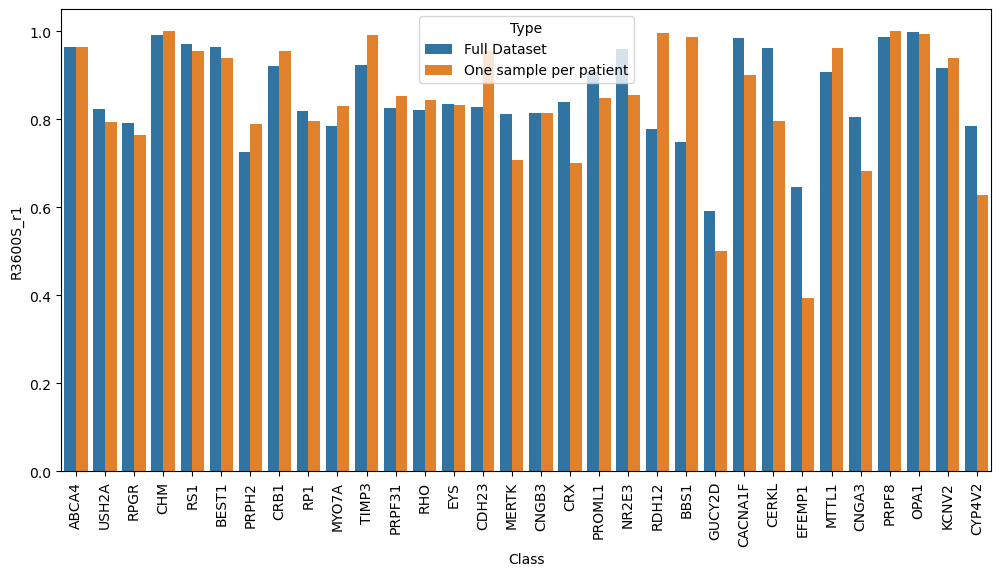

In [72]:
aucs_per_model_full_df['Type'] = ['Full Dataset']*len(aucs_per_model_full_df)
aucs_per_model_one_pat['Type'] = ['One sample per patient']*len(aucs_per_model_one_pat)
all_aucs = pd.concat([aucs_per_model_full_df, aucs_per_model_one_pat], axis=0, ignore_index=True)

plt.figure(figsize=(12, 6))
sns.barplot(data=all_aucs, x='Class', y='R3600S_r1', hue='Type')
plt.xticks(rotation=90)
plt.show()

In [60]:
wilcoxon_test(aucs_per_model_full_df['R_r1'], aucs_per_model_one_pat['R_r1'])

(196.0, 0.20354090606892605)

In [61]:
wilcoxon_test(aucs_per_model_full_df['R_r2'], aucs_per_model_one_pat['R_r2'])

(187.0, 0.14991879406043637)

In [67]:
wilcoxon_test(aucs_per_model_full_df['R1800S_r1'], aucs_per_model_one_pat['R1800S_r1'])

(190.0, 0.16644373380713584)

In [68]:
wilcoxon_test(aucs_per_model_full_df['R3600S_r1'], aucs_per_model_one_pat['R3600S_r1'])

(218.0, 0.3897056839844817)

In [69]:
wilcoxon_test(aucs_per_model_full_df['RB_r1'], aucs_per_model_one_pat['RB_r1'])

(146.0, 0.027350766036667994)

In [70]:
wilcoxon_test(aucs_per_model_full_df['RBProxy'], aucs_per_model_one_pat['RBProxy'])

(248.0, 0.7648003915420281)

In [71]:
wilcoxon_test(aucs_per_model_full_df['S'], aucs_per_model_one_pat['S'])

(165.0, 0.06414149904296203)